In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mouse-bladder/Mouse_bladder_data.h5


In [12]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install scanpy matplotlib seaborn pandas numpy

Note: you may need to restart the kernel to use updated packages.


In [14]:
#Imports
import random
import itertools
import h5py
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse
from scipy import sparse
from scipy.optimize import linear_sum_assignment
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense


=== Dataset Overview ===
Shape (Cells x Genes): (2746, 20670)
First 5 Cell IDs: ['Bladder_1.AAAACGAAAACGGGGCGA', 'Bladder_1.AAAACGAAGCGGCCGCTA', 'Bladder_1.AAAACGAAGTACTAGCAT', 'Bladder_1.AAAACGACGTTGCTGTGT', 'Bladder_1.AAAACGAGCGAGCGAGTA']
First 5 Gene Names: ['0610007P14Rik', '0610009B22Rik', '0610009E02Rik', '0610009L18Rik', '0610009O20Rik']

Sparsity of expression matrix: 94.87%

=== Summary statistics for first 5 genes ===
                   mean       std  min  25%  50%  75%  max
0610007P14Rik  0.143481  0.409126  0.0  0.0  0.0  0.0  5.0
0610009B22Rik  0.115805  0.388905  0.0  0.0  0.0  0.0  6.0
0610009E02Rik  0.003642  0.060247  0.0  0.0  0.0  0.0  1.0
0610009L18Rik  0.040787  0.215461  0.0  0.0  0.0  0.0  3.0
0610009O20Rik  0.069920  0.274327  0.0  0.0  0.0  0.0  3.0


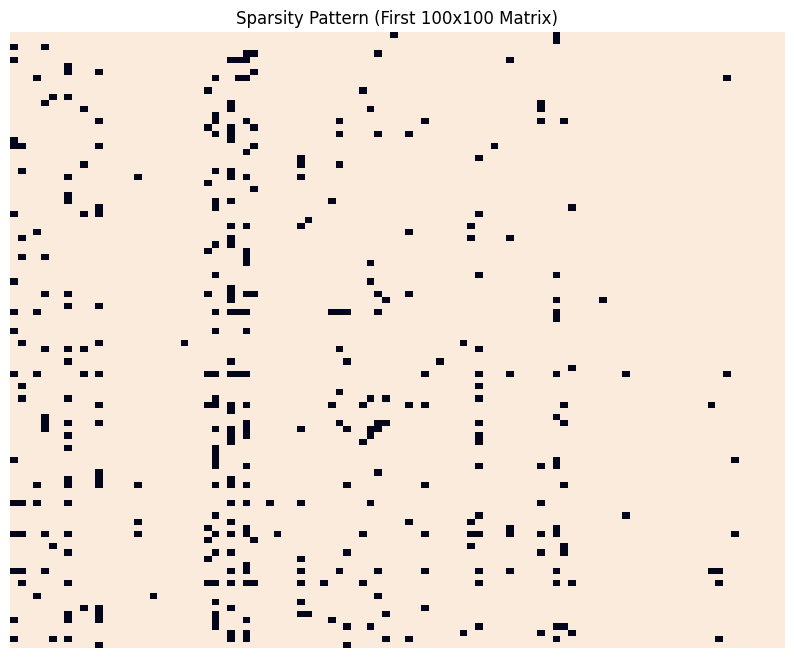

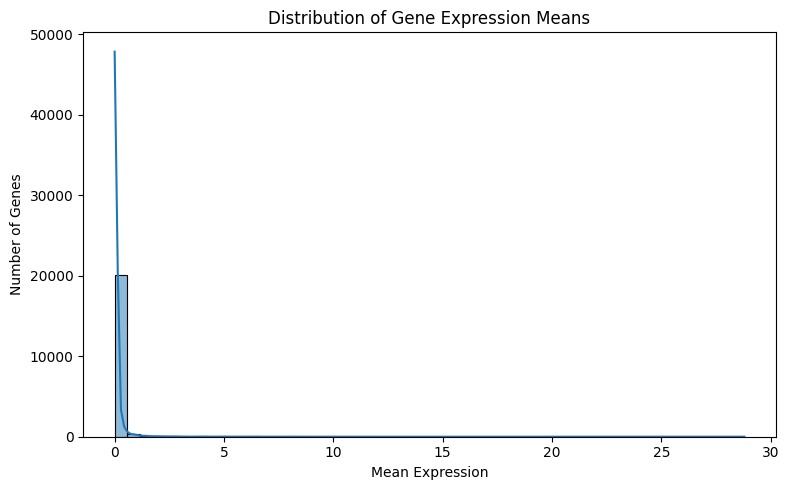


=== Class Distribution (First 10 Classes) ===
label
1     717
2     357
3     344
4     316
5     236
6     224
7     131
8      80
9      75
10     64
Name: count, dtype: int64


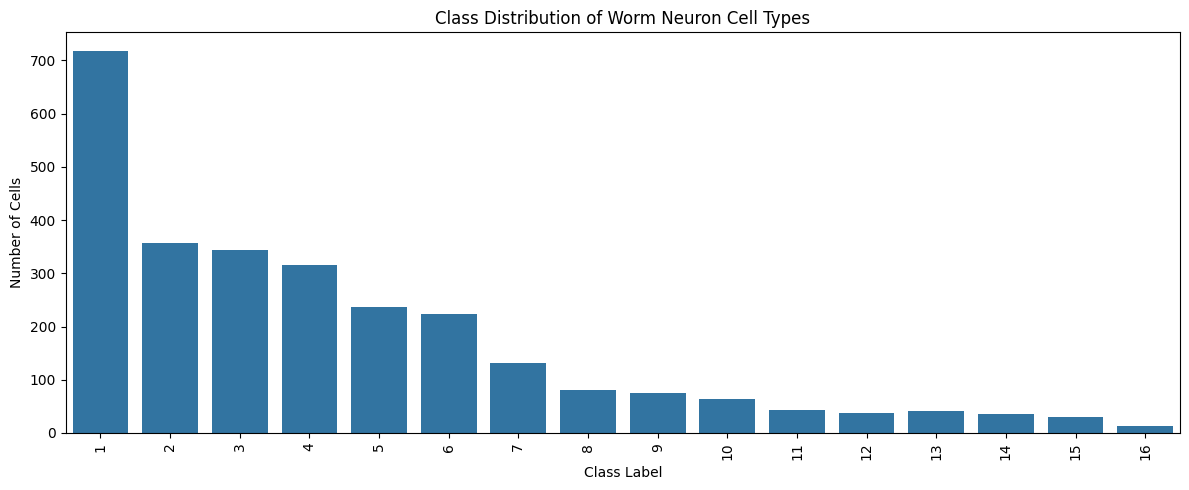

In [15]:
# Loading the custom HDF5 dataset 
file_path = "/kaggle/input/mouse-bladder/Mouse_bladder_data.h5"
with h5py.File(file_path, 'r') as f:
    X = f['X'][:]  # Expression matrix
    Y = f['Y'][:]  # True labels (cell types)
    cell_names = [x.decode() for x in f['cell_name'][:]]
    gene_names = [x.decode() for x in f['gene_name'][:]]

# === Step 1: Build AnnData with raw counts ===
df = pd.DataFrame(X, index=cell_names, columns=gene_names)
adata = sc.AnnData(df)
adata.write("worm_neuron_data.h5ad")

# Attaching true labels to adata.obs
label_series = pd.Series(Y, index=cell_names, name="label")
adata.obs["label"] = label_series

# Saving AnnData for future use 
adata.write("worm_neuron_data_labeled.h5ad")

# Summary Statistics 
print("=== Dataset Overview ===")
print(f"Shape (Cells x Genes): {adata.shape}")
print(f"First 5 Cell IDs: {adata.obs_names[:5].tolist()}")
print(f"First 5 Gene Names: {adata.var_names[:5].tolist()}")

# Sparsity
num_zeros = (adata.X == 0).sum()
total = adata.X.size
sparsity = num_zeros / total
print(f"\nSparsity of expression matrix: {sparsity * 100:.2f}%")

# Per-gene summary 
summary_stats = df.describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
print("\n=== Summary statistics for first 5 genes ===")
print(summary_stats.head())

# Sparsity Heatmap 
subset = df.iloc[:100, :100]
plt.figure(figsize=(10, 8))
sns.heatmap((subset == 0), cbar=False, xticklabels=False, yticklabels=False)
plt.title("Sparsity Pattern (First 100x100 Matrix)")
plt.show()

# Gene Mean Distribution 
gene_means = df.mean(axis=0)
plt.figure(figsize=(8, 5))
sns.histplot(gene_means, bins=50, kde=True)
plt.title("Distribution of Gene Expression Means")
plt.xlabel("Mean Expression")
plt.ylabel("Number of Genes")
plt.tight_layout()
plt.show()

# Class Imbalance Check 
label_counts = adata.obs["label"].value_counts().sort_index()
label_counts.index = label_counts.index.astype(str)

print("\n=== Class Distribution (First 10 Classes) ===")
print(label_counts.head(10))

plt.figure(figsize=(12, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Class Distribution of Worm Neuron Cell Types")
plt.xlabel("Class Label")
plt.ylabel("Number of Cells")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


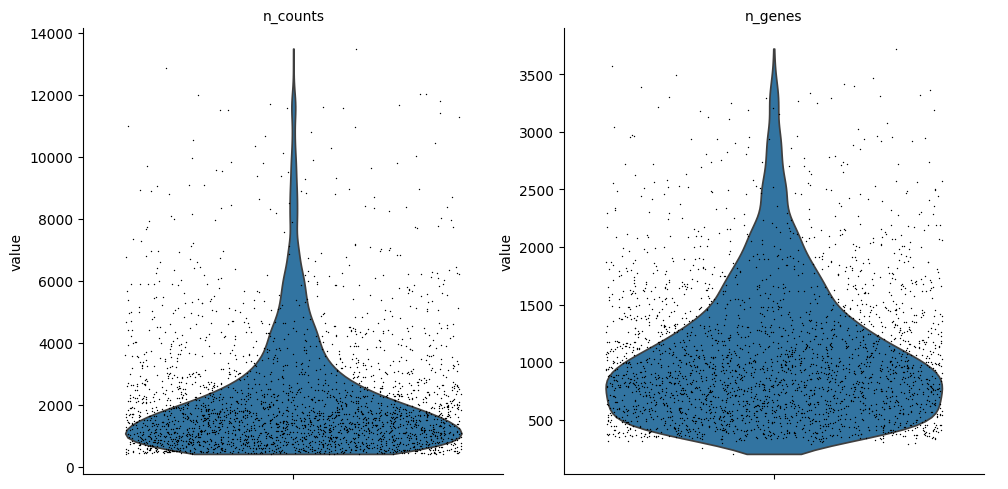

Before filtering: (2746, 20670)
After filtering: (2746, 16138)
HVGs selected: 2000


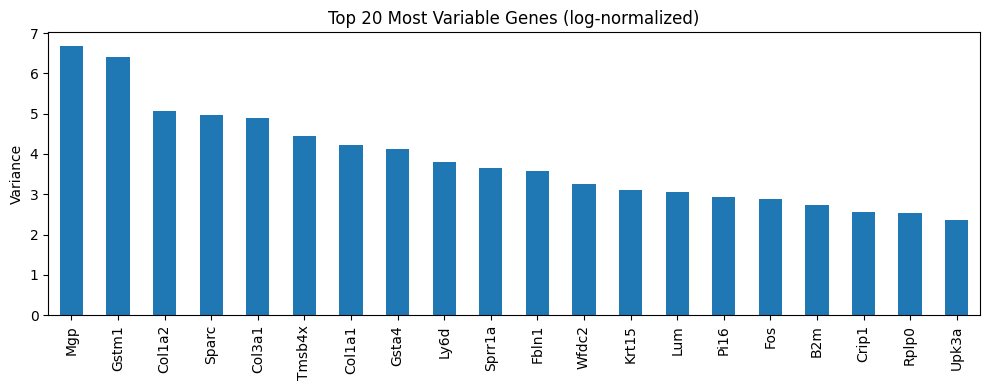

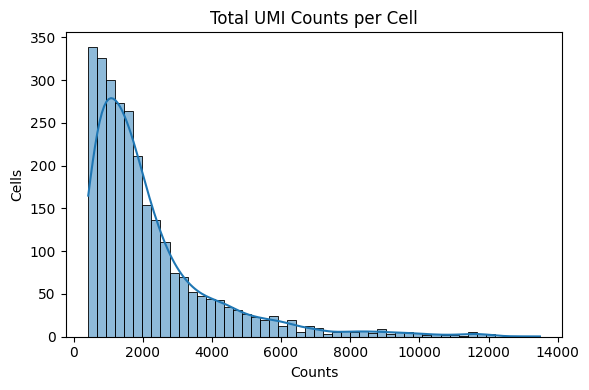

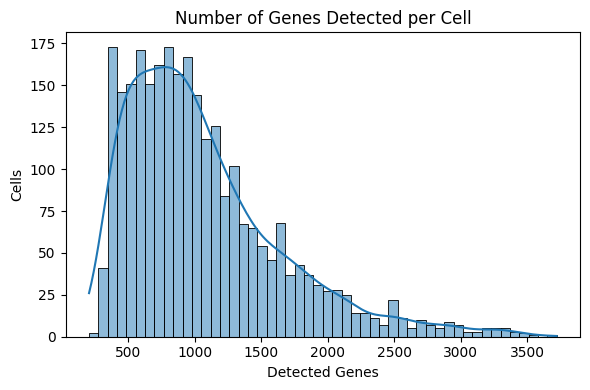

 Filtered raw dataset saved for SCDCC
 Log-normalized dataset saved for exploratory analysis


In [16]:

# Loading raw AnnData object 
adata = sc.read("worm_neuron_data.h5ad")

# Calculating QC metrics 
adata.obs['n_counts'] = adata.X.sum(axis=1).A1 if sparse.issparse(adata.X) else adata.X.sum(axis=1)
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1).A1 if sparse.issparse(adata.X) else (adata.X > 0).sum(axis=1)
adata.var['n_cells'] = (adata.X > 0).sum(axis=0).A1 if sparse.issparse(adata.X) else (adata.X > 0).sum(axis=0)

# Visualizing QC metrics 
sc.pl.violin(adata, ['n_counts', 'n_genes'], jitter=0.4, multi_panel=True)

# Applying relaxed filters 
print(f"Before filtering: {adata.shape}")
sc.pp.filter_cells(adata, min_counts=100)     
sc.pp.filter_cells(adata, min_genes=200)     
sc.pp.filter_genes(adata, min_cells=3)
print(f"After filtering: {adata.shape}")

#  Saving filtered raw counts for SCDCC with ZINB 
adata_raw = adata.copy()
adata_raw.write("worm_neuron_raw_for_scdcc.h5ad")

# Preparing log-normalized 
adata_eda = adata.copy()
sc.pp.normalize_total(adata_eda, target_sum=1e4)
sc.pp.log1p(adata_eda)

# Identifying highly variable genes
sc.pp.highly_variable_genes(adata_eda, n_top_genes=2000, flavor='seurat', inplace=True)
print(f"HVGs selected: {adata_eda.var.highly_variable.sum()}")

# Ploting top HVGs 
top_hvg = adata_eda[:, adata_eda.var.highly_variable].to_df().var().sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 4))
top_hvg.plot(kind='bar')
plt.title("Top 20 Most Variable Genes (log-normalized)")
plt.ylabel("Variance")
plt.tight_layout()
plt.show()

# Ploting UMI count distribution
plt.figure(figsize=(6, 4))
sns.histplot(adata.obs['n_counts'], bins=50, kde=True)
plt.title("Total UMI Counts per Cell")
plt.xlabel("Counts")
plt.ylabel("Cells")
plt.tight_layout()
plt.show()

# Ploting gene detection per cell 
plt.figure(figsize=(6, 4))
sns.histplot(adata.obs['n_genes'], bins=50, kde=True)
plt.title("Number of Genes Detected per Cell")
plt.xlabel("Detected Genes")
plt.ylabel("Cells")
plt.tight_layout()
plt.show()

#  Saving log-normalized 
adata_eda.write("worm_neuron_eda_log_norm.h5ad")

print(" Filtered raw dataset saved for SCDCC")
print(" Log-normalized dataset saved for exploratory analysis")


In [17]:

# Loading raw & log-normalized data 
adata_raw = sc.read("worm_neuron_raw_for_scdcc.h5ad")      
adata_eda = sc.read("worm_neuron_eda_log_norm.h5ad")       

# Subset to HVGs (2000 genes) for constraint set 
if "highly_variable" not in adata_eda.var.columns:
    raise ValueError("HVGs not found. Run highly_variable_genes() before this step.")
adata_eda = adata_eda[:, adata_eda.var.highly_variable].copy()
print(f" HVG Subset Shape: {adata_eda.shape}")

# Sanity check: cell alignment 
assert np.all(adata_raw.obs_names == adata_eda.obs_names), "Mismatch in cell IDs!"

# 80/10/10 split 
indices = np.arange(adata_raw.n_obs)
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=42)

#  Creating subset AnnData objects 
adata_raw_train = adata_raw[train_idx].copy()
adata_raw_val   = adata_raw[val_idx].copy()
adata_raw_test  = adata_raw[test_idx].copy()

adata_eda_train = adata_eda[train_idx].copy()
adata_eda_val   = adata_eda[val_idx].copy()
adata_eda_test  = adata_eda[test_idx].copy()

#  Attaching true labels from original HDF5 
with h5py.File("/kaggle/input/mouse-bladder/Mouse_bladder_data.h5", "r") as f:
    Y_full = f['Y'][:]
    all_cell_names = [x.decode() for x in f['cell_name'][:]]

cell_to_label = dict(zip(all_cell_names, Y_full))

# Attaching labels to RAW splits 
for ad, name in zip(
    [adata_raw_train, adata_raw_val, adata_raw_test],
    ["Train", "Val", "Test"]
):
    ad.obs["label"] = ad.obs_names.map(cell_to_label)
    missing = ad.obs["label"].isna().sum()
    print(f" Labels attached to {name} split. Missing: {missing}")

#Attaching labels to HVG splits 
for ad_hvg, name in zip(
    [adata_eda_train, adata_eda_val, adata_eda_test],
    ["Train", "Val", "Test"]
):
    ad_hvg.obs["label"] = ad_hvg.obs_names.map(cell_to_label)
    missing = ad_hvg.obs["label"].isna().sum()
    print(f" Labels attached to HVG {name} split. Missing: {missing}")

# Printing summary 
print("\n=== Raw (SCDCC) Splits ===")
print(f"Train: {adata_raw_train.shape}, {adata_raw_train.obs_names[:3].tolist()}")
print(f"Val:   {adata_raw_val.shape}, {adata_raw_val.obs_names[:3].tolist()}")
print(f"Test:  {adata_raw_test.shape}, {adata_raw_test.obs_names[:3].tolist()}")

print("\n=== HVG (Constraints) Splits ===")
print(f"Train: {adata_eda_train.shape}, {adata_eda_train.obs_names[:3].tolist()}")
print(f"Val:   {adata_eda_val.shape}, {adata_eda_val.obs_names[:3].tolist()}")
print(f"Test:  {adata_eda_test.shape}, {adata_eda_test.obs_names[:3].tolist()}")

#  Saving all datasets 
adata_raw_train.write("scdcc_raw_train.h5ad")
adata_raw_val.write("scdcc_raw_val.h5ad")
adata_raw_test.write("scdcc_raw_test.h5ad")

adata_eda_train.write("constraints_hvg_train.h5ad")
adata_eda_val.write("constraints_hvg_val.h5ad")
adata_eda_test.write("constraints_hvg_test.h5ad")

print("\n All data splits saved with true labels attached.")


 HVG Subset Shape: (2746, 2000)
 Labels attached to Train split. Missing: 0
 Labels attached to Val split. Missing: 0
 Labels attached to Test split. Missing: 0
 Labels attached to HVG Train split. Missing: 0
 Labels attached to HVG Val split. Missing: 0
 Labels attached to HVG Test split. Missing: 0

=== Raw (SCDCC) Splits ===
Train: (2196, 16138), ['Bladder_1.ATTTGCTCGGGTGCTGTG', 'Bladder_1.GTGGTATGTCACGGGCGA', 'Bladder_1.AGGACTGGGCGAACCTGA']
Val:   (275, 16138), ['Bladder_1.ACACCCGACACTATCAAC', 'Bladder_1.CAAAGTGTCGGTTAGCAT', 'Bladder_1.AGATGGGCTGTGAAAGTT']
Test:  (275, 16138), ['Bladder_1.GTGGTATGGATGAGCGAG', 'Bladder_1.AAGTACGGCTGCTAGTCG', 'Bladder_1.TTCCGCGGACATAGGACT']

=== HVG (Constraints) Splits ===
Train: (2196, 2000), ['Bladder_1.ATTTGCTCGGGTGCTGTG', 'Bladder_1.GTGGTATGTCACGGGCGA', 'Bladder_1.AGGACTGGGCGAACCTGA']
Val:   (275, 2000), ['Bladder_1.ACACCCGACACTATCAAC', 'Bladder_1.CAAAGTGTCGGTTAGCAT', 'Bladder_1.AGATGGGCTGTGAAAGTT']
Test:  (275, 2000), ['Bladder_1.GTGGTATGGATGAG

In [18]:

# Loading labeled AnnData 
adata = sc.read("scdcc_raw_train.h5ad")

# Checking for labels 
if 'label' not in adata.obs.columns:
    raise ValueError(" adata.obs['label'] not found. Please attach true labels before running this.")

# === Group cells by label ===
label_groups = adata.obs.groupby('label').groups  # label → list of cell IDs

# Prompting user for total constraint sizes 
user_input = input(" Enter TOTAL constraint sizes (comma-separated, e.g., 100,500,1000): ")
constraint_sizes = [int(x.strip()) for x in user_input.split(",") if x.strip().isdigit()]
print(f"\n Will generate constraints for TOTAL sizes: {constraint_sizes}")

def generate_constraints(label_groups, total_constraints, seed=42):
    random.seed(seed)
    labels = list(label_groups.keys())
    must_link = set()
    cannot_link = set()
    n_ml = total_constraints // 2 + total_constraints % 2  # if odd, must-link gets extra
    n_cl = total_constraints // 2

    # Must-link: pairs from same class
    while len(must_link) < n_ml:
        label = random.choice(labels)
        members = list(label_groups[label])
        if len(members) >= 2:
            pair = tuple(sorted(random.sample(members, 2)))
            must_link.add(pair)

    # Cannot-link: pairs from different classes
    while len(cannot_link) < n_cl:
        l1, l2 = random.sample(labels, 2)
        if l1 == l2:
            continue
        i = random.choice(label_groups[l1])
        j = random.choice(label_groups[l2])
        pair = tuple(sorted((i, j)))
        if pair not in must_link:  # Don't allow overlap
            cannot_link.add(pair)

    return list(must_link), list(cannot_link)

#  Generating and store constraints in-memory 
constraints = {}

for total_size in constraint_sizes:
    ml, cl = generate_constraints(label_groups, total_constraints=total_size)
    constraints[total_size] = {
        "must_link": ml,
        "cannot_link": cl
    }
    print(f"\n Constraints generated for total size {total_size}:")
    print(f"    Must-link pairs:    {len(ml)}")
    print(f"    Cannot-link pairs:  {len(cl)}")



 Enter TOTAL constraint sizes (comma-separated, e.g., 100,500,1000):  0,1000,2000,3000,4000,5000,6000



 Will generate constraints for TOTAL sizes: [0, 1000, 2000, 3000, 4000, 5000, 6000]

 Constraints generated for total size 0:
    Must-link pairs:    0
    Cannot-link pairs:  0

 Constraints generated for total size 1000:
    Must-link pairs:    500
    Cannot-link pairs:  500

 Constraints generated for total size 2000:
    Must-link pairs:    1000
    Cannot-link pairs:  1000

 Constraints generated for total size 3000:
    Must-link pairs:    1500
    Cannot-link pairs:  1500

 Constraints generated for total size 4000:
    Must-link pairs:    2000
    Cannot-link pairs:  2000

 Constraints generated for total size 5000:
    Must-link pairs:    2500
    Cannot-link pairs:  2500

 Constraints generated for total size 6000:
    Must-link pairs:    3000
    Cannot-link pairs:  3000


 KMeans Baseline Evaluation
 ARI: 0.4547
 NMI: 0.7512
 CA:  0.5927


... storing 'kmeans_pred' as categorical



 PCA & UMAP of KMeans Predictions


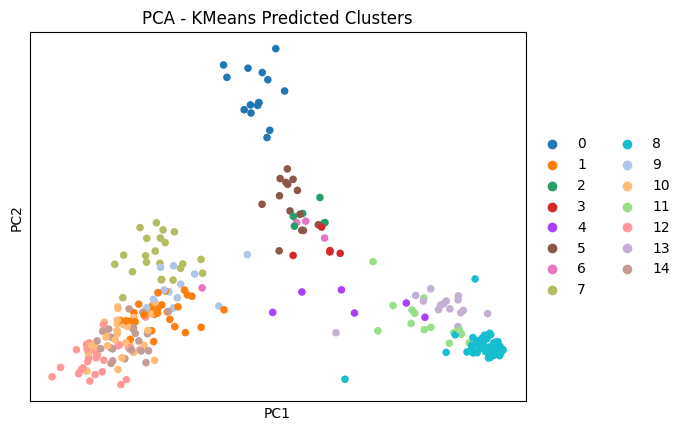

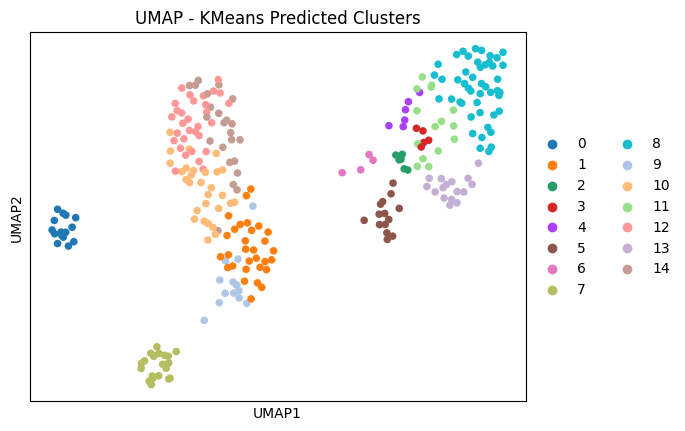

In [19]:

# Loading HVG log-normalized training and test data 
adata_train = sc.read("constraints_hvg_train.h5ad")
adata_test = sc.read("constraints_hvg_test.h5ad")  

#  Extracting matrices and true labels 
X_train = adata_train.X
X_test = adata_test.X
true_labels = adata_test.obs["label"].astype(int).values
n_clusters = len(np.unique(true_labels))

#  Training KMeans on training set 
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(X_train)

#  Predicting test labels
pred_labels = kmeans.predict(X_test)

# Clustering Accuracy 
def clustering_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    return cm[row_ind, col_ind].sum() / y_true.size

# Computing Metrics 
ari_kmeans = adjusted_rand_score(true_labels, pred_labels)
nmi_kmeans = normalized_mutual_info_score(true_labels, pred_labels)
ca_kmeans = clustering_accuracy(true_labels, pred_labels)

#  results 
kmeans_results = {
    "ARI": ari_kmeans,
    "NMI": nmi_kmeans,
    "CA": ca_kmeans,
    "true_labels": true_labels,
    "pred_labels": pred_labels
}

# Metrics
print(" KMeans Baseline Evaluation")
print(f" ARI: {ari_kmeans:.4f}")
print(f" NMI: {nmi_kmeans:.4f}")
print(f" CA:  {ca_kmeans:.4f}")

#  visualization 
adata_vis = adata_test.copy()
adata_vis.obs["true_label"] = pd.Series(true_labels, index=adata_vis.obs_names).astype(str)
adata_vis.obs["kmeans_pred"] = pd.Series(pred_labels, index=adata_vis.obs_names).astype(str)

adata_vis = adata_test.copy()
adata_vis.obs["kmeans_pred"] = pd.Series(pred_labels, index=adata_vis.obs_names).astype(str)


#  Dimensionality Reduction 
sc.pp.pca(adata_vis, n_comps=50)
sc.pp.neighbors(adata_vis)
sc.tl.umap(adata_vis)

# Visualizing predicted KMeans clusters
print("\n PCA & UMAP of KMeans Predictions")
sc.pl.pca(
    adata_vis,
    color="kmeans_pred",
    title="PCA - KMeans Predicted Clusters",
    size=120,
    show=True
)

sc.pl.umap(
    adata_vis,
    color="kmeans_pred",
    title="UMAP - KMeans Predicted Clusters",
    size=120,
    show=True
)



Integer label mapping (for metrics):
0: 2
1: 5
2: 9
3: 6
4: 15
5: 7
6: 4
7: 1
8: 3
9: 14
10: 12
11: 10
12: 8
13: 11
14: 13
Training shape: (2196, 2000), Test shape: (275, 2000), Clusters: 15
 Pretraining Autoencoder...
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 0.2252
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1743
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1510
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1327
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1282
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1210
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1148
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1096
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1071
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1025
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1028
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1034
Epoch 13/50
9/9 ━━━━

... storing 'dec_pred' as categorical


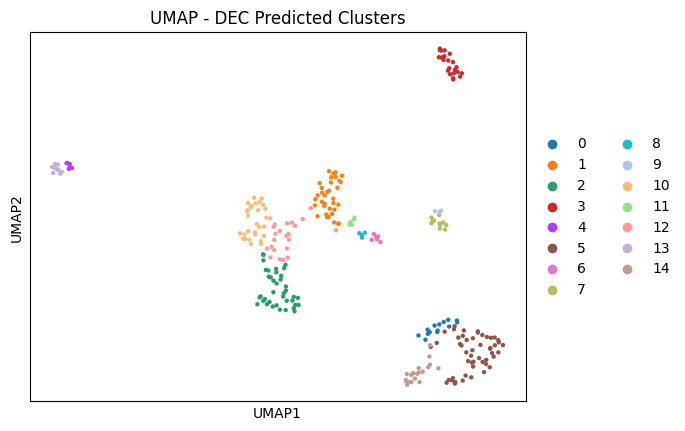

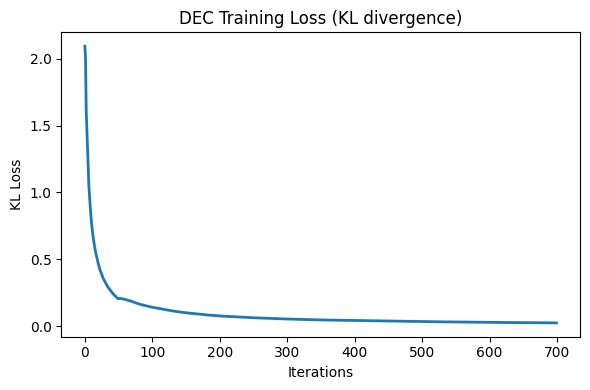

In [20]:

#Loading Data
adata_train = sc.read("constraints_hvg_train.h5ad")
adata_test = sc.read("constraints_hvg_test.h5ad") 

X_train = adata_train.X.astype(np.float32)
X_test = adata_test.X.astype(np.float32)
true_labels, unique_types = pd.factorize(adata_test.obs["label"].astype(str).values)
n_clusters = len(np.unique(true_labels))

print("Integer label mapping (for metrics):")
for i, name in enumerate(unique_types):
    print(f"{i}: {name}")

print(f"Training shape: {X_train.shape}, Test shape: {X_test.shape}, Clusters: {n_clusters}")

# Clustering Accuracy 
def clustering_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    return cm[row_ind, col_ind].sum() / y_true.size

#  Autoencoder Definition & Pretrain 
input_dim = X_train.shape[1]
encoding_dim = 10

input_layer = Input(shape=(input_dim,))
encoded = Dense(500, activation='relu')(input_layer)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(2000, activation='relu')(encoded)
latent = Dense(encoding_dim, name='latent')(encoded)

decoded = Dense(2000, activation='relu')(latent)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(500, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
encoder = Model(inputs=input_layer, outputs=latent)

autoencoder.compile(optimizer='adam', loss='mse')
print(" Pretraining Autoencoder...")
autoencoder.fit(X_train, X_train, batch_size=256, epochs=50, verbose=1)

#KMeans Init 
Z_train = encoder.predict(X_train)
Z_test = encoder.predict(X_test)
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
kmeans.fit(Z_train)
cluster_centers = kmeans.cluster_centers_

#  Clustering Layer 
class ClusteringLayer(tf.keras.layers.Layer):
    def __init__(self, n_clusters, initial_weights=None, **kwargs):
        super().__init__(**kwargs)
        self.n_clusters = n_clusters
        self.initial_weights = initial_weights

    def build(self, input_shape):
        input_dim = input_shape[1]
        self.clusters = self.add_weight(
            shape=(self.n_clusters, input_dim),
            initializer='glorot_uniform',
            name='clusters'
        )
        if self.initial_weights is not None:
            self.set_weights([self.initial_weights.astype(np.float32)])
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        # Student’s t-distribution
        q = 1.0 / (1.0 + (tf.reduce_sum(tf.square(tf.expand_dims(inputs, axis=1) - self.clusters), axis=2)))
        q = q ** ((self.n_clusters + 1.0) / 2.0)
        q_sum = tf.reduce_sum(q, axis=1, keepdims=True)
        q = q / (q_sum + 1e-8)  # Protects against division by zero
        q = tf.clip_by_value(q, 1e-8, 1.0)
        return q

# Targeting Distribution 
def target_distribution(q, eps=1e-8):
    q = np.clip(q, eps, 1.0)
    weight = q ** 2 / (np.sum(q, axis=0, keepdims=True) + eps)
    p = (weight.T / (np.sum(weight, axis=1) + eps)).T
    return p

#  Building DEC Model 
clustering_layer = ClusteringLayer(n_clusters, initial_weights=cluster_centers, name='clustering')(encoder.output)
dec_model = Model(inputs=encoder.input, outputs=clustering_layer)
dec_model.compile(optimizer='adam', loss='kld')

#KL Fine-tuning 
print(" Fine-tuning DEC with KL divergence...")
maxiter = 5000
update_interval = 50
tol = 1e-4
min_kl_updates = 2  # Stop after 2 consecutive below-tol
kl_no_change = 0
batch_size = 256
loss_history = []
index_array = np.arange(X_train.shape[0])

q = dec_model.predict(X_train, verbose=0)
assert np.isfinite(q).all(), "NaNs in initial q!"
p = target_distribution(q)
assert np.isfinite(p).all(), "NaNs in initial p!"
y_pred_last = q.argmax(1)

for ite in range(maxiter):
    if ite % update_interval == 0:
        q = dec_model.predict(X_train, verbose=0)
        if not np.isfinite(q).all():
            print(f"NaNs detected in q at iter {ite}")
            print("q stats: min", np.nanmin(q), "max", np.nanmax(q))
            break
        p = target_distribution(q)
        if not np.isfinite(p).all():
            print(f"NaNs detected in p at iter {ite}")
            print("p stats: min", np.nanmin(p), "max", np.nanmax(p))
            break
        y_pred = q.argmax(1)
        label_change_rate = np.mean(y_pred != y_pred_last)
        print(f"Iter {ite}, Label change rate: {label_change_rate:.5f}")
        if label_change_rate < tol:
            kl_no_change += 1
            if kl_no_change >= min_kl_updates:
                print(f"Converged (label change rate < tol for {min_kl_updates} consecutive intervals).")
                break
        else:
            kl_no_change = 0
        y_pred_last = y_pred
    # Batch update
    idx = np.random.choice(index_array, batch_size, replace=False)
    loss = dec_model.train_on_batch(X_train[idx], p[idx])
    loss_history.append(float(loss))

#  Evaluating on Test Set 
q_test = dec_model.predict(X_test)
pred_labels = q_test.argmax(1)
ari = adjusted_rand_score(true_labels, pred_labels)
nmi = normalized_mutual_info_score(true_labels, pred_labels)
ca = clustering_accuracy(true_labels, pred_labels)

print("\n DEC (with KL fine-tuning) Evaluation")
print(f" ARI: {ari:.4f}")
print(f" NMI: {nmi:.4f}")
print(f" CA:  {ca:.4f}")

# Saving results 
dec_results = {
    "ARI": ari,
    "NMI": nmi,
    "CA": ca,
    "true_labels": true_labels,
    "pred_labels": pred_labels,
    "kl_loss_history": loss_history,
}

# UMAP Visualization 
adata_vis = adata_test.copy()
adata_vis.obsm["X_latent"] = encoder.predict(X_test)
adata_vis.obs["dec_pred"] = pd.Series(pred_labels, index=adata_vis.obs_names).astype(str)
sc.pp.neighbors(adata_vis, use_rep="X_latent")
sc.tl.umap(adata_vis)
sc.pl.umap(adata_vis, color="dec_pred", title="UMAP - DEC Predicted Clusters", size=40)

#  KL Loss Curve 
plt.figure(figsize=(6, 4))
plt.plot(loss_history, lw=2)
plt.title("DEC Training Loss (KL divergence)")
plt.xlabel("Iterations")
plt.ylabel("KL Loss")
plt.tight_layout()
plt.show()


In [21]:


#  DEVICE SETUP 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#  UTILS 
def clustering_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    return cm[row_ind, col_ind].sum() / y_true.size

class IndexedTensorDataset(TensorDataset):
    def __getitem__(self, idx):
        data = super().__getitem__(idx)
        return (*data, idx)

def get_in_batch_pairs(batch_indices, constraint_pairs):
    batch_map = {idx: i for i, idx in enumerate(batch_indices)}
    pairs_in_batch = [
        (batch_map[i], batch_map[j])
        for i, j in constraint_pairs if i in batch_map and j in batch_map
    ]
    return pairs_in_batch

def contrastive_loss(z, must_link, cannot_link, margin=2.0, alpha=1.0, beta=5.0):
    loss_ml = 0.0
    loss_cl = 0.0
    eps = 1e-9
    if len(must_link) > 0:
        for i, j in must_link:
            dist = torch.norm(z[i] - z[j], p=2)
            loss_ml += dist ** 2
        loss_ml = loss_ml / (len(must_link) + eps)
    if len(cannot_link) > 0:
        for i, j in cannot_link:
            dist = torch.norm(z[i] - z[j], p=2)
            loss_cl += F.relu(margin - dist) ** 2
        loss_cl = loss_cl / (len(cannot_link) + eps)
    return alpha * loss_ml + beta * loss_cl

class ZINBLoss(nn.Module):
    def __init__(self, ridge_lambda=0.0):
        super(ZINBLoss, self).__init__()
        self.eps = 1e-10
        self.ridge_lambda = ridge_lambda
    def forward(self, x, pi, theta, mu):
        theta = torch.clamp(theta, min=self.eps)
        pi = torch.clamp(pi, min=self.eps, max=1.0 - self.eps)
        mu = torch.clamp(mu, min=self.eps)
        t1 = torch.lgamma(theta + self.eps) + torch.lgamma(x + 1.0) - torch.lgamma(x + theta + self.eps)
        t2 = (theta + x) * torch.log(1.0 + (mu / theta)) + x * (torch.log(theta + self.eps) - torch.log(mu + self.eps))
        nb_case = t1 + t2 - torch.log(1.0 - pi + self.eps)
        zero_case = -torch.log(pi + ((1.0 - pi) * torch.pow(theta / (theta + mu), theta)) + self.eps)
        result = torch.where(torch.lt(x, 1e-8), zero_case, nb_case)
        ridge = self.ridge_lambda * torch.sum(torch.square(pi))
        return torch.mean(result) + ridge

#  scDCC Network
class scDCC(nn.Module):
    def __init__(self, input_dim, latent_dim=20):
        super(scDCC, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )
        self.pi_layer = nn.Linear(latent_dim, input_dim)
        self.theta_layer = nn.Parameter(torch.randn(input_dim))

    def forward(self, x):
        z = self.encoder(x)
        # Debug: check for NaNs/Infs in z
        if not torch.isfinite(z).all():
            print(" NaNs/Infs detected in latent z (forward)")
            print("z min/max:", z.min().item(), z.max().item())
            print(z)
            assert torch.isfinite(z).all()
        dec = self.decoder(z)
        dec = torch.clamp(dec, min=-10, max=10)  # <- CLAMP TO PREVENT OVERFLOW
        pi = torch.sigmoid(self.pi_layer(z))
        theta = F.softplus(self.theta_layer)
        mu = torch.exp(dec)
        for name, tensor in zip(["pi", "theta", "mu"], [pi, theta, mu]):
            if not torch.isfinite(tensor).all():
                print(f" NaNs/Infs in {name} (forward)")
                print(f"{name} min/max:", tensor.min().item(), tensor.max().item())
                print(tensor)
                assert torch.isfinite(tensor).all()
        return pi, theta, mu, z

#  Pretraining (ZINB autoencoder) 
def pretrain_autoencoder(model, X_train, X_val, train_labels, val_labels, epochs=150, batch_size=256, lr=1e-3, print_every=10):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = ZINBLoss()
    X_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32, device=device)
    loader = DataLoader(TensorDataset(X_tensor), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor), batch_size=batch_size)
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch in loader:
            x = batch[0].to(device)
            pi, theta, mu, _ = model(x)
            loss = loss_fn(x, pi, theta, mu)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        if (epoch+1) % print_every == 0 or epoch == 0:
            # Evaluate clustering metrics on train and val (latent -> KMeans)
            model.eval()
            with torch.no_grad():
                _, _, _, z_train = model(X_tensor)
                _, _, _, z_val = model(X_val_tensor)
            kmeans = KMeans(n_clusters=len(np.unique(train_labels)), random_state=42).fit(z_train.cpu().numpy())
            pred_train = kmeans.predict(z_train.cpu().numpy())
            pred_val = kmeans.predict(z_val.cpu().numpy())
            ari_train = adjusted_rand_score(train_labels, pred_train)
            ari_val = adjusted_rand_score(val_labels, pred_val)
            print(f"  [Pretrain] Epoch {epoch+1}, Loss: {epoch_loss/len(loader):.4f} | ARI-train: {ari_train:.3f} | ARI-val: {ari_val:.3f}")

#  Training With Constraints 
def train_scdcc(
    model, X_train, X_val, must_link, cannot_link, train_labels, val_labels,
    epochs=300, batch_size=256, lr=1e-3, print_every=10, alpha=1.0, beta=5.0, margin=2.0
):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    zinb_loss_fn = ZINBLoss()
    X_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32, device=device)
    dataset = IndexedTensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    num_batches = int(np.ceil(X_tensor.shape[0] / batch_size))
    loss_curve = []
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in loader:
            x = batch[0].to(device)
            batch_indices = batch[1].cpu().numpy()
            ml_in = get_in_batch_pairs(batch_indices, must_link)
            cl_in = get_in_batch_pairs(batch_indices, cannot_link)
            pi, theta, mu, z = model(x)
            constr_loss = contrastive_loss(z, ml_in, cl_in, margin=margin, alpha=alpha, beta=beta)
            zinb_loss = zinb_loss_fn(x, pi, theta, mu)
            loss = zinb_loss + constr_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_curve.append(epoch_loss / num_batches)
        if (epoch+1) % print_every == 0 or epoch == 0:
            model.eval()
            with torch.no_grad():
                _, _, _, z_train = model(X_tensor)
                _, _, _, z_val = model(X_val_tensor)
            kmeans = KMeans(n_clusters=len(np.unique(train_labels)), random_state=42).fit(z_train.cpu().numpy())
            pred_train = kmeans.predict(z_train.cpu().numpy())
            pred_val = kmeans.predict(z_val.cpu().numpy())
            ari_train = adjusted_rand_score(train_labels, pred_train)
            ari_val = adjusted_rand_score(val_labels, pred_val)
            print(f"  [Fine-tune] Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/num_batches:.4f} | ARI-train: {ari_train:.3f} | ARI-val: {ari_val:.3f}")
    return loss_curve

#   SCDCC Pipeline 
def run_full_scdcc_pipeline(
    X_train, X_val, X_test, train_labels, val_labels, test_labels, constraints_idx,
    latent_dims=[10, 20, 50], lrs=[1e-3, 5e-4],
    pretrain_epochs=150, train_epochs=300, n_repeats=10,
    alpha=1.0, beta=5.0, margin=2.0, tune_constraint_index=0
):
    final_results = {}
    constraint_sizes = sorted(list(constraints_idx.keys()))
    # --- Hyperparameter search on chosen constraint set ---
    hp_size = constraint_sizes[tune_constraint_index]
    must_link_hp = constraints_idx[hp_size]['must_link']
    cannot_link_hp = constraints_idx[hp_size]['cannot_link']
    print(f"\n Hyperparameter search on constraint size: {hp_size}")

    best_config = None
    best_ari = -1
    for latent_dim, lr in itertools.product(latent_dims, lrs):
        print(f"  Trying latent_dim={latent_dim}, lr={lr}")
        model = scDCC(input_dim=X_train.shape[1], latent_dim=latent_dim).to(device)
        pretrain_autoencoder(model, X_train, X_val, train_labels, val_labels, epochs=pretrain_epochs//2, lr=lr, print_every=pretrain_epochs//10)
        train_scdcc(model, X_train, X_val, must_link_hp, cannot_link_hp, train_labels, val_labels, epochs=train_epochs//2, lr=lr,
                    print_every=train_epochs//10, alpha=alpha, beta=beta, margin=margin)
        model.eval()
        with torch.no_grad():
            _, _, _, z_val = model(torch.tensor(X_val, dtype=torch.float32, device=device))
        pred_val = KMeans(n_clusters=len(np.unique(val_labels)), random_state=42).fit_predict(z_val.cpu().numpy())
        ari_val = adjusted_rand_score(val_labels, pred_val)
        print(f"     ➡ ARI-val: {ari_val:.4f}")
        if ari_val > best_ari:
            best_ari = ari_val
            best_config = (latent_dim, lr)
    print(f"\n Best config (latent_dim={best_config[0]}, lr={best_config[1]}) from constraint size {hp_size}.")

    # Runing all constraint sizes with the best config, N times 
    for size in constraint_sizes:
        print(f"\n=== SCDCC with constraint size: {size} ===")
        must_link = constraints_idx[size]['must_link']
        cannot_link = constraints_idx[size]['cannot_link']
        all_ari, all_nmi, all_ca = [], [], []
        z_tests = []
        pred_tests = []
        loss_curves = []
        for run in range(n_repeats):
            print(f"   Run {run+1}/{n_repeats}")
            model = scDCC(input_dim=X_train.shape[1], latent_dim=best_config[0]).to(device)
            pretrain_autoencoder(model, X_train, X_val, train_labels, val_labels, epochs=pretrain_epochs, lr=best_config[1], print_every=pretrain_epochs//10)
            loss_curve = train_scdcc(model, X_train, X_val, must_link, cannot_link, train_labels, val_labels, epochs=train_epochs, lr=best_config[1],
                        print_every=train_epochs//10, alpha=alpha, beta=beta, margin=margin)
            model.eval()
            with torch.no_grad():
                _, _, _, z_test = model(torch.tensor(X_test, dtype=torch.float32, device=device))
            z_test = z_test.cpu().numpy()
            pred_labels = KMeans(n_clusters=len(np.unique(test_labels)), random_state=run).fit_predict(z_test)
            z_tests.append(z_test)
            pred_tests.append(pred_labels)
            loss_curves.append(loss_curve)
            ari = adjusted_rand_score(test_labels, pred_labels)
            nmi = normalized_mutual_info_score(test_labels, pred_labels)
            ca = clustering_accuracy(test_labels, pred_labels)
            print(f"     ARI: {ari:.4f}, NMI: {nmi:.4f}, CA: {ca:.4f}")
            all_ari.append(ari)
            all_nmi.append(nmi)
            all_ca.append(ca)
        print(f"\n Results for constraint size {size}:")
        print(f"   ARI: {np.mean(all_ari):.4f} ± {np.std(all_ari):.4f}")
        print(f"   NMI: {np.mean(all_nmi):.4f} ± {np.std(all_nmi):.4f}")
        print(f"   CA : {np.mean(all_ca):.4f} ± {np.std(all_ca):.4f}")

        final_results[size] = {
            "ARI_mean": np.mean(all_ari), "ARI_std": np.std(all_ari),
            "NMI_mean": np.mean(all_nmi), "NMI_std": np.std(all_nmi),
            "CA_mean": np.mean(all_ca), "CA_std": np.std(all_ca),
            "z_tests": z_tests,          
            "test_preds": pred_tests,    
            "loss_curves": loss_curves    
        }
    return final_results


Using device: cuda



 Hyperparameter search on constraint size: 3000
  Trying latent_dim=10, lr=0.001


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3452 | ARI-train: 0.343 | ARI-val: 0.332


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2070 | ARI-train: 0.304 | ARI-val: 0.270


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1972 | ARI-train: 0.268 | ARI-val: 0.283


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1856 | ARI-train: 0.263 | ARI-val: 0.294


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1742 | ARI-train: 0.213 | ARI-val: 0.252


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1653 | ARI-train: 0.237 | ARI-val: 0.283


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/75, Loss: 15.9860 | ARI-train: 0.307 | ARI-val: 0.324


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/75, Loss: 0.9401 | ARI-train: 0.523 | ARI-val: 0.489


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/75, Loss: 0.4233 | ARI-train: 0.650 | ARI-val: 0.633


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/75, Loss: 0.3473 | ARI-train: 0.749 | ARI-val: 0.712


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/75, Loss: 0.3938 | ARI-train: 0.679 | ARI-val: 0.664


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/75, Loss: 0.2532 | ARI-train: 0.682 | ARI-val: 0.637
     ➡ ARI-val: 0.6994
  Trying latent_dim=10, lr=0.0005


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3844 | ARI-train: 0.338 | ARI-val: 0.317


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2117 | ARI-train: 0.315 | ARI-val: 0.293


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.2037 | ARI-train: 0.285 | ARI-val: 0.296


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1966 | ARI-train: 0.257 | ARI-val: 0.263


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1882 | ARI-train: 0.255 | ARI-val: 0.269


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1813 | ARI-train: 0.190 | ARI-val: 0.217


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/75, Loss: 12.7111 | ARI-train: 0.309 | ARI-val: 0.305


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/75, Loss: 1.0449 | ARI-train: 0.547 | ARI-val: 0.491


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/75, Loss: 0.6763 | ARI-train: 0.608 | ARI-val: 0.594


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/75, Loss: 0.3147 | ARI-train: 0.662 | ARI-val: 0.610


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/75, Loss: 0.2860 | ARI-train: 0.726 | ARI-val: 0.711


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/75, Loss: 0.2406 | ARI-train: 0.813 | ARI-val: 0.708
     ➡ ARI-val: 0.7236
  Trying latent_dim=20, lr=0.001


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3452 | ARI-train: 0.252 | ARI-val: 0.237


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2067 | ARI-train: 0.259 | ARI-val: 0.244


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1971 | ARI-train: 0.196 | ARI-val: 0.211


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1845 | ARI-train: 0.191 | ARI-val: 0.227


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1728 | ARI-train: 0.194 | ARI-val: 0.214


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1629 | ARI-train: 0.186 | ARI-val: 0.227


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/75, Loss: 20.9388 | ARI-train: 0.336 | ARI-val: 0.332


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/75, Loss: 1.0120 | ARI-train: 0.572 | ARI-val: 0.573


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/75, Loss: 0.4630 | ARI-train: 0.786 | ARI-val: 0.702


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/75, Loss: 0.3371 | ARI-train: 0.757 | ARI-val: 0.708


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/75, Loss: 0.3149 | ARI-train: 0.778 | ARI-val: 0.682


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/75, Loss: 0.2617 | ARI-train: 0.792 | ARI-val: 0.709
     ➡ ARI-val: 0.6768
  Trying latent_dim=20, lr=0.0005


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3848 | ARI-train: 0.310 | ARI-val: 0.267


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2104 | ARI-train: 0.359 | ARI-val: 0.339


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.2033 | ARI-train: 0.298 | ARI-val: 0.294


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1942 | ARI-train: 0.243 | ARI-val: 0.261


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1851 | ARI-train: 0.242 | ARI-val: 0.268


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1768 | ARI-train: 0.231 | ARI-val: 0.265


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/75, Loss: 14.9814 | ARI-train: 0.377 | ARI-val: 0.447


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/75, Loss: 1.0911 | ARI-train: 0.503 | ARI-val: 0.506


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/75, Loss: 0.6116 | ARI-train: 0.554 | ARI-val: 0.558


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/75, Loss: 0.3723 | ARI-train: 0.611 | ARI-val: 0.640


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/75, Loss: 0.3043 | ARI-train: 0.716 | ARI-val: 0.711


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/75, Loss: 0.2769 | ARI-train: 0.723 | ARI-val: 0.755
     ➡ ARI-val: 0.7155
  Trying latent_dim=50, lr=0.001


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3434 | ARI-train: 0.252 | ARI-val: 0.256


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2062 | ARI-train: 0.312 | ARI-val: 0.271


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1948 | ARI-train: 0.318 | ARI-val: 0.311


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1807 | ARI-train: 0.258 | ARI-val: 0.370


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1685 | ARI-train: 0.285 | ARI-val: 0.311


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1586 | ARI-train: 0.292 | ARI-val: 0.322


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/75, Loss: 35.4494 | ARI-train: 0.297 | ARI-val: 0.314


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/75, Loss: 1.1278 | ARI-train: 0.609 | ARI-val: 0.571


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/75, Loss: 0.5262 | ARI-train: 0.658 | ARI-val: 0.593


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/75, Loss: 0.4010 | ARI-train: 0.689 | ARI-val: 0.687


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/75, Loss: 0.2993 | ARI-train: 0.840 | ARI-val: 0.799


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/75, Loss: 0.2548 | ARI-train: 0.859 | ARI-val: 0.813
     ➡ ARI-val: 0.7742
  Trying latent_dim=50, lr=0.0005


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3827 | ARI-train: 0.293 | ARI-val: 0.319


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2103 | ARI-train: 0.319 | ARI-val: 0.275


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.2024 | ARI-train: 0.312 | ARI-val: 0.303


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1925 | ARI-train: 0.288 | ARI-val: 0.291


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1826 | ARI-train: 0.267 | ARI-val: 0.279


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1739 | ARI-train: 0.245 | ARI-val: 0.282


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/75, Loss: 25.3332 | ARI-train: 0.276 | ARI-val: 0.295


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/75, Loss: 1.5053 | ARI-train: 0.457 | ARI-val: 0.425


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/75, Loss: 0.6110 | ARI-train: 0.580 | ARI-val: 0.542


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/75, Loss: 0.4237 | ARI-train: 0.679 | ARI-val: 0.586


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/75, Loss: 0.3250 | ARI-train: 0.662 | ARI-val: 0.595


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/75, Loss: 0.2680 | ARI-train: 0.644 | ARI-val: 0.599
     ➡ ARI-val: 0.5523

 Best config (latent_dim=50, lr=0.001) from constraint size 3000.

=== SCDCC with constraint size: 0 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3433 | ARI-train: 0.216 | ARI-val: 0.213


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2070 | ARI-train: 0.363 | ARI-val: 0.319


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1954 | ARI-train: 0.269 | ARI-val: 0.291


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1815 | ARI-train: 0.282 | ARI-val: 0.343


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1690 | ARI-train: 0.256 | ARI-val: 0.285


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1588 | ARI-train: 0.276 | ARI-val: 0.352


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1532 | ARI-train: 0.272 | ARI-val: 0.329


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1474 | ARI-train: 0.274 | ARI-val: 0.342


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1434 | ARI-train: 0.257 | ARI-val: 0.299


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1413 | ARI-train: 0.268 | ARI-val: 0.377


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1395 | ARI-train: 0.260 | ARI-val: 0.358


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 0.1425 | ARI-train: 0.275 | ARI-val: 0.328


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.1303 | ARI-train: 0.266 | ARI-val: 0.366


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.1296 | ARI-train: 0.272 | ARI-val: 0.339


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.1282 | ARI-train: 0.282 | ARI-val: 0.383


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1270 | ARI-train: 0.267 | ARI-val: 0.363


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1263 | ARI-train: 0.269 | ARI-val: 0.377


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1252 | ARI-train: 0.278 | ARI-val: 0.362


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1256 | ARI-train: 0.255 | ARI-val: 0.386


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1240 | ARI-train: 0.257 | ARI-val: 0.333


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1233 | ARI-train: 0.276 | ARI-val: 0.352


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1232 | ARI-train: 0.275 | ARI-val: 0.344
     ARI: 0.4732, NMI: 0.7335, CA: 0.5636
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3421 | ARI-train: 0.281 | ARI-val: 0.282


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2065 | ARI-train: 0.373 | ARI-val: 0.343


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1967 | ARI-train: 0.309 | ARI-val: 0.317


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1822 | ARI-train: 0.296 | ARI-val: 0.310


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1694 | ARI-train: 0.283 | ARI-val: 0.283


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1618 | ARI-train: 0.297 | ARI-val: 0.355


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1534 | ARI-train: 0.283 | ARI-val: 0.350


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1484 | ARI-train: 0.289 | ARI-val: 0.394


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1449 | ARI-train: 0.271 | ARI-val: 0.364


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1419 | ARI-train: 0.312 | ARI-val: 0.374


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1400 | ARI-train: 0.271 | ARI-val: 0.338


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 0.1433 | ARI-train: 0.251 | ARI-val: 0.298


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.1316 | ARI-train: 0.259 | ARI-val: 0.336


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.1296 | ARI-train: 0.290 | ARI-val: 0.320


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.1288 | ARI-train: 0.261 | ARI-val: 0.372


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1270 | ARI-train: 0.272 | ARI-val: 0.357


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1265 | ARI-train: 0.247 | ARI-val: 0.349


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1255 | ARI-train: 0.291 | ARI-val: 0.353


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1251 | ARI-train: 0.285 | ARI-val: 0.406


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1239 | ARI-train: 0.260 | ARI-val: 0.354


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1237 | ARI-train: 0.276 | ARI-val: 0.355


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1233 | ARI-train: 0.298 | ARI-val: 0.390
     ARI: 0.3742, NMI: 0.6834, CA: 0.5018
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3422 | ARI-train: 0.232 | ARI-val: 0.245


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2065 | ARI-train: 0.356 | ARI-val: 0.320


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1950 | ARI-train: 0.261 | ARI-val: 0.268


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1806 | ARI-train: 0.234 | ARI-val: 0.280


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1683 | ARI-train: 0.244 | ARI-val: 0.300


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1588 | ARI-train: 0.243 | ARI-val: 0.307


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1515 | ARI-train: 0.272 | ARI-val: 0.328


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1477 | ARI-train: 0.244 | ARI-val: 0.301


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1437 | ARI-train: 0.288 | ARI-val: 0.350


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1415 | ARI-train: 0.256 | ARI-val: 0.351


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1389 | ARI-train: 0.293 | ARI-val: 0.433


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 0.1414 | ARI-train: 0.282 | ARI-val: 0.351


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.1307 | ARI-train: 0.275 | ARI-val: 0.345


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.1293 | ARI-train: 0.268 | ARI-val: 0.354


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.1281 | ARI-train: 0.243 | ARI-val: 0.292


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1272 | ARI-train: 0.276 | ARI-val: 0.340


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1264 | ARI-train: 0.277 | ARI-val: 0.343


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1252 | ARI-train: 0.272 | ARI-val: 0.329


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1243 | ARI-train: 0.251 | ARI-val: 0.380


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1245 | ARI-train: 0.274 | ARI-val: 0.343


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1232 | ARI-train: 0.256 | ARI-val: 0.300


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1232 | ARI-train: 0.258 | ARI-val: 0.311
     ARI: 0.3480, NMI: 0.6746, CA: 0.4982
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3429 | ARI-train: 0.316 | ARI-val: 0.284


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2061 | ARI-train: 0.283 | ARI-val: 0.252


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1947 | ARI-train: 0.318 | ARI-val: 0.316


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1808 | ARI-train: 0.284 | ARI-val: 0.299


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1678 | ARI-train: 0.256 | ARI-val: 0.320


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1586 | ARI-train: 0.282 | ARI-val: 0.385


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1519 | ARI-train: 0.285 | ARI-val: 0.350


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1472 | ARI-train: 0.275 | ARI-val: 0.424


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1448 | ARI-train: 0.288 | ARI-val: 0.400


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1416 | ARI-train: 0.280 | ARI-val: 0.426


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1390 | ARI-train: 0.280 | ARI-val: 0.407


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 0.1429 | ARI-train: 0.284 | ARI-val: 0.450


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.1308 | ARI-train: 0.272 | ARI-val: 0.411


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.1303 | ARI-train: 0.277 | ARI-val: 0.377


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.1282 | ARI-train: 0.294 | ARI-val: 0.428


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1278 | ARI-train: 0.287 | ARI-val: 0.437


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1262 | ARI-train: 0.290 | ARI-val: 0.360


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1255 | ARI-train: 0.291 | ARI-val: 0.326


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1242 | ARI-train: 0.276 | ARI-val: 0.404


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1240 | ARI-train: 0.300 | ARI-val: 0.413


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1235 | ARI-train: 0.301 | ARI-val: 0.411


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1232 | ARI-train: 0.299 | ARI-val: 0.435
     ARI: 0.3255, NMI: 0.6527, CA: 0.4618
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3433 | ARI-train: 0.305 | ARI-val: 0.294


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2063 | ARI-train: 0.383 | ARI-val: 0.341


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1953 | ARI-train: 0.321 | ARI-val: 0.279


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1803 | ARI-train: 0.275 | ARI-val: 0.324


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1678 | ARI-train: 0.276 | ARI-val: 0.309


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1579 | ARI-train: 0.266 | ARI-val: 0.339


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1520 | ARI-train: 0.253 | ARI-val: 0.321


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1477 | ARI-train: 0.257 | ARI-val: 0.336


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1448 | ARI-train: 0.291 | ARI-val: 0.469


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1406 | ARI-train: 0.271 | ARI-val: 0.364


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1392 | ARI-train: 0.279 | ARI-val: 0.436


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 0.1426 | ARI-train: 0.294 | ARI-val: 0.451


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.1305 | ARI-train: 0.277 | ARI-val: 0.408


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.1289 | ARI-train: 0.266 | ARI-val: 0.362


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.1283 | ARI-train: 0.277 | ARI-val: 0.423


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1272 | ARI-train: 0.253 | ARI-val: 0.291


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1271 | ARI-train: 0.254 | ARI-val: 0.313


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1249 | ARI-train: 0.258 | ARI-val: 0.361


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1242 | ARI-train: 0.238 | ARI-val: 0.279


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1238 | ARI-train: 0.268 | ARI-val: 0.371


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1234 | ARI-train: 0.294 | ARI-val: 0.392


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1235 | ARI-train: 0.275 | ARI-val: 0.382
     ARI: 0.3734, NMI: 0.6805, CA: 0.5382
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3437 | ARI-train: 0.241 | ARI-val: 0.249


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2060 | ARI-train: 0.327 | ARI-val: 0.287


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1956 | ARI-train: 0.284 | ARI-val: 0.305


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1814 | ARI-train: 0.277 | ARI-val: 0.325


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1689 | ARI-train: 0.273 | ARI-val: 0.318


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1602 | ARI-train: 0.265 | ARI-val: 0.336


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1534 | ARI-train: 0.258 | ARI-val: 0.333


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1476 | ARI-train: 0.254 | ARI-val: 0.360


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1444 | ARI-train: 0.250 | ARI-val: 0.376


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1414 | ARI-train: 0.241 | ARI-val: 0.328


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1390 | ARI-train: 0.263 | ARI-val: 0.365


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 0.1426 | ARI-train: 0.267 | ARI-val: 0.369


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.1314 | ARI-train: 0.267 | ARI-val: 0.383


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.1291 | ARI-train: 0.252 | ARI-val: 0.306


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.1285 | ARI-train: 0.248 | ARI-val: 0.326


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1276 | ARI-train: 0.238 | ARI-val: 0.319


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1258 | ARI-train: 0.248 | ARI-val: 0.305


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1261 | ARI-train: 0.251 | ARI-val: 0.331


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1249 | ARI-train: 0.277 | ARI-val: 0.354


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1238 | ARI-train: 0.276 | ARI-val: 0.359


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1240 | ARI-train: 0.263 | ARI-val: 0.316


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1228 | ARI-train: 0.249 | ARI-val: 0.284
     ARI: 0.3124, NMI: 0.6550, CA: 0.4509
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3434 | ARI-train: 0.263 | ARI-val: 0.243


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2064 | ARI-train: 0.389 | ARI-val: 0.329


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1955 | ARI-train: 0.343 | ARI-val: 0.318


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1812 | ARI-train: 0.283 | ARI-val: 0.307


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1691 | ARI-train: 0.257 | ARI-val: 0.275


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1592 | ARI-train: 0.275 | ARI-val: 0.292


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1520 | ARI-train: 0.266 | ARI-val: 0.301


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1471 | ARI-train: 0.263 | ARI-val: 0.358


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1445 | ARI-train: 0.284 | ARI-val: 0.314


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1416 | ARI-train: 0.288 | ARI-val: 0.324


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1395 | ARI-train: 0.274 | ARI-val: 0.334


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 0.1426 | ARI-train: 0.297 | ARI-val: 0.383


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.1309 | ARI-train: 0.277 | ARI-val: 0.356


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.1292 | ARI-train: 0.258 | ARI-val: 0.344


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.1271 | ARI-train: 0.278 | ARI-val: 0.441


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1272 | ARI-train: 0.278 | ARI-val: 0.330


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1267 | ARI-train: 0.283 | ARI-val: 0.373


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1253 | ARI-train: 0.269 | ARI-val: 0.336


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1241 | ARI-train: 0.278 | ARI-val: 0.367


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1244 | ARI-train: 0.286 | ARI-val: 0.324


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1240 | ARI-train: 0.286 | ARI-val: 0.390


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1232 | ARI-train: 0.287 | ARI-val: 0.313
     ARI: 0.3488, NMI: 0.6812, CA: 0.4691
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3432 | ARI-train: 0.344 | ARI-val: 0.303


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2072 | ARI-train: 0.345 | ARI-val: 0.320


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1941 | ARI-train: 0.297 | ARI-val: 0.323


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1815 | ARI-train: 0.292 | ARI-val: 0.342


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1682 | ARI-train: 0.283 | ARI-val: 0.305


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1587 | ARI-train: 0.289 | ARI-val: 0.348


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1520 | ARI-train: 0.285 | ARI-val: 0.346


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1478 | ARI-train: 0.287 | ARI-val: 0.330


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1437 | ARI-train: 0.286 | ARI-val: 0.343


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1412 | ARI-train: 0.303 | ARI-val: 0.366


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1393 | ARI-train: 0.304 | ARI-val: 0.345


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 0.1419 | ARI-train: 0.319 | ARI-val: 0.371


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.1307 | ARI-train: 0.303 | ARI-val: 0.335


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.1295 | ARI-train: 0.291 | ARI-val: 0.331


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.1283 | ARI-train: 0.284 | ARI-val: 0.319


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1271 | ARI-train: 0.282 | ARI-val: 0.321


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1263 | ARI-train: 0.292 | ARI-val: 0.333


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1254 | ARI-train: 0.292 | ARI-val: 0.320


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1246 | ARI-train: 0.317 | ARI-val: 0.355


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1242 | ARI-train: 0.307 | ARI-val: 0.376


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1233 | ARI-train: 0.299 | ARI-val: 0.318


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1224 | ARI-train: 0.325 | ARI-val: 0.360
     ARI: 0.3914, NMI: 0.7113, CA: 0.5164
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3422 | ARI-train: 0.280 | ARI-val: 0.286


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2064 | ARI-train: 0.345 | ARI-val: 0.327


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1955 | ARI-train: 0.247 | ARI-val: 0.268


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1815 | ARI-train: 0.262 | ARI-val: 0.305


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1688 | ARI-train: 0.228 | ARI-val: 0.272


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1601 | ARI-train: 0.219 | ARI-val: 0.263


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1536 | ARI-train: 0.250 | ARI-val: 0.377


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1488 | ARI-train: 0.248 | ARI-val: 0.327


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1454 | ARI-train: 0.263 | ARI-val: 0.367


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1418 | ARI-train: 0.271 | ARI-val: 0.406


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1402 | ARI-train: 0.279 | ARI-val: 0.397


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 0.1433 | ARI-train: 0.259 | ARI-val: 0.351


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.1313 | ARI-train: 0.247 | ARI-val: 0.365


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.1299 | ARI-train: 0.240 | ARI-val: 0.340


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.1285 | ARI-train: 0.259 | ARI-val: 0.369


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1270 | ARI-train: 0.243 | ARI-val: 0.314


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1259 | ARI-train: 0.243 | ARI-val: 0.350


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1259 | ARI-train: 0.253 | ARI-val: 0.339


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1249 | ARI-train: 0.239 | ARI-val: 0.310


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1241 | ARI-train: 0.262 | ARI-val: 0.430


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1238 | ARI-train: 0.263 | ARI-val: 0.351


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1235 | ARI-train: 0.272 | ARI-val: 0.429
     ARI: 0.3312, NMI: 0.6625, CA: 0.4655
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3436 | ARI-train: 0.286 | ARI-val: 0.243


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2067 | ARI-train: 0.347 | ARI-val: 0.292


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1947 | ARI-train: 0.304 | ARI-val: 0.293


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1812 | ARI-train: 0.273 | ARI-val: 0.297


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1681 | ARI-train: 0.302 | ARI-val: 0.341


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1587 | ARI-train: 0.251 | ARI-val: 0.269


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1522 | ARI-train: 0.267 | ARI-val: 0.308


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1476 | ARI-train: 0.293 | ARI-val: 0.326


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1442 | ARI-train: 0.272 | ARI-val: 0.279


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1420 | ARI-train: 0.302 | ARI-val: 0.318


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1394 | ARI-train: 0.298 | ARI-val: 0.314


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 0.1427 | ARI-train: 0.279 | ARI-val: 0.338


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.1309 | ARI-train: 0.271 | ARI-val: 0.278


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.1293 | ARI-train: 0.260 | ARI-val: 0.275


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.1279 | ARI-train: 0.262 | ARI-val: 0.270


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1272 | ARI-train: 0.246 | ARI-val: 0.284


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1263 | ARI-train: 0.270 | ARI-val: 0.342


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1259 | ARI-train: 0.259 | ARI-val: 0.279


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1252 | ARI-train: 0.255 | ARI-val: 0.277


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1239 | ARI-train: 0.280 | ARI-val: 0.296


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1236 | ARI-train: 0.276 | ARI-val: 0.312


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1222 | ARI-train: 0.272 | ARI-val: 0.321
     ARI: 0.4097, NMI: 0.7011, CA: 0.5091

 Results for constraint size 0:
   ARI: 0.3688 ± 0.0452
   NMI: 0.6836 ± 0.0242
   CA : 0.4975 ± 0.0344

=== SCDCC with constraint size: 1000 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3443 | ARI-train: 0.263 | ARI-val: 0.260


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2067 | ARI-train: 0.320 | ARI-val: 0.282


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1941 | ARI-train: 0.283 | ARI-val: 0.254


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1801 | ARI-train: 0.293 | ARI-val: 0.311


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1676 | ARI-train: 0.274 | ARI-val: 0.284


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1585 | ARI-train: 0.267 | ARI-val: 0.278


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1521 | ARI-train: 0.241 | ARI-val: 0.276


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1471 | ARI-train: 0.256 | ARI-val: 0.267


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1448 | ARI-train: 0.235 | ARI-val: 0.301


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1411 | ARI-train: 0.278 | ARI-val: 0.301


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1396 | ARI-train: 0.260 | ARI-val: 0.298


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 47.5914 | ARI-train: 0.319 | ARI-val: 0.330


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.2418 | ARI-train: 0.353 | ARI-val: 0.352


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.6375 | ARI-train: 0.381 | ARI-val: 0.437


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4200 | ARI-train: 0.431 | ARI-val: 0.502


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.4415 | ARI-train: 0.431 | ARI-val: 0.487


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2840 | ARI-train: 0.425 | ARI-val: 0.483


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2633 | ARI-train: 0.459 | ARI-val: 0.464


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.3205 | ARI-train: 0.452 | ARI-val: 0.458


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2413 | ARI-train: 0.469 | ARI-val: 0.495


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2163 | ARI-train: 0.473 | ARI-val: 0.540


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1899 | ARI-train: 0.461 | ARI-val: 0.513
     ARI: 0.4172, NMI: 0.7394, CA: 0.5891
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3440 | ARI-train: 0.277 | ARI-val: 0.297


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2068 | ARI-train: 0.352 | ARI-val: 0.282


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1950 | ARI-train: 0.316 | ARI-val: 0.291


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1806 | ARI-train: 0.272 | ARI-val: 0.307


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1678 | ARI-train: 0.295 | ARI-val: 0.366


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1588 | ARI-train: 0.280 | ARI-val: 0.297


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1526 | ARI-train: 0.264 | ARI-val: 0.314


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1472 | ARI-train: 0.275 | ARI-val: 0.333


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1438 | ARI-train: 0.284 | ARI-val: 0.372


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1409 | ARI-train: 0.265 | ARI-val: 0.380


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1390 | ARI-train: 0.269 | ARI-val: 0.367


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 41.8119 | ARI-train: 0.321 | ARI-val: 0.360


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.2503 | ARI-train: 0.412 | ARI-val: 0.448


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.7272 | ARI-train: 0.422 | ARI-val: 0.485


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.5091 | ARI-train: 0.428 | ARI-val: 0.512


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.4841 | ARI-train: 0.484 | ARI-val: 0.516


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2842 | ARI-train: 0.478 | ARI-val: 0.535


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2838 | ARI-train: 0.502 | ARI-val: 0.567


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2355 | ARI-train: 0.458 | ARI-val: 0.508


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2297 | ARI-train: 0.528 | ARI-val: 0.567


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2407 | ARI-train: 0.413 | ARI-val: 0.477


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2399 | ARI-train: 0.462 | ARI-val: 0.523
     ARI: 0.4923, NMI: 0.7721, CA: 0.6509
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3425 | ARI-train: 0.316 | ARI-val: 0.304


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2065 | ARI-train: 0.372 | ARI-val: 0.324


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1950 | ARI-train: 0.304 | ARI-val: 0.311


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1809 | ARI-train: 0.273 | ARI-val: 0.300


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1684 | ARI-train: 0.267 | ARI-val: 0.352


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1588 | ARI-train: 0.298 | ARI-val: 0.338


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1533 | ARI-train: 0.277 | ARI-val: 0.352


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1481 | ARI-train: 0.307 | ARI-val: 0.370


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1447 | ARI-train: 0.274 | ARI-val: 0.354


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1414 | ARI-train: 0.294 | ARI-val: 0.310


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1386 | ARI-train: 0.305 | ARI-val: 0.325


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 46.4964 | ARI-train: 0.367 | ARI-val: 0.356


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.5606 | ARI-train: 0.434 | ARI-val: 0.432


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.6888 | ARI-train: 0.432 | ARI-val: 0.533


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.6971 | ARI-train: 0.378 | ARI-val: 0.418


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.6682 | ARI-train: 0.422 | ARI-val: 0.463


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.4321 | ARI-train: 0.441 | ARI-val: 0.501


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2887 | ARI-train: 0.438 | ARI-val: 0.474


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2276 | ARI-train: 0.448 | ARI-val: 0.520


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2115 | ARI-train: 0.434 | ARI-val: 0.526


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2024 | ARI-train: 0.443 | ARI-val: 0.522


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2005 | ARI-train: 0.441 | ARI-val: 0.502
     ARI: 0.5057, NMI: 0.7536, CA: 0.6655
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3442 | ARI-train: 0.292 | ARI-val: 0.289


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2059 | ARI-train: 0.331 | ARI-val: 0.308


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1947 | ARI-train: 0.305 | ARI-val: 0.331


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1809 | ARI-train: 0.282 | ARI-val: 0.346


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1689 | ARI-train: 0.286 | ARI-val: 0.313


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1601 | ARI-train: 0.262 | ARI-val: 0.325


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1523 | ARI-train: 0.294 | ARI-val: 0.395


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1475 | ARI-train: 0.274 | ARI-val: 0.328


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1442 | ARI-train: 0.267 | ARI-val: 0.354


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1415 | ARI-train: 0.313 | ARI-val: 0.417


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1407 | ARI-train: 0.307 | ARI-val: 0.354


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 40.2537 | ARI-train: 0.324 | ARI-val: 0.339


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.5997 | ARI-train: 0.379 | ARI-val: 0.458


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.7104 | ARI-train: 0.412 | ARI-val: 0.463


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4278 | ARI-train: 0.515 | ARI-val: 0.525


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3576 | ARI-train: 0.468 | ARI-val: 0.513


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.4544 | ARI-train: 0.429 | ARI-val: 0.497


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2846 | ARI-train: 0.505 | ARI-val: 0.518


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2374 | ARI-train: 0.502 | ARI-val: 0.551


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2757 | ARI-train: 0.520 | ARI-val: 0.495


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2227 | ARI-train: 0.607 | ARI-val: 0.587


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2210 | ARI-train: 0.520 | ARI-val: 0.508
     ARI: 0.5069, NMI: 0.7658, CA: 0.6836
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3442 | ARI-train: 0.399 | ARI-val: 0.405


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2070 | ARI-train: 0.350 | ARI-val: 0.315


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1955 | ARI-train: 0.335 | ARI-val: 0.322


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1807 | ARI-train: 0.304 | ARI-val: 0.350


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1689 | ARI-train: 0.328 | ARI-val: 0.333


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1598 | ARI-train: 0.293 | ARI-val: 0.316


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1524 | ARI-train: 0.296 | ARI-val: 0.301


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1479 | ARI-train: 0.307 | ARI-val: 0.336


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1436 | ARI-train: 0.291 | ARI-val: 0.369


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1422 | ARI-train: 0.289 | ARI-val: 0.350


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1395 | ARI-train: 0.305 | ARI-val: 0.341


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 43.2589 | ARI-train: 0.330 | ARI-val: 0.356


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.4871 | ARI-train: 0.378 | ARI-val: 0.419


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.7009 | ARI-train: 0.388 | ARI-val: 0.485


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.5405 | ARI-train: 0.341 | ARI-val: 0.405


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3517 | ARI-train: 0.358 | ARI-val: 0.416


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2914 | ARI-train: 0.363 | ARI-val: 0.399


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2378 | ARI-train: 0.368 | ARI-val: 0.374


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2419 | ARI-train: 0.357 | ARI-val: 0.401


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2504 | ARI-train: 0.362 | ARI-val: 0.405


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2296 | ARI-train: 0.364 | ARI-val: 0.409


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2008 | ARI-train: 0.367 | ARI-val: 0.419
     ARI: 0.4174, NMI: 0.6959, CA: 0.6182
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3433 | ARI-train: 0.290 | ARI-val: 0.258


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2055 | ARI-train: 0.299 | ARI-val: 0.272


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1945 | ARI-train: 0.309 | ARI-val: 0.295


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1812 | ARI-train: 0.268 | ARI-val: 0.250


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1687 | ARI-train: 0.297 | ARI-val: 0.337


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1592 | ARI-train: 0.280 | ARI-val: 0.273


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1529 | ARI-train: 0.268 | ARI-val: 0.261


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1486 | ARI-train: 0.276 | ARI-val: 0.298


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1441 | ARI-train: 0.283 | ARI-val: 0.300


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1425 | ARI-train: 0.295 | ARI-val: 0.331


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1394 | ARI-train: 0.304 | ARI-val: 0.318


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 45.4582 | ARI-train: 0.324 | ARI-val: 0.350


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.4145 | ARI-train: 0.328 | ARI-val: 0.305


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.5441 | ARI-train: 0.349 | ARI-val: 0.393


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.6082 | ARI-train: 0.362 | ARI-val: 0.402


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.5210 | ARI-train: 0.391 | ARI-val: 0.423


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.3456 | ARI-train: 0.382 | ARI-val: 0.411


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2969 | ARI-train: 0.385 | ARI-val: 0.401


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2653 | ARI-train: 0.383 | ARI-val: 0.396


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2068 | ARI-train: 0.366 | ARI-val: 0.408


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2007 | ARI-train: 0.374 | ARI-val: 0.407


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1854 | ARI-train: 0.395 | ARI-val: 0.411
     ARI: 0.3896, NMI: 0.6796, CA: 0.6255
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3437 | ARI-train: 0.237 | ARI-val: 0.221


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2067 | ARI-train: 0.355 | ARI-val: 0.314


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1961 | ARI-train: 0.310 | ARI-val: 0.308


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1819 | ARI-train: 0.261 | ARI-val: 0.287


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1685 | ARI-train: 0.249 | ARI-val: 0.278


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1594 | ARI-train: 0.281 | ARI-val: 0.330


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1522 | ARI-train: 0.256 | ARI-val: 0.294


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1475 | ARI-train: 0.266 | ARI-val: 0.336


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1444 | ARI-train: 0.253 | ARI-val: 0.351


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1414 | ARI-train: 0.267 | ARI-val: 0.379


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1398 | ARI-train: 0.248 | ARI-val: 0.340


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 52.0892 | ARI-train: 0.309 | ARI-val: 0.338


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.3222 | ARI-train: 0.395 | ARI-val: 0.459


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.8305 | ARI-train: 0.394 | ARI-val: 0.448


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.5627 | ARI-train: 0.408 | ARI-val: 0.411


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3959 | ARI-train: 0.427 | ARI-val: 0.462


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.5849 | ARI-train: 0.380 | ARI-val: 0.464


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2626 | ARI-train: 0.461 | ARI-val: 0.540


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2305 | ARI-train: 0.429 | ARI-val: 0.514


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2134 | ARI-train: 0.460 | ARI-val: 0.566


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2141 | ARI-train: 0.407 | ARI-val: 0.479


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2354 | ARI-train: 0.482 | ARI-val: 0.581
     ARI: 0.4950, NMI: 0.7627, CA: 0.6509
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3422 | ARI-train: 0.247 | ARI-val: 0.265


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2069 | ARI-train: 0.345 | ARI-val: 0.315


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1959 | ARI-train: 0.313 | ARI-val: 0.306


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1811 | ARI-train: 0.304 | ARI-val: 0.333


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1685 | ARI-train: 0.291 | ARI-val: 0.332


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1590 | ARI-train: 0.326 | ARI-val: 0.406


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1524 | ARI-train: 0.305 | ARI-val: 0.342


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1477 | ARI-train: 0.301 | ARI-val: 0.373


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1441 | ARI-train: 0.329 | ARI-val: 0.354


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1418 | ARI-train: 0.365 | ARI-val: 0.474


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1397 | ARI-train: 0.353 | ARI-val: 0.514


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 44.2632 | ARI-train: 0.404 | ARI-val: 0.415


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.0736 | ARI-train: 0.389 | ARI-val: 0.450


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.7200 | ARI-train: 0.462 | ARI-val: 0.494


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4856 | ARI-train: 0.472 | ARI-val: 0.544


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.4195 | ARI-train: 0.470 | ARI-val: 0.472


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2971 | ARI-train: 0.449 | ARI-val: 0.476


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2704 | ARI-train: 0.487 | ARI-val: 0.522


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2302 | ARI-train: 0.481 | ARI-val: 0.513


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2132 | ARI-train: 0.456 | ARI-val: 0.499


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2142 | ARI-train: 0.509 | ARI-val: 0.539


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2408 | ARI-train: 0.469 | ARI-val: 0.549
     ARI: 0.4935, NMI: 0.7476, CA: 0.7055
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3435 | ARI-train: 0.288 | ARI-val: 0.265


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2070 | ARI-train: 0.363 | ARI-val: 0.335


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1946 | ARI-train: 0.291 | ARI-val: 0.296


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1801 | ARI-train: 0.286 | ARI-val: 0.286


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1672 | ARI-train: 0.278 | ARI-val: 0.300


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1584 | ARI-train: 0.289 | ARI-val: 0.342


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1516 | ARI-train: 0.286 | ARI-val: 0.333


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1469 | ARI-train: 0.265 | ARI-val: 0.303


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1439 | ARI-train: 0.273 | ARI-val: 0.331


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1423 | ARI-train: 0.315 | ARI-val: 0.365


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1388 | ARI-train: 0.295 | ARI-val: 0.368


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 55.8945 | ARI-train: 0.337 | ARI-val: 0.315


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 2.0139 | ARI-train: 0.341 | ARI-val: 0.427


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.7926 | ARI-train: 0.384 | ARI-val: 0.412


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.9489 | ARI-train: 0.427 | ARI-val: 0.481


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3938 | ARI-train: 0.469 | ARI-val: 0.549


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.3273 | ARI-train: 0.405 | ARI-val: 0.419


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.3234 | ARI-train: 0.421 | ARI-val: 0.469


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2765 | ARI-train: 0.433 | ARI-val: 0.504


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2491 | ARI-train: 0.391 | ARI-val: 0.446


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2305 | ARI-train: 0.408 | ARI-val: 0.477


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2106 | ARI-train: 0.416 | ARI-val: 0.408
     ARI: 0.3964, NMI: 0.6925, CA: 0.5418
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3434 | ARI-train: 0.232 | ARI-val: 0.224


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2066 | ARI-train: 0.368 | ARI-val: 0.349


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1954 | ARI-train: 0.323 | ARI-val: 0.322


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1817 | ARI-train: 0.290 | ARI-val: 0.323


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1691 | ARI-train: 0.272 | ARI-val: 0.329


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1597 | ARI-train: 0.284 | ARI-val: 0.364


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1524 | ARI-train: 0.292 | ARI-val: 0.440


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1487 | ARI-train: 0.293 | ARI-val: 0.391


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1439 | ARI-train: 0.288 | ARI-val: 0.404


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1409 | ARI-train: 0.294 | ARI-val: 0.410


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1402 | ARI-train: 0.309 | ARI-val: 0.461


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 44.6696 | ARI-train: 0.350 | ARI-val: 0.362


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.2074 | ARI-train: 0.395 | ARI-val: 0.445


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.7511 | ARI-train: 0.371 | ARI-val: 0.433


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4723 | ARI-train: 0.381 | ARI-val: 0.451


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.9192 | ARI-train: 0.384 | ARI-val: 0.451


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.4827 | ARI-train: 0.424 | ARI-val: 0.473


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2569 | ARI-train: 0.439 | ARI-val: 0.479


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.3227 | ARI-train: 0.429 | ARI-val: 0.477


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2430 | ARI-train: 0.406 | ARI-val: 0.433


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2444 | ARI-train: 0.404 | ARI-val: 0.447


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2239 | ARI-train: 0.412 | ARI-val: 0.409
     ARI: 0.4948, NMI: 0.7533, CA: 0.6836

 Results for constraint size 1000:
   ARI: 0.4609 ± 0.0464
   NMI: 0.7362 ± 0.0322
   CA : 0.6415 ± 0.0468

=== SCDCC with constraint size: 2000 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3430 | ARI-train: 0.289 | ARI-val: 0.284


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2067 | ARI-train: 0.336 | ARI-val: 0.309


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1959 | ARI-train: 0.280 | ARI-val: 0.270


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1823 | ARI-train: 0.251 | ARI-val: 0.270


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1690 | ARI-train: 0.252 | ARI-val: 0.287


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1588 | ARI-train: 0.263 | ARI-val: 0.340


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1531 | ARI-train: 0.266 | ARI-val: 0.331


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1475 | ARI-train: 0.247 | ARI-val: 0.356


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1456 | ARI-train: 0.261 | ARI-val: 0.310


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1428 | ARI-train: 0.280 | ARI-val: 0.319


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1396 | ARI-train: 0.277 | ARI-val: 0.385


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 48.7128 | ARI-train: 0.330 | ARI-val: 0.326


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.4099 | ARI-train: 0.382 | ARI-val: 0.415


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.7809 | ARI-train: 0.464 | ARI-val: 0.475


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4322 | ARI-train: 0.452 | ARI-val: 0.465


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2994 | ARI-train: 0.460 | ARI-val: 0.503


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2832 | ARI-train: 0.456 | ARI-val: 0.478


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2572 | ARI-train: 0.463 | ARI-val: 0.487


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2300 | ARI-train: 0.509 | ARI-val: 0.538


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2201 | ARI-train: 0.506 | ARI-val: 0.501


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2037 | ARI-train: 0.458 | ARI-val: 0.490


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2101 | ARI-train: 0.500 | ARI-val: 0.509
     ARI: 0.5727, NMI: 0.7904, CA: 0.7273
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3428 | ARI-train: 0.273 | ARI-val: 0.250


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2071 | ARI-train: 0.311 | ARI-val: 0.294


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1958 | ARI-train: 0.271 | ARI-val: 0.313


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1813 | ARI-train: 0.265 | ARI-val: 0.302


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1683 | ARI-train: 0.264 | ARI-val: 0.296


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1589 | ARI-train: 0.266 | ARI-val: 0.305


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1523 | ARI-train: 0.268 | ARI-val: 0.354


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1480 | ARI-train: 0.288 | ARI-val: 0.306


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1443 | ARI-train: 0.270 | ARI-val: 0.322


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1417 | ARI-train: 0.264 | ARI-val: 0.304


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1396 | ARI-train: 0.281 | ARI-val: 0.352


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 46.4174 | ARI-train: 0.314 | ARI-val: 0.308


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.3017 | ARI-train: 0.462 | ARI-val: 0.519


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.6964 | ARI-train: 0.512 | ARI-val: 0.481


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4549 | ARI-train: 0.615 | ARI-val: 0.657


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3754 | ARI-train: 0.622 | ARI-val: 0.611


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2563 | ARI-train: 0.651 | ARI-val: 0.616


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2736 | ARI-train: 0.627 | ARI-val: 0.640


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2377 | ARI-train: 0.595 | ARI-val: 0.578


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2553 | ARI-train: 0.652 | ARI-val: 0.628


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2057 | ARI-train: 0.721 | ARI-val: 0.732


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1966 | ARI-train: 0.710 | ARI-val: 0.711
     ARI: 0.5840, NMI: 0.8059, CA: 0.6727
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3437 | ARI-train: 0.275 | ARI-val: 0.232


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2060 | ARI-train: 0.310 | ARI-val: 0.300


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1950 | ARI-train: 0.327 | ARI-val: 0.317


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1806 | ARI-train: 0.263 | ARI-val: 0.283


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1680 | ARI-train: 0.273 | ARI-val: 0.331


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1580 | ARI-train: 0.235 | ARI-val: 0.258


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1520 | ARI-train: 0.237 | ARI-val: 0.263


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1468 | ARI-train: 0.250 | ARI-val: 0.286


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1434 | ARI-train: 0.295 | ARI-val: 0.293


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1410 | ARI-train: 0.281 | ARI-val: 0.327


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1397 | ARI-train: 0.257 | ARI-val: 0.287


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 41.5192 | ARI-train: 0.342 | ARI-val: 0.344


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.2183 | ARI-train: 0.522 | ARI-val: 0.592


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.6337 | ARI-train: 0.467 | ARI-val: 0.452


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4383 | ARI-train: 0.519 | ARI-val: 0.532


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.5037 | ARI-train: 0.544 | ARI-val: 0.548


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.3119 | ARI-train: 0.597 | ARI-val: 0.630


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2659 | ARI-train: 0.592 | ARI-val: 0.620


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2400 | ARI-train: 0.568 | ARI-val: 0.580


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2114 | ARI-train: 0.627 | ARI-val: 0.600


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2059 | ARI-train: 0.675 | ARI-val: 0.667


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1961 | ARI-train: 0.679 | ARI-val: 0.698
     ARI: 0.5708, NMI: 0.8083, CA: 0.6509
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3429 | ARI-train: 0.282 | ARI-val: 0.251


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2078 | ARI-train: 0.344 | ARI-val: 0.306


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1965 | ARI-train: 0.257 | ARI-val: 0.272


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1807 | ARI-train: 0.254 | ARI-val: 0.307


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1682 | ARI-train: 0.242 | ARI-val: 0.319


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1581 | ARI-train: 0.237 | ARI-val: 0.348


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1522 | ARI-train: 0.247 | ARI-val: 0.304


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1476 | ARI-train: 0.251 | ARI-val: 0.301


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1444 | ARI-train: 0.254 | ARI-val: 0.281


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1418 | ARI-train: 0.254 | ARI-val: 0.352


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1395 | ARI-train: 0.257 | ARI-val: 0.332


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 46.2514 | ARI-train: 0.326 | ARI-val: 0.348


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.1225 | ARI-train: 0.465 | ARI-val: 0.499


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.6371 | ARI-train: 0.557 | ARI-val: 0.604


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.5023 | ARI-train: 0.575 | ARI-val: 0.566


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3400 | ARI-train: 0.599 | ARI-val: 0.587


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.3023 | ARI-train: 0.540 | ARI-val: 0.511


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2782 | ARI-train: 0.555 | ARI-val: 0.527


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2430 | ARI-train: 0.535 | ARI-val: 0.504


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.3271 | ARI-train: 0.582 | ARI-val: 0.586


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2220 | ARI-train: 0.594 | ARI-val: 0.586


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2073 | ARI-train: 0.545 | ARI-val: 0.545
     ARI: 0.5199, NMI: 0.7708, CA: 0.6836
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3439 | ARI-train: 0.294 | ARI-val: 0.268


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2069 | ARI-train: 0.309 | ARI-val: 0.252


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1953 | ARI-train: 0.327 | ARI-val: 0.304


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1817 | ARI-train: 0.296 | ARI-val: 0.296


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1693 | ARI-train: 0.291 | ARI-val: 0.320


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1601 | ARI-train: 0.274 | ARI-val: 0.324


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1530 | ARI-train: 0.308 | ARI-val: 0.346


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1481 | ARI-train: 0.296 | ARI-val: 0.314


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1435 | ARI-train: 0.311 | ARI-val: 0.342


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1414 | ARI-train: 0.320 | ARI-val: 0.401


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1398 | ARI-train: 0.315 | ARI-val: 0.360


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 46.1809 | ARI-train: 0.307 | ARI-val: 0.359


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.2065 | ARI-train: 0.547 | ARI-val: 0.559


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.6061 | ARI-train: 0.537 | ARI-val: 0.558


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4852 | ARI-train: 0.512 | ARI-val: 0.497


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3451 | ARI-train: 0.546 | ARI-val: 0.511


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2746 | ARI-train: 0.518 | ARI-val: 0.510


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2618 | ARI-train: 0.544 | ARI-val: 0.497


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2287 | ARI-train: 0.546 | ARI-val: 0.535


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2142 | ARI-train: 0.562 | ARI-val: 0.521


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2155 | ARI-train: 0.576 | ARI-val: 0.515


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2027 | ARI-train: 0.566 | ARI-val: 0.515
     ARI: 0.4923, NMI: 0.7583, CA: 0.7018
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3435 | ARI-train: 0.237 | ARI-val: 0.240


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2072 | ARI-train: 0.360 | ARI-val: 0.306


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1955 | ARI-train: 0.246 | ARI-val: 0.230


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1810 | ARI-train: 0.254 | ARI-val: 0.261


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1686 | ARI-train: 0.260 | ARI-val: 0.306


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1594 | ARI-train: 0.272 | ARI-val: 0.288


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1522 | ARI-train: 0.254 | ARI-val: 0.294


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1473 | ARI-train: 0.283 | ARI-val: 0.323


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1438 | ARI-train: 0.263 | ARI-val: 0.321


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1417 | ARI-train: 0.264 | ARI-val: 0.338


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1394 | ARI-train: 0.294 | ARI-val: 0.328


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 39.1306 | ARI-train: 0.306 | ARI-val: 0.354


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.3491 | ARI-train: 0.477 | ARI-val: 0.553


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.6481 | ARI-train: 0.537 | ARI-val: 0.564


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4897 | ARI-train: 0.533 | ARI-val: 0.511


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3449 | ARI-train: 0.577 | ARI-val: 0.596


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2840 | ARI-train: 0.622 | ARI-val: 0.612


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2438 | ARI-train: 0.614 | ARI-val: 0.648


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2207 | ARI-train: 0.616 | ARI-val: 0.628


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2073 | ARI-train: 0.622 | ARI-val: 0.637


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2036 | ARI-train: 0.623 | ARI-val: 0.645


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1951 | ARI-train: 0.680 | ARI-val: 0.632
     ARI: 0.5763, NMI: 0.8084, CA: 0.7345
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3438 | ARI-train: 0.284 | ARI-val: 0.275


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2063 | ARI-train: 0.350 | ARI-val: 0.318


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1946 | ARI-train: 0.278 | ARI-val: 0.263


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1808 | ARI-train: 0.245 | ARI-val: 0.249


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1681 | ARI-train: 0.276 | ARI-val: 0.315


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1589 | ARI-train: 0.282 | ARI-val: 0.364


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1517 | ARI-train: 0.236 | ARI-val: 0.282


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1478 | ARI-train: 0.255 | ARI-val: 0.297


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1456 | ARI-train: 0.265 | ARI-val: 0.316


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1419 | ARI-train: 0.274 | ARI-val: 0.366


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1392 | ARI-train: 0.285 | ARI-val: 0.412


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 44.3645 | ARI-train: 0.311 | ARI-val: 0.319


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.2268 | ARI-train: 0.416 | ARI-val: 0.474


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.6559 | ARI-train: 0.438 | ARI-val: 0.520


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.7195 | ARI-train: 0.435 | ARI-val: 0.474


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3972 | ARI-train: 0.456 | ARI-val: 0.448


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2935 | ARI-train: 0.516 | ARI-val: 0.529


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2582 | ARI-train: 0.519 | ARI-val: 0.532


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2306 | ARI-train: 0.527 | ARI-val: 0.532


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2292 | ARI-train: 0.508 | ARI-val: 0.523


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2109 | ARI-train: 0.518 | ARI-val: 0.530


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2025 | ARI-train: 0.522 | ARI-val: 0.536
     ARI: 0.4662, NMI: 0.7362, CA: 0.6327
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3447 | ARI-train: 0.287 | ARI-val: 0.301


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2064 | ARI-train: 0.386 | ARI-val: 0.349


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1940 | ARI-train: 0.299 | ARI-val: 0.306


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1808 | ARI-train: 0.283 | ARI-val: 0.361


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1675 | ARI-train: 0.274 | ARI-val: 0.335


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1584 | ARI-train: 0.315 | ARI-val: 0.349


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1525 | ARI-train: 0.263 | ARI-val: 0.347


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1468 | ARI-train: 0.295 | ARI-val: 0.350


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1446 | ARI-train: 0.300 | ARI-val: 0.376


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1421 | ARI-train: 0.307 | ARI-val: 0.376


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1396 | ARI-train: 0.290 | ARI-val: 0.355


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 43.1394 | ARI-train: 0.381 | ARI-val: 0.421


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.7221 | ARI-train: 0.467 | ARI-val: 0.511


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.9226 | ARI-train: 0.528 | ARI-val: 0.569


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.3907 | ARI-train: 0.560 | ARI-val: 0.548


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3287 | ARI-train: 0.580 | ARI-val: 0.636


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2966 | ARI-train: 0.618 | ARI-val: 0.626


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2684 | ARI-train: 0.598 | ARI-val: 0.648


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2303 | ARI-train: 0.618 | ARI-val: 0.621


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2268 | ARI-train: 0.626 | ARI-val: 0.632


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2196 | ARI-train: 0.607 | ARI-val: 0.627


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2080 | ARI-train: 0.623 | ARI-val: 0.611
     ARI: 0.6160, NMI: 0.7999, CA: 0.7673
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3441 | ARI-train: 0.217 | ARI-val: 0.207


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2075 | ARI-train: 0.282 | ARI-val: 0.259


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1960 | ARI-train: 0.238 | ARI-val: 0.229


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1826 | ARI-train: 0.247 | ARI-val: 0.266


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1698 | ARI-train: 0.250 | ARI-val: 0.293


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1603 | ARI-train: 0.224 | ARI-val: 0.303


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1535 | ARI-train: 0.257 | ARI-val: 0.346


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1495 | ARI-train: 0.255 | ARI-val: 0.356


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1444 | ARI-train: 0.242 | ARI-val: 0.300


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1429 | ARI-train: 0.284 | ARI-val: 0.433


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1394 | ARI-train: 0.277 | ARI-val: 0.343


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 39.1024 | ARI-train: 0.352 | ARI-val: 0.352


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.2225 | ARI-train: 0.447 | ARI-val: 0.506


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.6479 | ARI-train: 0.458 | ARI-val: 0.482


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.5239 | ARI-train: 0.524 | ARI-val: 0.534


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3570 | ARI-train: 0.512 | ARI-val: 0.527


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.3127 | ARI-train: 0.487 | ARI-val: 0.535


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2462 | ARI-train: 0.519 | ARI-val: 0.500


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2339 | ARI-train: 0.583 | ARI-val: 0.629


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2286 | ARI-train: 0.496 | ARI-val: 0.523


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2067 | ARI-train: 0.547 | ARI-val: 0.534


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2040 | ARI-train: 0.519 | ARI-val: 0.557
     ARI: 0.5792, NMI: 0.7638, CA: 0.6764
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3435 | ARI-train: 0.329 | ARI-val: 0.351


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2060 | ARI-train: 0.289 | ARI-val: 0.286


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1945 | ARI-train: 0.266 | ARI-val: 0.293


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1805 | ARI-train: 0.261 | ARI-val: 0.277


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1676 | ARI-train: 0.249 | ARI-val: 0.308


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1588 | ARI-train: 0.260 | ARI-val: 0.371


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1527 | ARI-train: 0.260 | ARI-val: 0.304


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1480 | ARI-train: 0.266 | ARI-val: 0.355


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1449 | ARI-train: 0.271 | ARI-val: 0.377


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1414 | ARI-train: 0.268 | ARI-val: 0.375


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1395 | ARI-train: 0.285 | ARI-val: 0.336


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 36.1228 | ARI-train: 0.340 | ARI-val: 0.362


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.9618 | ARI-train: 0.536 | ARI-val: 0.573


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.6532 | ARI-train: 0.566 | ARI-val: 0.591


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.3961 | ARI-train: 0.582 | ARI-val: 0.581


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3117 | ARI-train: 0.616 | ARI-val: 0.594


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2511 | ARI-train: 0.602 | ARI-val: 0.583


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.3273 | ARI-train: 0.601 | ARI-val: 0.518


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2399 | ARI-train: 0.632 | ARI-val: 0.585


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2151 | ARI-train: 0.589 | ARI-val: 0.574


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2068 | ARI-train: 0.588 | ARI-val: 0.581


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2032 | ARI-train: 0.631 | ARI-val: 0.594
     ARI: 0.5863, NMI: 0.7934, CA: 0.7491

 Results for constraint size 2000:
   ARI: 0.5564 ± 0.0449
   NMI: 0.7835 ± 0.0236
   CA : 0.6996 ± 0.0417

=== SCDCC with constraint size: 3000 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3448 | ARI-train: 0.280 | ARI-val: 0.271


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2070 | ARI-train: 0.325 | ARI-val: 0.300


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1949 | ARI-train: 0.318 | ARI-val: 0.325


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1812 | ARI-train: 0.280 | ARI-val: 0.317


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1689 | ARI-train: 0.245 | ARI-val: 0.279


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1587 | ARI-train: 0.263 | ARI-val: 0.283


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1520 | ARI-train: 0.265 | ARI-val: 0.340


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1476 | ARI-train: 0.296 | ARI-val: 0.349


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1442 | ARI-train: 0.277 | ARI-val: 0.399


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1407 | ARI-train: 0.290 | ARI-val: 0.384


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1393 | ARI-train: 0.290 | ARI-val: 0.402


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 43.4573 | ARI-train: 0.341 | ARI-val: 0.360


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.9742 | ARI-train: 0.557 | ARI-val: 0.559


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.6476 | ARI-train: 0.567 | ARI-val: 0.505


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4187 | ARI-train: 0.626 | ARI-val: 0.587


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3674 | ARI-train: 0.694 | ARI-val: 0.660


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2787 | ARI-train: 0.731 | ARI-val: 0.671


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2419 | ARI-train: 0.734 | ARI-val: 0.662


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2534 | ARI-train: 0.721 | ARI-val: 0.673


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2162 | ARI-train: 0.760 | ARI-val: 0.688


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2169 | ARI-train: 0.723 | ARI-val: 0.680


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2114 | ARI-train: 0.749 | ARI-val: 0.682
     ARI: 0.7593, NMI: 0.8238, CA: 0.8400
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3444 | ARI-train: 0.263 | ARI-val: 0.245


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2071 | ARI-train: 0.332 | ARI-val: 0.307


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1956 | ARI-train: 0.319 | ARI-val: 0.344


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1809 | ARI-train: 0.287 | ARI-val: 0.320


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1691 | ARI-train: 0.288 | ARI-val: 0.355


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1594 | ARI-train: 0.276 | ARI-val: 0.349


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1538 | ARI-train: 0.290 | ARI-val: 0.340


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1489 | ARI-train: 0.308 | ARI-val: 0.386


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1450 | ARI-train: 0.290 | ARI-val: 0.343


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1420 | ARI-train: 0.266 | ARI-val: 0.308


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1395 | ARI-train: 0.294 | ARI-val: 0.308


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 40.5943 | ARI-train: 0.328 | ARI-val: 0.387


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.1582 | ARI-train: 0.525 | ARI-val: 0.539


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.6662 | ARI-train: 0.543 | ARI-val: 0.593


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4502 | ARI-train: 0.644 | ARI-val: 0.669


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3120 | ARI-train: 0.684 | ARI-val: 0.641


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2615 | ARI-train: 0.643 | ARI-val: 0.580


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2682 | ARI-train: 0.641 | ARI-val: 0.572


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2506 | ARI-train: 0.647 | ARI-val: 0.581


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2268 | ARI-train: 0.653 | ARI-val: 0.574


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2032 | ARI-train: 0.663 | ARI-val: 0.584


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1986 | ARI-train: 0.659 | ARI-val: 0.654
     ARI: 0.7005, NMI: 0.8165, CA: 0.8036
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3436 | ARI-train: 0.265 | ARI-val: 0.250


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2075 | ARI-train: 0.357 | ARI-val: 0.320


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1961 | ARI-train: 0.328 | ARI-val: 0.354


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1831 | ARI-train: 0.297 | ARI-val: 0.324


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1694 | ARI-train: 0.261 | ARI-val: 0.286


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1606 | ARI-train: 0.270 | ARI-val: 0.281


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1538 | ARI-train: 0.250 | ARI-val: 0.276


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1484 | ARI-train: 0.267 | ARI-val: 0.332


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1445 | ARI-train: 0.277 | ARI-val: 0.330


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1419 | ARI-train: 0.288 | ARI-val: 0.337


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1394 | ARI-train: 0.299 | ARI-val: 0.399


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 43.0331 | ARI-train: 0.368 | ARI-val: 0.360


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.0810 | ARI-train: 0.517 | ARI-val: 0.510


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.8424 | ARI-train: 0.576 | ARI-val: 0.508


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.6816 | ARI-train: 0.572 | ARI-val: 0.483


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3604 | ARI-train: 0.589 | ARI-val: 0.511


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.3325 | ARI-train: 0.595 | ARI-val: 0.533


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2545 | ARI-train: 0.625 | ARI-val: 0.568


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2296 | ARI-train: 0.639 | ARI-val: 0.572


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2362 | ARI-train: 0.629 | ARI-val: 0.569


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2103 | ARI-train: 0.640 | ARI-val: 0.568


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2101 | ARI-train: 0.640 | ARI-val: 0.565
     ARI: 0.4982, NMI: 0.7737, CA: 0.7345
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3442 | ARI-train: 0.244 | ARI-val: 0.221


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2067 | ARI-train: 0.310 | ARI-val: 0.284


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1949 | ARI-train: 0.265 | ARI-val: 0.289


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1814 | ARI-train: 0.277 | ARI-val: 0.316


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1680 | ARI-train: 0.279 | ARI-val: 0.344


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1595 | ARI-train: 0.279 | ARI-val: 0.329


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1518 | ARI-train: 0.265 | ARI-val: 0.337


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1474 | ARI-train: 0.296 | ARI-val: 0.365


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1435 | ARI-train: 0.284 | ARI-val: 0.428


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1415 | ARI-train: 0.290 | ARI-val: 0.347


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1396 | ARI-train: 0.302 | ARI-val: 0.373


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 40.1625 | ARI-train: 0.344 | ARI-val: 0.385


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.9729 | ARI-train: 0.473 | ARI-val: 0.473


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.7588 | ARI-train: 0.580 | ARI-val: 0.546


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4209 | ARI-train: 0.586 | ARI-val: 0.610


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3909 | ARI-train: 0.617 | ARI-val: 0.587


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2759 | ARI-train: 0.601 | ARI-val: 0.570


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2652 | ARI-train: 0.587 | ARI-val: 0.681


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2255 | ARI-train: 0.590 | ARI-val: 0.641


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2315 | ARI-train: 0.635 | ARI-val: 0.587


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2108 | ARI-train: 0.657 | ARI-val: 0.593


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1998 | ARI-train: 0.655 | ARI-val: 0.606
     ARI: 0.6216, NMI: 0.7867, CA: 0.7709
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3428 | ARI-train: 0.233 | ARI-val: 0.241


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2064 | ARI-train: 0.319 | ARI-val: 0.308


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1955 | ARI-train: 0.304 | ARI-val: 0.312


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1808 | ARI-train: 0.279 | ARI-val: 0.303


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1681 | ARI-train: 0.274 | ARI-val: 0.287


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1594 | ARI-train: 0.264 | ARI-val: 0.315


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1529 | ARI-train: 0.269 | ARI-val: 0.315


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1476 | ARI-train: 0.284 | ARI-val: 0.348


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1445 | ARI-train: 0.300 | ARI-val: 0.384


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1418 | ARI-train: 0.299 | ARI-val: 0.386


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1390 | ARI-train: 0.286 | ARI-val: 0.342


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 40.3487 | ARI-train: 0.329 | ARI-val: 0.343


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.3706 | ARI-train: 0.532 | ARI-val: 0.526


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.7486 | ARI-train: 0.566 | ARI-val: 0.564


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4944 | ARI-train: 0.614 | ARI-val: 0.625


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3751 | ARI-train: 0.617 | ARI-val: 0.612


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.3253 | ARI-train: 0.629 | ARI-val: 0.649


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2645 | ARI-train: 0.634 | ARI-val: 0.612


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2346 | ARI-train: 0.645 | ARI-val: 0.639


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2172 | ARI-train: 0.680 | ARI-val: 0.641


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2072 | ARI-train: 0.677 | ARI-val: 0.646


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2101 | ARI-train: 0.644 | ARI-val: 0.644
     ARI: 0.5612, NMI: 0.8015, CA: 0.7455
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3432 | ARI-train: 0.282 | ARI-val: 0.266


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2065 | ARI-train: 0.342 | ARI-val: 0.327


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1950 | ARI-train: 0.310 | ARI-val: 0.301


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1802 | ARI-train: 0.285 | ARI-val: 0.281


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1681 | ARI-train: 0.274 | ARI-val: 0.261


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1587 | ARI-train: 0.268 | ARI-val: 0.327


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1528 | ARI-train: 0.264 | ARI-val: 0.270


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1478 | ARI-train: 0.301 | ARI-val: 0.315


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1442 | ARI-train: 0.266 | ARI-val: 0.315


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1415 | ARI-train: 0.279 | ARI-val: 0.404


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1393 | ARI-train: 0.311 | ARI-val: 0.364


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 38.1111 | ARI-train: 0.312 | ARI-val: 0.322


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.0531 | ARI-train: 0.463 | ARI-val: 0.495


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.6558 | ARI-train: 0.580 | ARI-val: 0.613


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4355 | ARI-train: 0.585 | ARI-val: 0.620


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3206 | ARI-train: 0.636 | ARI-val: 0.605


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2870 | ARI-train: 0.677 | ARI-val: 0.647


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2610 | ARI-train: 0.693 | ARI-val: 0.630


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2305 | ARI-train: 0.695 | ARI-val: 0.620


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2214 | ARI-train: 0.695 | ARI-val: 0.630


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2046 | ARI-train: 0.704 | ARI-val: 0.629


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1963 | ARI-train: 0.696 | ARI-val: 0.622
     ARI: 0.6538, NMI: 0.8121, CA: 0.8364
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3439 | ARI-train: 0.330 | ARI-val: 0.335


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2071 | ARI-train: 0.356 | ARI-val: 0.345


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1961 | ARI-train: 0.301 | ARI-val: 0.324


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1822 | ARI-train: 0.282 | ARI-val: 0.343


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1693 | ARI-train: 0.294 | ARI-val: 0.360


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1598 | ARI-train: 0.259 | ARI-val: 0.319


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1534 | ARI-train: 0.281 | ARI-val: 0.332


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1489 | ARI-train: 0.279 | ARI-val: 0.341


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1449 | ARI-train: 0.279 | ARI-val: 0.325


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1419 | ARI-train: 0.337 | ARI-val: 0.492


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1392 | ARI-train: 0.287 | ARI-val: 0.374


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 39.3325 | ARI-train: 0.325 | ARI-val: 0.356


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.4464 | ARI-train: 0.454 | ARI-val: 0.431


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.6859 | ARI-train: 0.584 | ARI-val: 0.580


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.3827 | ARI-train: 0.636 | ARI-val: 0.659


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3854 | ARI-train: 0.623 | ARI-val: 0.650


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.3174 | ARI-train: 0.631 | ARI-val: 0.614


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2561 | ARI-train: 0.701 | ARI-val: 0.641


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2214 | ARI-train: 0.672 | ARI-val: 0.630


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2310 | ARI-train: 0.708 | ARI-val: 0.667


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2226 | ARI-train: 0.695 | ARI-val: 0.673


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2048 | ARI-train: 0.702 | ARI-val: 0.649
     ARI: 0.5718, NMI: 0.7885, CA: 0.7782
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3449 | ARI-train: 0.302 | ARI-val: 0.322


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2057 | ARI-train: 0.355 | ARI-val: 0.326


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1938 | ARI-train: 0.312 | ARI-val: 0.276


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1801 | ARI-train: 0.288 | ARI-val: 0.273


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1679 | ARI-train: 0.291 | ARI-val: 0.298


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1582 | ARI-train: 0.289 | ARI-val: 0.352


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1521 | ARI-train: 0.289 | ARI-val: 0.387


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1477 | ARI-train: 0.296 | ARI-val: 0.356


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1435 | ARI-train: 0.288 | ARI-val: 0.374


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1412 | ARI-train: 0.291 | ARI-val: 0.406


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1405 | ARI-train: 0.297 | ARI-val: 0.479


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 40.5396 | ARI-train: 0.388 | ARI-val: 0.369


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.0768 | ARI-train: 0.524 | ARI-val: 0.571


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.6431 | ARI-train: 0.588 | ARI-val: 0.631


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.5108 | ARI-train: 0.570 | ARI-val: 0.606


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3763 | ARI-train: 0.670 | ARI-val: 0.673


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.3535 | ARI-train: 0.579 | ARI-val: 0.570


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.3406 | ARI-train: 0.589 | ARI-val: 0.594


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2686 | ARI-train: 0.674 | ARI-val: 0.695


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2270 | ARI-train: 0.622 | ARI-val: 0.616


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2183 | ARI-train: 0.673 | ARI-val: 0.681


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2007 | ARI-train: 0.648 | ARI-val: 0.646
     ARI: 0.5997, NMI: 0.8012, CA: 0.7818
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3434 | ARI-train: 0.270 | ARI-val: 0.243


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2070 | ARI-train: 0.328 | ARI-val: 0.322


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1967 | ARI-train: 0.261 | ARI-val: 0.277


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1812 | ARI-train: 0.283 | ARI-val: 0.328


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1688 | ARI-train: 0.263 | ARI-val: 0.343


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1596 | ARI-train: 0.253 | ARI-val: 0.280


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1532 | ARI-train: 0.247 | ARI-val: 0.306


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1478 | ARI-train: 0.258 | ARI-val: 0.309


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1438 | ARI-train: 0.278 | ARI-val: 0.336


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1412 | ARI-train: 0.279 | ARI-val: 0.335


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1393 | ARI-train: 0.276 | ARI-val: 0.394


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 40.5831 | ARI-train: 0.374 | ARI-val: 0.417


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.3090 | ARI-train: 0.562 | ARI-val: 0.567


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.5648 | ARI-train: 0.614 | ARI-val: 0.654


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4287 | ARI-train: 0.656 | ARI-val: 0.650


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3574 | ARI-train: 0.673 | ARI-val: 0.629


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2966 | ARI-train: 0.688 | ARI-val: 0.619


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2566 | ARI-train: 0.686 | ARI-val: 0.591


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2216 | ARI-train: 0.706 | ARI-val: 0.652


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2211 | ARI-train: 0.699 | ARI-val: 0.651


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2071 | ARI-train: 0.704 | ARI-val: 0.656


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1924 | ARI-train: 0.694 | ARI-val: 0.648
     ARI: 0.6241, NMI: 0.8167, CA: 0.8000
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3433 | ARI-train: 0.206 | ARI-val: 0.184


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2064 | ARI-train: 0.380 | ARI-val: 0.342


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1951 | ARI-train: 0.289 | ARI-val: 0.286


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1807 | ARI-train: 0.303 | ARI-val: 0.332


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1686 | ARI-train: 0.266 | ARI-val: 0.269


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1585 | ARI-train: 0.271 | ARI-val: 0.286


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1522 | ARI-train: 0.242 | ARI-val: 0.250


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1479 | ARI-train: 0.262 | ARI-val: 0.338


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1442 | ARI-train: 0.260 | ARI-val: 0.356


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1414 | ARI-train: 0.242 | ARI-val: 0.337


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1392 | ARI-train: 0.275 | ARI-val: 0.335


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 40.2860 | ARI-train: 0.332 | ARI-val: 0.367


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.2230 | ARI-train: 0.511 | ARI-val: 0.563


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.5586 | ARI-train: 0.565 | ARI-val: 0.554


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4746 | ARI-train: 0.697 | ARI-val: 0.630


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3230 | ARI-train: 0.603 | ARI-val: 0.558


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2703 | ARI-train: 0.619 | ARI-val: 0.554


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.3245 | ARI-train: 0.659 | ARI-val: 0.577


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2429 | ARI-train: 0.661 | ARI-val: 0.574


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2196 | ARI-train: 0.661 | ARI-val: 0.585


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2045 | ARI-train: 0.659 | ARI-val: 0.575


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1969 | ARI-train: 0.668 | ARI-val: 0.589
     ARI: 0.6992, NMI: 0.8211, CA: 0.8545

 Results for constraint size 3000:
   ARI: 0.6289 ± 0.0732
   NMI: 0.8042 ± 0.0159
   CA : 0.7945 ± 0.0381

=== SCDCC with constraint size: 4000 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3437 | ARI-train: 0.217 | ARI-val: 0.229


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2073 | ARI-train: 0.317 | ARI-val: 0.297


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1950 | ARI-train: 0.253 | ARI-val: 0.292


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1808 | ARI-train: 0.239 | ARI-val: 0.267


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1690 | ARI-train: 0.239 | ARI-val: 0.301


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1597 | ARI-train: 0.243 | ARI-val: 0.304


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1526 | ARI-train: 0.221 | ARI-val: 0.284


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1476 | ARI-train: 0.266 | ARI-val: 0.373


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1441 | ARI-train: 0.263 | ARI-val: 0.344


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1421 | ARI-train: 0.254 | ARI-val: 0.367


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1399 | ARI-train: 0.249 | ARI-val: 0.386


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 41.0242 | ARI-train: 0.316 | ARI-val: 0.356


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.0169 | ARI-train: 0.536 | ARI-val: 0.531


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.5552 | ARI-train: 0.641 | ARI-val: 0.571


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4209 | ARI-train: 0.744 | ARI-val: 0.692


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3250 | ARI-train: 0.701 | ARI-val: 0.640


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2946 | ARI-train: 0.832 | ARI-val: 0.726


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2858 | ARI-train: 0.798 | ARI-val: 0.682


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2389 | ARI-train: 0.830 | ARI-val: 0.701


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2177 | ARI-train: 0.830 | ARI-val: 0.696


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2517 | ARI-train: 0.830 | ARI-val: 0.744


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2239 | ARI-train: 0.820 | ARI-val: 0.723
     ARI: 0.7877, NMI: 0.8490, CA: 0.8545
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3441 | ARI-train: 0.278 | ARI-val: 0.255


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2070 | ARI-train: 0.361 | ARI-val: 0.342


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1969 | ARI-train: 0.272 | ARI-val: 0.260


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1829 | ARI-train: 0.256 | ARI-val: 0.246


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1702 | ARI-train: 0.251 | ARI-val: 0.294


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1611 | ARI-train: 0.286 | ARI-val: 0.326


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1539 | ARI-train: 0.273 | ARI-val: 0.358


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1482 | ARI-train: 0.270 | ARI-val: 0.403


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1451 | ARI-train: 0.283 | ARI-val: 0.412


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1423 | ARI-train: 0.270 | ARI-val: 0.361


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1397 | ARI-train: 0.293 | ARI-val: 0.440


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 45.9756 | ARI-train: 0.388 | ARI-val: 0.421


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.9180 | ARI-train: 0.559 | ARI-val: 0.573


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.6278 | ARI-train: 0.617 | ARI-val: 0.625


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4397 | ARI-train: 0.682 | ARI-val: 0.653


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3391 | ARI-train: 0.801 | ARI-val: 0.724


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2765 | ARI-train: 0.719 | ARI-val: 0.665


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2474 | ARI-train: 0.776 | ARI-val: 0.668


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2203 | ARI-train: 0.816 | ARI-val: 0.739


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2101 | ARI-train: 0.815 | ARI-val: 0.746


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2232 | ARI-train: 0.819 | ARI-val: 0.746


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2042 | ARI-train: 0.814 | ARI-val: 0.738
     ARI: 0.7719, NMI: 0.8416, CA: 0.8400
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3433 | ARI-train: 0.242 | ARI-val: 0.225


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2064 | ARI-train: 0.345 | ARI-val: 0.351


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1943 | ARI-train: 0.261 | ARI-val: 0.267


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1799 | ARI-train: 0.229 | ARI-val: 0.252


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1682 | ARI-train: 0.252 | ARI-val: 0.311


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1589 | ARI-train: 0.236 | ARI-val: 0.262


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1523 | ARI-train: 0.264 | ARI-val: 0.322


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1482 | ARI-train: 0.275 | ARI-val: 0.356


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1444 | ARI-train: 0.296 | ARI-val: 0.342


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1415 | ARI-train: 0.286 | ARI-val: 0.299


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1389 | ARI-train: 0.285 | ARI-val: 0.358


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 42.2671 | ARI-train: 0.318 | ARI-val: 0.305


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.0514 | ARI-train: 0.530 | ARI-val: 0.527


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.6006 | ARI-train: 0.590 | ARI-val: 0.563


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.3917 | ARI-train: 0.671 | ARI-val: 0.633


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3014 | ARI-train: 0.714 | ARI-val: 0.660


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2705 | ARI-train: 0.723 | ARI-val: 0.639


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2556 | ARI-train: 0.776 | ARI-val: 0.660


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2390 | ARI-train: 0.764 | ARI-val: 0.660


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2253 | ARI-train: 0.770 | ARI-val: 0.665


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2255 | ARI-train: 0.751 | ARI-val: 0.646


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2603 | ARI-train: 0.779 | ARI-val: 0.684
     ARI: 0.5162, NMI: 0.7791, CA: 0.6873
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3445 | ARI-train: 0.308 | ARI-val: 0.302


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2072 | ARI-train: 0.354 | ARI-val: 0.366


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1949 | ARI-train: 0.293 | ARI-val: 0.303


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1816 | ARI-train: 0.291 | ARI-val: 0.335


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1685 | ARI-train: 0.278 | ARI-val: 0.361


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1597 | ARI-train: 0.270 | ARI-val: 0.381


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1522 | ARI-train: 0.290 | ARI-val: 0.423


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1473 | ARI-train: 0.273 | ARI-val: 0.382


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1445 | ARI-train: 0.258 | ARI-val: 0.348


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1414 | ARI-train: 0.275 | ARI-val: 0.395


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1395 | ARI-train: 0.276 | ARI-val: 0.430


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 35.4554 | ARI-train: 0.329 | ARI-val: 0.322


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.0130 | ARI-train: 0.506 | ARI-val: 0.475


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.5555 | ARI-train: 0.725 | ARI-val: 0.661


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4158 | ARI-train: 0.785 | ARI-val: 0.675


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3164 | ARI-train: 0.759 | ARI-val: 0.626


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2872 | ARI-train: 0.787 | ARI-val: 0.688


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2606 | ARI-train: 0.797 | ARI-val: 0.688


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2259 | ARI-train: 0.791 | ARI-val: 0.665


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2178 | ARI-train: 0.784 | ARI-val: 0.660


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2088 | ARI-train: 0.792 | ARI-val: 0.690


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2033 | ARI-train: 0.794 | ARI-val: 0.683
     ARI: 0.7406, NMI: 0.8271, CA: 0.8327
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3436 | ARI-train: 0.263 | ARI-val: 0.263


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2066 | ARI-train: 0.339 | ARI-val: 0.312


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1954 | ARI-train: 0.295 | ARI-val: 0.267


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1817 | ARI-train: 0.296 | ARI-val: 0.300


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1689 | ARI-train: 0.274 | ARI-val: 0.276


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1593 | ARI-train: 0.242 | ARI-val: 0.285


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1527 | ARI-train: 0.264 | ARI-val: 0.285


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1474 | ARI-train: 0.276 | ARI-val: 0.308


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1440 | ARI-train: 0.267 | ARI-val: 0.311


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1419 | ARI-train: 0.279 | ARI-val: 0.326


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1392 | ARI-train: 0.264 | ARI-val: 0.368


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 36.9589 | ARI-train: 0.337 | ARI-val: 0.406


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.1339 | ARI-train: 0.495 | ARI-val: 0.451


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.6668 | ARI-train: 0.597 | ARI-val: 0.571


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4360 | ARI-train: 0.580 | ARI-val: 0.623


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3070 | ARI-train: 0.682 | ARI-val: 0.634


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2670 | ARI-train: 0.573 | ARI-val: 0.585


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2552 | ARI-train: 0.665 | ARI-val: 0.645


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2451 | ARI-train: 0.673 | ARI-val: 0.632


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2293 | ARI-train: 0.658 | ARI-val: 0.610


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2110 | ARI-train: 0.615 | ARI-val: 0.632


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2025 | ARI-train: 0.679 | ARI-val: 0.640
     ARI: 0.6401, NMI: 0.7877, CA: 0.7636
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3423 | ARI-train: 0.305 | ARI-val: 0.302


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2074 | ARI-train: 0.297 | ARI-val: 0.273


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1967 | ARI-train: 0.271 | ARI-val: 0.295


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1820 | ARI-train: 0.255 | ARI-val: 0.264


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1695 | ARI-train: 0.240 | ARI-val: 0.256


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1597 | ARI-train: 0.259 | ARI-val: 0.275


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1543 | ARI-train: 0.265 | ARI-val: 0.258


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1476 | ARI-train: 0.260 | ARI-val: 0.302


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1437 | ARI-train: 0.283 | ARI-val: 0.310


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1408 | ARI-train: 0.271 | ARI-val: 0.324


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1399 | ARI-train: 0.252 | ARI-val: 0.291


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 40.8380 | ARI-train: 0.371 | ARI-val: 0.366


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.1827 | ARI-train: 0.493 | ARI-val: 0.474


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.5545 | ARI-train: 0.591 | ARI-val: 0.564


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.3775 | ARI-train: 0.746 | ARI-val: 0.734


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3275 | ARI-train: 0.684 | ARI-val: 0.665


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2857 | ARI-train: 0.707 | ARI-val: 0.674


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2427 | ARI-train: 0.757 | ARI-val: 0.719


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2263 | ARI-train: 0.752 | ARI-val: 0.693


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2210 | ARI-train: 0.761 | ARI-val: 0.699


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2056 | ARI-train: 0.754 | ARI-val: 0.706


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2063 | ARI-train: 0.755 | ARI-val: 0.699
     ARI: 0.6617, NMI: 0.8104, CA: 0.8255
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3426 | ARI-train: 0.275 | ARI-val: 0.267


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2067 | ARI-train: 0.364 | ARI-val: 0.314


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1952 | ARI-train: 0.371 | ARI-val: 0.339


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1809 | ARI-train: 0.258 | ARI-val: 0.271


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1685 | ARI-train: 0.287 | ARI-val: 0.278


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1583 | ARI-train: 0.295 | ARI-val: 0.296


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1521 | ARI-train: 0.284 | ARI-val: 0.302


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1473 | ARI-train: 0.291 | ARI-val: 0.344


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1446 | ARI-train: 0.276 | ARI-val: 0.305


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1415 | ARI-train: 0.278 | ARI-val: 0.353


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1397 | ARI-train: 0.307 | ARI-val: 0.352


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 39.8822 | ARI-train: 0.329 | ARI-val: 0.368


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.1257 | ARI-train: 0.553 | ARI-val: 0.552


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.6030 | ARI-train: 0.600 | ARI-val: 0.604


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.3915 | ARI-train: 0.769 | ARI-val: 0.761


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3052 | ARI-train: 0.780 | ARI-val: 0.764


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2643 | ARI-train: 0.736 | ARI-val: 0.671


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2610 | ARI-train: 0.742 | ARI-val: 0.704


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2325 | ARI-train: 0.794 | ARI-val: 0.744


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2213 | ARI-train: 0.778 | ARI-val: 0.708


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2344 | ARI-train: 0.764 | ARI-val: 0.715


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1992 | ARI-train: 0.753 | ARI-val: 0.682
     ARI: 0.6747, NMI: 0.8188, CA: 0.8073
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3444 | ARI-train: 0.256 | ARI-val: 0.237


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2069 | ARI-train: 0.367 | ARI-val: 0.328


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1953 | ARI-train: 0.270 | ARI-val: 0.287


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1812 | ARI-train: 0.235 | ARI-val: 0.267


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1682 | ARI-train: 0.267 | ARI-val: 0.341


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1600 | ARI-train: 0.255 | ARI-val: 0.342


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1528 | ARI-train: 0.249 | ARI-val: 0.325


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1479 | ARI-train: 0.262 | ARI-val: 0.328


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1451 | ARI-train: 0.291 | ARI-val: 0.342


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1427 | ARI-train: 0.286 | ARI-val: 0.383


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1393 | ARI-train: 0.290 | ARI-val: 0.334


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 41.8237 | ARI-train: 0.354 | ARI-val: 0.352


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.1734 | ARI-train: 0.519 | ARI-val: 0.492


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.6166 | ARI-train: 0.679 | ARI-val: 0.631


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.3649 | ARI-train: 0.770 | ARI-val: 0.704


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3345 | ARI-train: 0.717 | ARI-val: 0.636


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.3055 | ARI-train: 0.732 | ARI-val: 0.691


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2508 | ARI-train: 0.722 | ARI-val: 0.640


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2433 | ARI-train: 0.761 | ARI-val: 0.705


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2367 | ARI-train: 0.748 | ARI-val: 0.702


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2128 | ARI-train: 0.731 | ARI-val: 0.684


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2168 | ARI-train: 0.728 | ARI-val: 0.688
     ARI: 0.6611, NMI: 0.7946, CA: 0.8000
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3417 | ARI-train: 0.275 | ARI-val: 0.256


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2060 | ARI-train: 0.361 | ARI-val: 0.329


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1941 | ARI-train: 0.352 | ARI-val: 0.357


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1815 | ARI-train: 0.275 | ARI-val: 0.329


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1673 | ARI-train: 0.293 | ARI-val: 0.336


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1585 | ARI-train: 0.274 | ARI-val: 0.318


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1522 | ARI-train: 0.270 | ARI-val: 0.303


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1479 | ARI-train: 0.259 | ARI-val: 0.285


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1442 | ARI-train: 0.251 | ARI-val: 0.255


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1411 | ARI-train: 0.292 | ARI-val: 0.313


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1392 | ARI-train: 0.286 | ARI-val: 0.329


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 40.1779 | ARI-train: 0.369 | ARI-val: 0.372


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.1691 | ARI-train: 0.614 | ARI-val: 0.601


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.6124 | ARI-train: 0.637 | ARI-val: 0.609


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4286 | ARI-train: 0.770 | ARI-val: 0.710


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3209 | ARI-train: 0.815 | ARI-val: 0.740


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2713 | ARI-train: 0.813 | ARI-val: 0.730


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2415 | ARI-train: 0.805 | ARI-val: 0.698


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2493 | ARI-train: 0.812 | ARI-val: 0.689


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2240 | ARI-train: 0.813 | ARI-val: 0.709


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2596 | ARI-train: 0.809 | ARI-val: 0.712


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2147 | ARI-train: 0.800 | ARI-val: 0.698
     ARI: 0.7404, NMI: 0.8142, CA: 0.8400
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3449 | ARI-train: 0.321 | ARI-val: 0.298


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2063 | ARI-train: 0.385 | ARI-val: 0.328


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1947 | ARI-train: 0.268 | ARI-val: 0.284


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1807 | ARI-train: 0.312 | ARI-val: 0.327


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1683 | ARI-train: 0.263 | ARI-val: 0.297


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1595 | ARI-train: 0.269 | ARI-val: 0.306


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1529 | ARI-train: 0.279 | ARI-val: 0.363


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1475 | ARI-train: 0.281 | ARI-val: 0.353


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1442 | ARI-train: 0.296 | ARI-val: 0.322


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1412 | ARI-train: 0.302 | ARI-val: 0.362


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1399 | ARI-train: 0.306 | ARI-val: 0.344


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 36.4553 | ARI-train: 0.295 | ARI-val: 0.306


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.0484 | ARI-train: 0.535 | ARI-val: 0.511


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.7037 | ARI-train: 0.590 | ARI-val: 0.561


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.3598 | ARI-train: 0.716 | ARI-val: 0.740


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3437 | ARI-train: 0.724 | ARI-val: 0.674


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2810 | ARI-train: 0.775 | ARI-val: 0.734


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2563 | ARI-train: 0.771 | ARI-val: 0.736


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2861 | ARI-train: 0.764 | ARI-val: 0.715


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2172 | ARI-train: 0.790 | ARI-val: 0.737


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2078 | ARI-train: 0.785 | ARI-val: 0.730


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2175 | ARI-train: 0.773 | ARI-val: 0.744
     ARI: 0.7760, NMI: 0.8384, CA: 0.8436

 Results for constraint size 4000:
   ARI: 0.6970 ± 0.0793
   NMI: 0.8161 ± 0.0224
   CA : 0.8095 ± 0.0479

=== SCDCC with constraint size: 5000 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3441 | ARI-train: 0.254 | ARI-val: 0.262


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2068 | ARI-train: 0.365 | ARI-val: 0.331


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1959 | ARI-train: 0.325 | ARI-val: 0.326


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1818 | ARI-train: 0.273 | ARI-val: 0.290


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1686 | ARI-train: 0.263 | ARI-val: 0.290


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1592 | ARI-train: 0.274 | ARI-val: 0.283


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1536 | ARI-train: 0.281 | ARI-val: 0.304


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1483 | ARI-train: 0.292 | ARI-val: 0.323


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1447 | ARI-train: 0.285 | ARI-val: 0.339


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1418 | ARI-train: 0.247 | ARI-val: 0.291


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1401 | ARI-train: 0.296 | ARI-val: 0.347


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 33.4918 | ARI-train: 0.370 | ARI-val: 0.390


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.2091 | ARI-train: 0.594 | ARI-val: 0.543


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.5795 | ARI-train: 0.637 | ARI-val: 0.577


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.3764 | ARI-train: 0.771 | ARI-val: 0.680


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3370 | ARI-train: 0.788 | ARI-val: 0.738


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2644 | ARI-train: 0.713 | ARI-val: 0.678


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2550 | ARI-train: 0.818 | ARI-val: 0.717


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2367 | ARI-train: 0.713 | ARI-val: 0.678


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2138 | ARI-train: 0.822 | ARI-val: 0.697


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2090 | ARI-train: 0.816 | ARI-val: 0.692


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2059 | ARI-train: 0.816 | ARI-val: 0.693
     ARI: 0.7072, NMI: 0.8337, CA: 0.8436
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3438 | ARI-train: 0.278 | ARI-val: 0.293


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2063 | ARI-train: 0.325 | ARI-val: 0.310


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1951 | ARI-train: 0.237 | ARI-val: 0.222


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1799 | ARI-train: 0.252 | ARI-val: 0.253


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1677 | ARI-train: 0.260 | ARI-val: 0.290


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1596 | ARI-train: 0.259 | ARI-val: 0.317


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1515 | ARI-train: 0.242 | ARI-val: 0.335


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1475 | ARI-train: 0.259 | ARI-val: 0.312


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1436 | ARI-train: 0.284 | ARI-val: 0.325


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1419 | ARI-train: 0.274 | ARI-val: 0.333


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1399 | ARI-train: 0.272 | ARI-val: 0.317


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 38.6051 | ARI-train: 0.322 | ARI-val: 0.361


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.1109 | ARI-train: 0.567 | ARI-val: 0.583


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.5581 | ARI-train: 0.754 | ARI-val: 0.692


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.3656 | ARI-train: 0.795 | ARI-val: 0.761


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2749 | ARI-train: 0.802 | ARI-val: 0.748


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2685 | ARI-train: 0.818 | ARI-val: 0.756


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2385 | ARI-train: 0.805 | ARI-val: 0.721


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2533 | ARI-train: 0.813 | ARI-val: 0.688


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2487 | ARI-train: 0.821 | ARI-val: 0.723


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2222 | ARI-train: 0.809 | ARI-val: 0.689


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2039 | ARI-train: 0.809 | ARI-val: 0.733
     ARI: 0.7148, NMI: 0.8130, CA: 0.7891
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3440 | ARI-train: 0.195 | ARI-val: 0.187


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2065 | ARI-train: 0.342 | ARI-val: 0.304


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1949 | ARI-train: 0.323 | ARI-val: 0.295


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1805 | ARI-train: 0.262 | ARI-val: 0.300


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1675 | ARI-train: 0.274 | ARI-val: 0.306


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1588 | ARI-train: 0.266 | ARI-val: 0.325


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1535 | ARI-train: 0.257 | ARI-val: 0.300


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1478 | ARI-train: 0.283 | ARI-val: 0.343


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1446 | ARI-train: 0.286 | ARI-val: 0.334


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1414 | ARI-train: 0.280 | ARI-val: 0.357


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1399 | ARI-train: 0.303 | ARI-val: 0.392


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 37.3997 | ARI-train: 0.402 | ARI-val: 0.409


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.0336 | ARI-train: 0.504 | ARI-val: 0.488


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.5546 | ARI-train: 0.635 | ARI-val: 0.650


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.3304 | ARI-train: 0.768 | ARI-val: 0.720


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3978 | ARI-train: 0.750 | ARI-val: 0.680


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2582 | ARI-train: 0.813 | ARI-val: 0.762


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2358 | ARI-train: 0.832 | ARI-val: 0.759


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2213 | ARI-train: 0.827 | ARI-val: 0.740


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2202 | ARI-train: 0.830 | ARI-val: 0.736


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2214 | ARI-train: 0.830 | ARI-val: 0.709


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2142 | ARI-train: 0.852 | ARI-val: 0.722
     ARI: 0.7933, NMI: 0.8433, CA: 0.8364
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3457 | ARI-train: 0.306 | ARI-val: 0.293


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2074 | ARI-train: 0.372 | ARI-val: 0.338


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1965 | ARI-train: 0.315 | ARI-val: 0.321


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1834 | ARI-train: 0.346 | ARI-val: 0.389


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1704 | ARI-train: 0.327 | ARI-val: 0.344


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1601 | ARI-train: 0.300 | ARI-val: 0.317


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1535 | ARI-train: 0.292 | ARI-val: 0.342


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1486 | ARI-train: 0.301 | ARI-val: 0.373


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1449 | ARI-train: 0.295 | ARI-val: 0.337


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1419 | ARI-train: 0.288 | ARI-val: 0.348


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1399 | ARI-train: 0.311 | ARI-val: 0.387


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 39.7214 | ARI-train: 0.377 | ARI-val: 0.416


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.9034 | ARI-train: 0.476 | ARI-val: 0.457


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.5038 | ARI-train: 0.745 | ARI-val: 0.687


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.3886 | ARI-train: 0.762 | ARI-val: 0.670


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3170 | ARI-train: 0.775 | ARI-val: 0.685


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.3236 | ARI-train: 0.733 | ARI-val: 0.666


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2525 | ARI-train: 0.800 | ARI-val: 0.699


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2466 | ARI-train: 0.800 | ARI-val: 0.716


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2505 | ARI-train: 0.805 | ARI-val: 0.727


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2220 | ARI-train: 0.816 | ARI-val: 0.721


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2170 | ARI-train: 0.811 | ARI-val: 0.732
     ARI: 0.5347, NMI: 0.7749, CA: 0.6618
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3422 | ARI-train: 0.232 | ARI-val: 0.211


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2063 | ARI-train: 0.329 | ARI-val: 0.298


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1959 | ARI-train: 0.289 | ARI-val: 0.287


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1825 | ARI-train: 0.270 | ARI-val: 0.327


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1687 | ARI-train: 0.271 | ARI-val: 0.296


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1595 | ARI-train: 0.250 | ARI-val: 0.301


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1522 | ARI-train: 0.252 | ARI-val: 0.341


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1479 | ARI-train: 0.259 | ARI-val: 0.328


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1450 | ARI-train: 0.288 | ARI-val: 0.328


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1416 | ARI-train: 0.265 | ARI-val: 0.326


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1401 | ARI-train: 0.279 | ARI-val: 0.388


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 34.9809 | ARI-train: 0.321 | ARI-val: 0.334


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.0720 | ARI-train: 0.509 | ARI-val: 0.516


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.6940 | ARI-train: 0.626 | ARI-val: 0.598


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4451 | ARI-train: 0.649 | ARI-val: 0.596


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3599 | ARI-train: 0.758 | ARI-val: 0.680


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2807 | ARI-train: 0.766 | ARI-val: 0.689


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2578 | ARI-train: 0.784 | ARI-val: 0.704


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2275 | ARI-train: 0.805 | ARI-val: 0.711


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2266 | ARI-train: 0.799 | ARI-val: 0.717


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2148 | ARI-train: 0.803 | ARI-val: 0.716


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2051 | ARI-train: 0.790 | ARI-val: 0.709
     ARI: 0.5838, NMI: 0.8063, CA: 0.7818
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3440 | ARI-train: 0.260 | ARI-val: 0.259


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2064 | ARI-train: 0.348 | ARI-val: 0.312


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1951 | ARI-train: 0.256 | ARI-val: 0.264


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1806 | ARI-train: 0.246 | ARI-val: 0.299


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1691 | ARI-train: 0.244 | ARI-val: 0.291


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1602 | ARI-train: 0.265 | ARI-val: 0.282


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1529 | ARI-train: 0.254 | ARI-val: 0.300


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1481 | ARI-train: 0.272 | ARI-val: 0.314


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1457 | ARI-train: 0.264 | ARI-val: 0.379


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1418 | ARI-train: 0.250 | ARI-val: 0.301


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1399 | ARI-train: 0.257 | ARI-val: 0.373


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 35.8252 | ARI-train: 0.347 | ARI-val: 0.354


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.0224 | ARI-train: 0.560 | ARI-val: 0.567


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.4803 | ARI-train: 0.611 | ARI-val: 0.556


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4002 | ARI-train: 0.771 | ARI-val: 0.735


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2980 | ARI-train: 0.706 | ARI-val: 0.686


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2731 | ARI-train: 0.845 | ARI-val: 0.759


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2591 | ARI-train: 0.842 | ARI-val: 0.738


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2382 | ARI-train: 0.844 | ARI-val: 0.782


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2218 | ARI-train: 0.860 | ARI-val: 0.761


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2171 | ARI-train: 0.855 | ARI-val: 0.771


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2057 | ARI-train: 0.849 | ARI-val: 0.765
     ARI: 0.7627, NMI: 0.8383, CA: 0.8473
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3433 | ARI-train: 0.221 | ARI-val: 0.227


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2066 | ARI-train: 0.295 | ARI-val: 0.285


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1959 | ARI-train: 0.261 | ARI-val: 0.251


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1812 | ARI-train: 0.231 | ARI-val: 0.234


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1681 | ARI-train: 0.249 | ARI-val: 0.289


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1602 | ARI-train: 0.235 | ARI-val: 0.220


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1526 | ARI-train: 0.237 | ARI-val: 0.283


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1490 | ARI-train: 0.243 | ARI-val: 0.268


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1445 | ARI-train: 0.264 | ARI-val: 0.364


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1417 | ARI-train: 0.273 | ARI-val: 0.387


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1397 | ARI-train: 0.263 | ARI-val: 0.353


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 42.0502 | ARI-train: 0.309 | ARI-val: 0.346


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.1004 | ARI-train: 0.586 | ARI-val: 0.595


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.5226 | ARI-train: 0.781 | ARI-val: 0.709


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.3722 | ARI-train: 0.828 | ARI-val: 0.778


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2942 | ARI-train: 0.859 | ARI-val: 0.803


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2627 | ARI-train: 0.842 | ARI-val: 0.766


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2478 | ARI-train: 0.865 | ARI-val: 0.756


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2329 | ARI-train: 0.734 | ARI-val: 0.702


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2158 | ARI-train: 0.875 | ARI-val: 0.770


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2142 | ARI-train: 0.878 | ARI-val: 0.769


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2134 | ARI-train: 0.752 | ARI-val: 0.692
     ARI: 0.6408, NMI: 0.8168, CA: 0.7455
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3424 | ARI-train: 0.294 | ARI-val: 0.295


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2069 | ARI-train: 0.365 | ARI-val: 0.335


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1945 | ARI-train: 0.289 | ARI-val: 0.322


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1809 | ARI-train: 0.253 | ARI-val: 0.310


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1677 | ARI-train: 0.290 | ARI-val: 0.384


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1600 | ARI-train: 0.274 | ARI-val: 0.373


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1526 | ARI-train: 0.296 | ARI-val: 0.356


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1477 | ARI-train: 0.268 | ARI-val: 0.338


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1442 | ARI-train: 0.309 | ARI-val: 0.391


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1409 | ARI-train: 0.304 | ARI-val: 0.409


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1396 | ARI-train: 0.294 | ARI-val: 0.381


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 40.3421 | ARI-train: 0.335 | ARI-val: 0.387


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.0137 | ARI-train: 0.562 | ARI-val: 0.590


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.5050 | ARI-train: 0.682 | ARI-val: 0.675


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4596 | ARI-train: 0.746 | ARI-val: 0.653


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3719 | ARI-train: 0.685 | ARI-val: 0.625


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2722 | ARI-train: 0.695 | ARI-val: 0.616


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2555 | ARI-train: 0.834 | ARI-val: 0.706


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2417 | ARI-train: 0.854 | ARI-val: 0.738


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2354 | ARI-train: 0.854 | ARI-val: 0.739


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2180 | ARI-train: 0.724 | ARI-val: 0.648


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2097 | ARI-train: 0.849 | ARI-val: 0.709
     ARI: 0.5928, NMI: 0.7903, CA: 0.6873
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3434 | ARI-train: 0.265 | ARI-val: 0.286


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2067 | ARI-train: 0.320 | ARI-val: 0.291


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1958 | ARI-train: 0.279 | ARI-val: 0.297


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1826 | ARI-train: 0.279 | ARI-val: 0.313


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1692 | ARI-train: 0.238 | ARI-val: 0.308


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1603 | ARI-train: 0.293 | ARI-val: 0.353


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1532 | ARI-train: 0.292 | ARI-val: 0.409


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1488 | ARI-train: 0.279 | ARI-val: 0.384


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1442 | ARI-train: 0.305 | ARI-val: 0.410


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1429 | ARI-train: 0.295 | ARI-val: 0.416


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1394 | ARI-train: 0.341 | ARI-val: 0.432


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 42.9355 | ARI-train: 0.360 | ARI-val: 0.384


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.1312 | ARI-train: 0.535 | ARI-val: 0.516


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.6149 | ARI-train: 0.711 | ARI-val: 0.619


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4136 | ARI-train: 0.754 | ARI-val: 0.657


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3320 | ARI-train: 0.742 | ARI-val: 0.647


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2791 | ARI-train: 0.804 | ARI-val: 0.688


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2511 | ARI-train: 0.706 | ARI-val: 0.703


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2257 | ARI-train: 0.809 | ARI-val: 0.674


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2230 | ARI-train: 0.730 | ARI-val: 0.656


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2162 | ARI-train: 0.820 | ARI-val: 0.687


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2099 | ARI-train: 0.821 | ARI-val: 0.700
     ARI: 0.5799, NMI: 0.8072, CA: 0.7455
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3431 | ARI-train: 0.298 | ARI-val: 0.278


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2068 | ARI-train: 0.307 | ARI-val: 0.277


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1945 | ARI-train: 0.329 | ARI-val: 0.315


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1791 | ARI-train: 0.299 | ARI-val: 0.304


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1662 | ARI-train: 0.290 | ARI-val: 0.320


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1574 | ARI-train: 0.261 | ARI-val: 0.278


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1510 | ARI-train: 0.279 | ARI-val: 0.302


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1475 | ARI-train: 0.275 | ARI-val: 0.327


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1431 | ARI-train: 0.291 | ARI-val: 0.313


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1407 | ARI-train: 0.280 | ARI-val: 0.303


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1388 | ARI-train: 0.287 | ARI-val: 0.348


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 35.3594 | ARI-train: 0.321 | ARI-val: 0.345


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.9797 | ARI-train: 0.519 | ARI-val: 0.528


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.5850 | ARI-train: 0.682 | ARI-val: 0.587


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4330 | ARI-train: 0.645 | ARI-val: 0.557


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3138 | ARI-train: 0.673 | ARI-val: 0.571


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2801 | ARI-train: 0.782 | ARI-val: 0.656


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2625 | ARI-train: 0.792 | ARI-val: 0.621


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2643 | ARI-train: 0.813 | ARI-val: 0.679


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2248 | ARI-train: 0.800 | ARI-val: 0.645


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2372 | ARI-train: 0.820 | ARI-val: 0.681


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2121 | ARI-train: 0.809 | ARI-val: 0.670
     ARI: 0.6142, NMI: 0.8152, CA: 0.7782

 Results for constraint size 5000:
   ARI: 0.6524 ± 0.0824
   NMI: 0.8139 ± 0.0201
   CA : 0.7716 ± 0.0601

=== SCDCC with constraint size: 6000 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3425 | ARI-train: 0.264 | ARI-val: 0.252


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2067 | ARI-train: 0.310 | ARI-val: 0.277


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1948 | ARI-train: 0.260 | ARI-val: 0.240


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1811 | ARI-train: 0.265 | ARI-val: 0.273


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1691 | ARI-train: 0.250 | ARI-val: 0.272


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1590 | ARI-train: 0.266 | ARI-val: 0.276


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1534 | ARI-train: 0.261 | ARI-val: 0.308


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1487 | ARI-train: 0.263 | ARI-val: 0.317


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1445 | ARI-train: 0.273 | ARI-val: 0.311


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1416 | ARI-train: 0.264 | ARI-val: 0.318


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1396 | ARI-train: 0.242 | ARI-val: 0.313


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 41.5342 | ARI-train: 0.340 | ARI-val: 0.315


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.9616 | ARI-train: 0.572 | ARI-val: 0.540


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.5277 | ARI-train: 0.723 | ARI-val: 0.690


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.3837 | ARI-train: 0.814 | ARI-val: 0.731


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2791 | ARI-train: 0.816 | ARI-val: 0.715


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2730 | ARI-train: 0.839 | ARI-val: 0.743


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2539 | ARI-train: 0.845 | ARI-val: 0.734


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2237 | ARI-train: 0.832 | ARI-val: 0.709


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2150 | ARI-train: 0.824 | ARI-val: 0.710


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2071 | ARI-train: 0.822 | ARI-val: 0.695


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2048 | ARI-train: 0.826 | ARI-val: 0.695
     ARI: 0.7274, NMI: 0.8329, CA: 0.8436
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3444 | ARI-train: 0.236 | ARI-val: 0.215


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2071 | ARI-train: 0.364 | ARI-val: 0.343


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1960 | ARI-train: 0.312 | ARI-val: 0.323


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1825 | ARI-train: 0.308 | ARI-val: 0.346


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1697 | ARI-train: 0.246 | ARI-val: 0.284


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1597 | ARI-train: 0.228 | ARI-val: 0.250


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1532 | ARI-train: 0.260 | ARI-val: 0.309


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1477 | ARI-train: 0.266 | ARI-val: 0.350


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1448 | ARI-train: 0.250 | ARI-val: 0.295


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1433 | ARI-train: 0.281 | ARI-val: 0.395


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1391 | ARI-train: 0.258 | ARI-val: 0.332


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 37.1471 | ARI-train: 0.390 | ARI-val: 0.408


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.9963 | ARI-train: 0.570 | ARI-val: 0.549


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.6175 | ARI-train: 0.740 | ARI-val: 0.684


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.3765 | ARI-train: 0.820 | ARI-val: 0.718


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3080 | ARI-train: 0.844 | ARI-val: 0.697


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2754 | ARI-train: 0.831 | ARI-val: 0.670


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2588 | ARI-train: 0.858 | ARI-val: 0.690


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2479 | ARI-train: 0.854 | ARI-val: 0.706


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2261 | ARI-train: 0.839 | ARI-val: 0.686


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2151 | ARI-train: 0.856 | ARI-val: 0.685


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2089 | ARI-train: 0.849 | ARI-val: 0.667
     ARI: 0.5983, NMI: 0.8169, CA: 0.7273
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3440 | ARI-train: 0.311 | ARI-val: 0.321


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2064 | ARI-train: 0.321 | ARI-val: 0.275


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1945 | ARI-train: 0.270 | ARI-val: 0.255


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1800 | ARI-train: 0.265 | ARI-val: 0.265


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1676 | ARI-train: 0.236 | ARI-val: 0.236


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1579 | ARI-train: 0.298 | ARI-val: 0.309


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1515 | ARI-train: 0.258 | ARI-val: 0.265


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1475 | ARI-train: 0.284 | ARI-val: 0.355


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1442 | ARI-train: 0.308 | ARI-val: 0.392


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1414 | ARI-train: 0.280 | ARI-val: 0.306


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1397 | ARI-train: 0.285 | ARI-val: 0.306


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 43.2686 | ARI-train: 0.398 | ARI-val: 0.407


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.9464 | ARI-train: 0.718 | ARI-val: 0.662


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.5247 | ARI-train: 0.811 | ARI-val: 0.739


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.3935 | ARI-train: 0.863 | ARI-val: 0.761


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2929 | ARI-train: 0.892 | ARI-val: 0.761


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2620 | ARI-train: 0.902 | ARI-val: 0.757


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2432 | ARI-train: 0.909 | ARI-val: 0.766


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2275 | ARI-train: 0.902 | ARI-val: 0.737


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2186 | ARI-train: 0.919 | ARI-val: 0.761


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2389 | ARI-train: 0.923 | ARI-val: 0.747


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2195 | ARI-train: 0.905 | ARI-val: 0.759
     ARI: 0.7957, NMI: 0.8516, CA: 0.8582
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3436 | ARI-train: 0.211 | ARI-val: 0.196


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2068 | ARI-train: 0.317 | ARI-val: 0.309


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1957 | ARI-train: 0.254 | ARI-val: 0.243


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1818 | ARI-train: 0.278 | ARI-val: 0.322


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1693 | ARI-train: 0.259 | ARI-val: 0.290


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1593 | ARI-train: 0.225 | ARI-val: 0.257


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1524 | ARI-train: 0.259 | ARI-val: 0.295


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1477 | ARI-train: 0.272 | ARI-val: 0.348


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1441 | ARI-train: 0.277 | ARI-val: 0.311


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1413 | ARI-train: 0.250 | ARI-val: 0.332


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1401 | ARI-train: 0.259 | ARI-val: 0.307


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 38.6743 | ARI-train: 0.372 | ARI-val: 0.361


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.9913 | ARI-train: 0.533 | ARI-val: 0.436


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.5081 | ARI-train: 0.622 | ARI-val: 0.565


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4019 | ARI-train: 0.712 | ARI-val: 0.615


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2917 | ARI-train: 0.666 | ARI-val: 0.604


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2808 | ARI-train: 0.762 | ARI-val: 0.658


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2527 | ARI-train: 0.774 | ARI-val: 0.683


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2331 | ARI-train: 0.789 | ARI-val: 0.653


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2288 | ARI-train: 0.799 | ARI-val: 0.704


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2296 | ARI-train: 0.790 | ARI-val: 0.647


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2135 | ARI-train: 0.787 | ARI-val: 0.654
     ARI: 0.6432, NMI: 0.8098, CA: 0.8036
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3434 | ARI-train: 0.308 | ARI-val: 0.264


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2059 | ARI-train: 0.362 | ARI-val: 0.321


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1950 | ARI-train: 0.292 | ARI-val: 0.314


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1800 | ARI-train: 0.264 | ARI-val: 0.304


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1684 | ARI-train: 0.266 | ARI-val: 0.327


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1585 | ARI-train: 0.276 | ARI-val: 0.334


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1522 | ARI-train: 0.288 | ARI-val: 0.405


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1479 | ARI-train: 0.283 | ARI-val: 0.355


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1442 | ARI-train: 0.269 | ARI-val: 0.382


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1417 | ARI-train: 0.280 | ARI-val: 0.387


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1395 | ARI-train: 0.287 | ARI-val: 0.378


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 35.3343 | ARI-train: 0.308 | ARI-val: 0.327


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.9339 | ARI-train: 0.642 | ARI-val: 0.594


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.5181 | ARI-train: 0.831 | ARI-val: 0.768


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.3733 | ARI-train: 0.764 | ARI-val: 0.711


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3101 | ARI-train: 0.881 | ARI-val: 0.789


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2688 | ARI-train: 0.898 | ARI-val: 0.804


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2408 | ARI-train: 0.912 | ARI-val: 0.826


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2336 | ARI-train: 0.912 | ARI-val: 0.803


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2186 | ARI-train: 0.917 | ARI-val: 0.817


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2146 | ARI-train: 0.913 | ARI-val: 0.791


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2120 | ARI-train: 0.922 | ARI-val: 0.815
     ARI: 0.8086, NMI: 0.8480, CA: 0.8582
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3440 | ARI-train: 0.251 | ARI-val: 0.253


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2066 | ARI-train: 0.347 | ARI-val: 0.309


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1955 | ARI-train: 0.315 | ARI-val: 0.312


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1818 | ARI-train: 0.262 | ARI-val: 0.285


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1694 | ARI-train: 0.292 | ARI-val: 0.317


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1591 | ARI-train: 0.272 | ARI-val: 0.316


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1532 | ARI-train: 0.262 | ARI-val: 0.314


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1479 | ARI-train: 0.267 | ARI-val: 0.319


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1436 | ARI-train: 0.270 | ARI-val: 0.416


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1418 | ARI-train: 0.271 | ARI-val: 0.354


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1392 | ARI-train: 0.266 | ARI-val: 0.369


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 37.6744 | ARI-train: 0.350 | ARI-val: 0.361


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.8550 | ARI-train: 0.607 | ARI-val: 0.618


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.5216 | ARI-train: 0.718 | ARI-val: 0.621


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.3720 | ARI-train: 0.830 | ARI-val: 0.769


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3252 | ARI-train: 0.836 | ARI-val: 0.713


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2672 | ARI-train: 0.848 | ARI-val: 0.763


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2552 | ARI-train: 0.862 | ARI-val: 0.742


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2358 | ARI-train: 0.837 | ARI-val: 0.701


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2258 | ARI-train: 0.843 | ARI-val: 0.689


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2148 | ARI-train: 0.831 | ARI-val: 0.694


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2155 | ARI-train: 0.829 | ARI-val: 0.705
     ARI: 0.6893, NMI: 0.8327, CA: 0.8364
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3427 | ARI-train: 0.321 | ARI-val: 0.277


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2068 | ARI-train: 0.331 | ARI-val: 0.313


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1952 | ARI-train: 0.267 | ARI-val: 0.292


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1823 | ARI-train: 0.251 | ARI-val: 0.252


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1687 | ARI-train: 0.251 | ARI-val: 0.298


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1588 | ARI-train: 0.227 | ARI-val: 0.273


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1524 | ARI-train: 0.230 | ARI-val: 0.312


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1481 | ARI-train: 0.249 | ARI-val: 0.297


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1444 | ARI-train: 0.261 | ARI-val: 0.336


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1423 | ARI-train: 0.249 | ARI-val: 0.350


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1394 | ARI-train: 0.258 | ARI-val: 0.323


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 37.4143 | ARI-train: 0.387 | ARI-val: 0.398


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.0149 | ARI-train: 0.547 | ARI-val: 0.574


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.5674 | ARI-train: 0.747 | ARI-val: 0.713


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4230 | ARI-train: 0.745 | ARI-val: 0.708


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3221 | ARI-train: 0.666 | ARI-val: 0.664


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2892 | ARI-train: 0.798 | ARI-val: 0.736


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2618 | ARI-train: 0.792 | ARI-val: 0.737


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2527 | ARI-train: 0.800 | ARI-val: 0.685


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2291 | ARI-train: 0.767 | ARI-val: 0.642


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2275 | ARI-train: 0.785 | ARI-val: 0.682


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2157 | ARI-train: 0.800 | ARI-val: 0.706
     ARI: 0.6539, NMI: 0.8235, CA: 0.8182
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3431 | ARI-train: 0.293 | ARI-val: 0.292


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2068 | ARI-train: 0.321 | ARI-val: 0.308


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1954 | ARI-train: 0.291 | ARI-val: 0.290


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1811 | ARI-train: 0.267 | ARI-val: 0.297


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1677 | ARI-train: 0.269 | ARI-val: 0.314


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1589 | ARI-train: 0.263 | ARI-val: 0.345


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1523 | ARI-train: 0.267 | ARI-val: 0.305


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1478 | ARI-train: 0.287 | ARI-val: 0.421


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1436 | ARI-train: 0.306 | ARI-val: 0.417


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1416 | ARI-train: 0.310 | ARI-val: 0.425


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1396 | ARI-train: 0.295 | ARI-val: 0.429


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 38.3720 | ARI-train: 0.371 | ARI-val: 0.382


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.0122 | ARI-train: 0.564 | ARI-val: 0.583


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.6035 | ARI-train: 0.787 | ARI-val: 0.712


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.3690 | ARI-train: 0.792 | ARI-val: 0.771


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3084 | ARI-train: 0.858 | ARI-val: 0.782


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2695 | ARI-train: 0.864 | ARI-val: 0.785


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2368 | ARI-train: 0.871 | ARI-val: 0.760


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2240 | ARI-train: 0.884 | ARI-val: 0.770


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2401 | ARI-train: 0.883 | ARI-val: 0.763


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2203 | ARI-train: 0.886 | ARI-val: 0.769


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2102 | ARI-train: 0.874 | ARI-val: 0.782
     ARI: 0.7858, NMI: 0.8359, CA: 0.8218
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3449 | ARI-train: 0.294 | ARI-val: 0.273


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2065 | ARI-train: 0.343 | ARI-val: 0.302


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1951 | ARI-train: 0.306 | ARI-val: 0.288


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1816 | ARI-train: 0.264 | ARI-val: 0.270


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1685 | ARI-train: 0.246 | ARI-val: 0.268


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1591 | ARI-train: 0.244 | ARI-val: 0.298


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1527 | ARI-train: 0.255 | ARI-val: 0.297


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1479 | ARI-train: 0.257 | ARI-val: 0.301


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1460 | ARI-train: 0.290 | ARI-val: 0.416


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1421 | ARI-train: 0.279 | ARI-val: 0.331


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1397 | ARI-train: 0.262 | ARI-val: 0.308


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 38.7996 | ARI-train: 0.353 | ARI-val: 0.371


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.0692 | ARI-train: 0.585 | ARI-val: 0.590


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.5220 | ARI-train: 0.767 | ARI-val: 0.713


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.3652 | ARI-train: 0.827 | ARI-val: 0.754


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2888 | ARI-train: 0.848 | ARI-val: 0.728


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2733 | ARI-train: 0.882 | ARI-val: 0.756


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2353 | ARI-train: 0.877 | ARI-val: 0.743


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2341 | ARI-train: 0.890 | ARI-val: 0.736


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2220 | ARI-train: 0.882 | ARI-val: 0.748


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2107 | ARI-train: 0.891 | ARI-val: 0.741


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2160 | ARI-train: 0.889 | ARI-val: 0.728
     ARI: 0.7990, NMI: 0.8374, CA: 0.8582
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3428 | ARI-train: 0.271 | ARI-val: 0.262


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.2069 | ARI-train: 0.325 | ARI-val: 0.290


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1956 | ARI-train: 0.291 | ARI-val: 0.312


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1801 | ARI-train: 0.285 | ARI-val: 0.335


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1681 | ARI-train: 0.258 | ARI-val: 0.322


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1587 | ARI-train: 0.257 | ARI-val: 0.283


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.1521 | ARI-train: 0.236 | ARI-val: 0.287


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.1481 | ARI-train: 0.242 | ARI-val: 0.294


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.1442 | ARI-train: 0.229 | ARI-val: 0.295


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.1416 | ARI-train: 0.262 | ARI-val: 0.348


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.1392 | ARI-train: 0.270 | ARI-val: 0.329


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 40.7872 | ARI-train: 0.422 | ARI-val: 0.403


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.9498 | ARI-train: 0.582 | ARI-val: 0.571


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.5055 | ARI-train: 0.747 | ARI-val: 0.719


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4180 | ARI-train: 0.805 | ARI-val: 0.726


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2964 | ARI-train: 0.827 | ARI-val: 0.759


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2629 | ARI-train: 0.827 | ARI-val: 0.732


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2455 | ARI-train: 0.814 | ARI-val: 0.707


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2559 | ARI-train: 0.817 | ARI-val: 0.728


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2245 | ARI-train: 0.821 | ARI-val: 0.724


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2181 | ARI-train: 0.807 | ARI-val: 0.721


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.2078 | ARI-train: 0.828 | ARI-val: 0.720
     ARI: 0.6912, NMI: 0.8178, CA: 0.7964

 Results for constraint size 6000:
   ARI: 0.7192 ± 0.0714
   NMI: 0.8307 ± 0.0129
   CA : 0.8222 ± 0.0382


,ARI_mean,ARI_std,NMI_mean,NMI_std,CA_mean,CA_std,z_tests,test_preds,loss_curves
0,0.368783,0.045203,0.683578,0.024232,0.497455,0.034375,"[[[2.4600327, 1.003044, 4.851122, -3.5748744, ...","[[13, 8, 3, 10, 11, 0, 14, 10, 8, 3, 3, 14, 4,...","[[0.14253061513106027, 0.1396737943092982, 0.1..."
1000,0.460884,0.046389,0.736245,0.032156,0.641455,0.046772,"[[[-0.862172, -1.454758, -1.1840273, -0.615113...","[[13, 5, 14, 1, 4, 2, 8, 1, 13, 3, 14, 8, 11, ...","[[47.59135924445258, 36.42688703371419, 15.330..."
2000,0.556374,0.044903,0.783541,0.023611,0.699636,0.04169,"[[[1.0385412, -0.63275343, 1.2237891, 1.578364...","[[8, 11, 13, 1, 3, 2, 1, 1, 11, 5, 13, 14, 0, ...","[[48.71278423733182, 35.57467185126411, 10.914..."
3000,0.628934,0.073174,0.804178,0.015904,0.794545,0.038112,"[[[0.8736392, -1.4331843, -0.722136, -0.728976...","[[1, 3, 13, 4, 5, 0, 14, 4, 3, 2, 13, 14, 1, 6...","[[43.45731947157118, 28.64807637532552, 9.3825..."
4000,0.697035,0.079264,0.816099,0.022431,0.809455,0.047945,"[[[0.7306781, -0.14119197, -0.66445035, -0.585...","[[11, 2, 6, 3, 4, 8, 3, 3, 2, 13, 6, 14, 0, 0,...","[[41.024193657769096, 22.047366672092014, 6.43..."
5000,0.652426,0.082376,0.813903,0.020109,0.771636,0.060078,"[[[-1.1515661, 0.8104278, 0.59515834, -0.34169...","[[1, 9, 11, 13, 12, 0, 3, 13, 9, 2, 11, 3, 6, ...","[[33.49175114101834, 19.829301622178818, 7.554..."
6000,0.719247,0.071448,0.830651,0.0129,0.822182,0.038189,"[[[-0.89400107, -1.0019749, 0.01559712, -1.134...","[[10, 6, 8, 1, 12, 2, 4, 1, 6, 13, 8, 4, 0, 10...","[[41.53419876098633, 19.994630071851944, 5.357..."


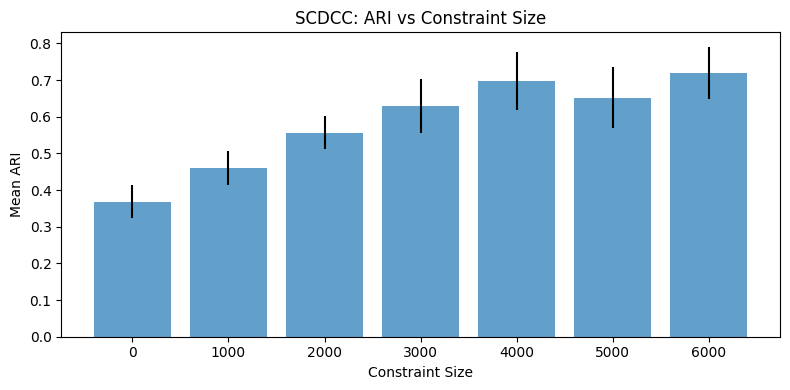

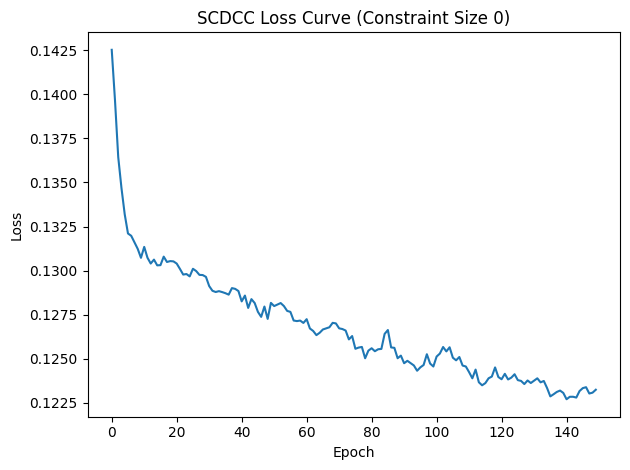

=== Visualizing constraint size: 0 ===


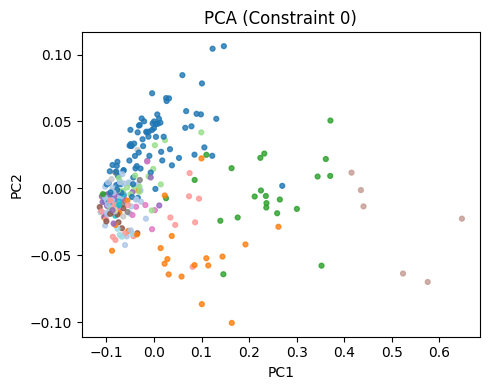

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


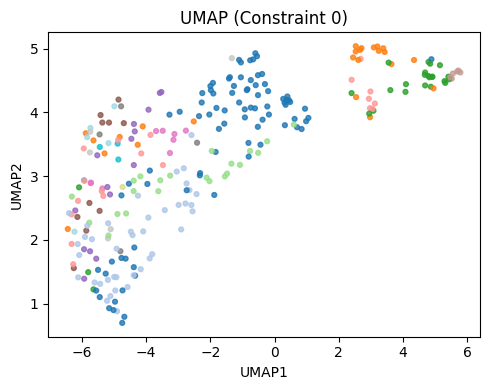

=== Visualizing constraint size: 1000 ===


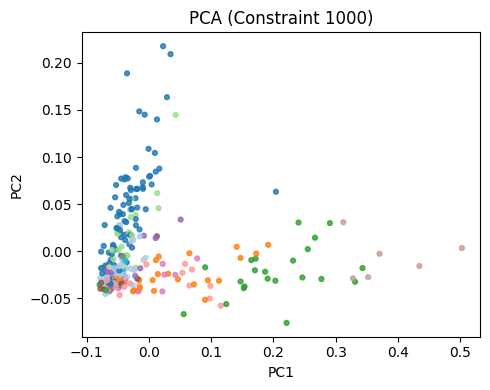

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


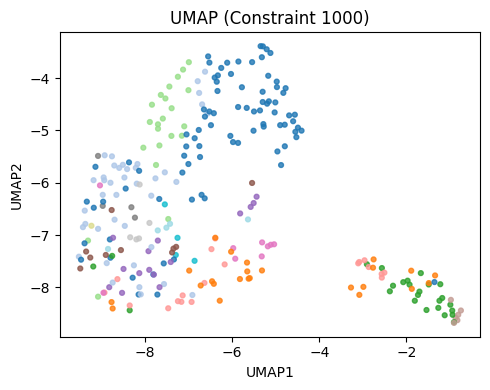

=== Visualizing constraint size: 2000 ===


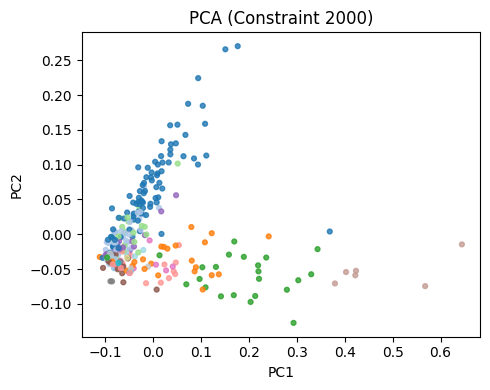

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


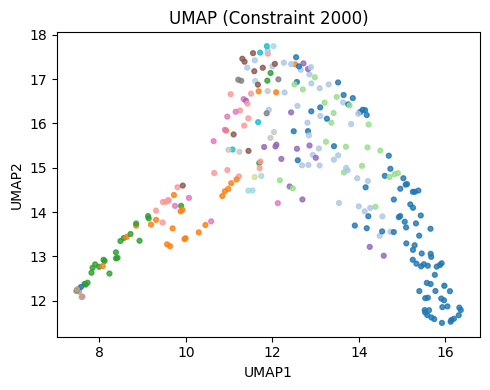

=== Visualizing constraint size: 3000 ===


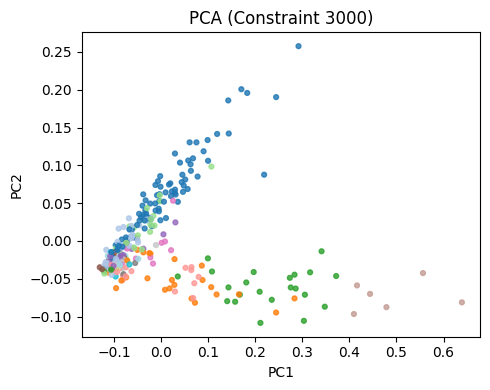

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


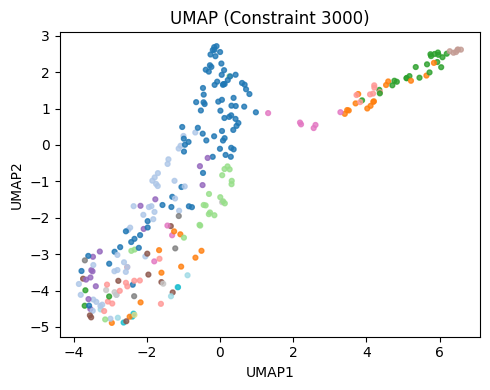

=== Visualizing constraint size: 4000 ===


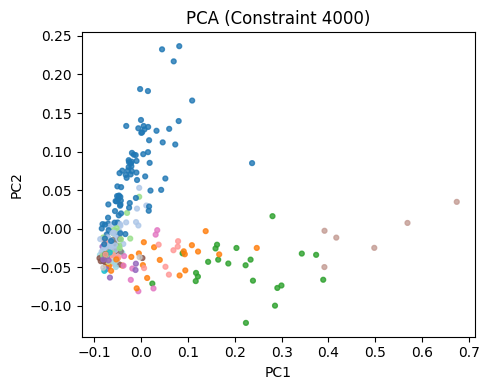

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


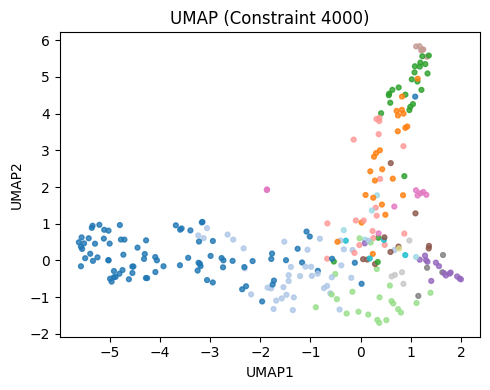

=== Visualizing constraint size: 5000 ===


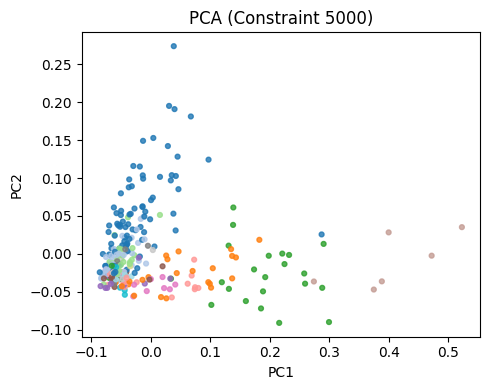

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


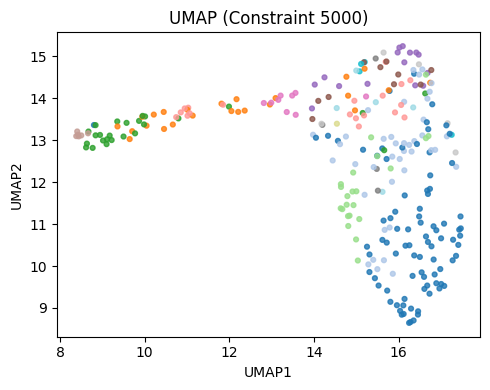

=== Visualizing constraint size: 6000 ===


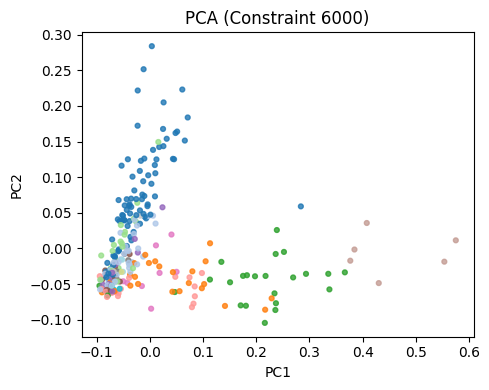

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


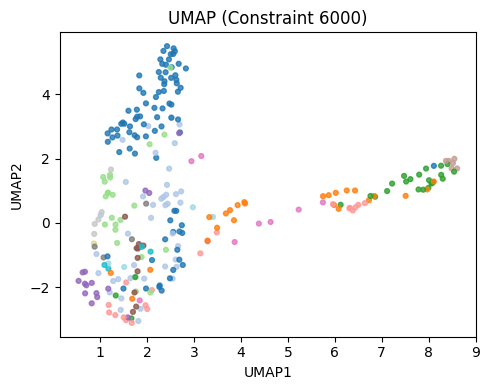

In [22]:
#  Preparing arrays from AnnData objects 
X_train = adata_raw_train.X.astype(np.float32)
X_val   = adata_raw_val.X.astype(np.float32)
X_test  = adata_raw_test.X.astype(np.float32)
y_train = adata_raw_train.obs["label"].astype(int).values
y_val   = adata_raw_val.obs["label"].astype(int).values
y_test  = adata_raw_test.obs["label"].astype(int).values

# Remaping constraints (from cell names to indices for training split):
cellname_to_idx = {name: i for i, name in enumerate(adata_raw_train.obs_names)}
def remap_pairs(pairs, mapping):
    return [(mapping[i], mapping[j]) for i, j in pairs if i in mapping and j in mapping]

constraints_idx = {
    size: {
        'must_link': remap_pairs(v['must_link'], cellname_to_idx),
        'cannot_link': remap_pairs(v['cannot_link'], cellname_to_idx)
    }
    for size, v in constraints.items()
}

#  Running SCDCC 
middle_idx = len(constraints_idx) // 2
results = run_full_scdcc_pipeline(
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    constraints_idx,
    latent_dims=[10, 20, 50],
    lrs=[1e-3, 5e-4],
    pretrain_epochs=300,
    train_epochs=150,
    n_repeats=10,
    alpha=1.0, beta=5.0, margin=2.0,
    tune_constraint_index=middle_idx    # <---- FIXED: No error now!
)

#  results
import pandas as pd
df = pd.DataFrame(results).T
display(df)

# Ploting ARI mean vs constraint size 
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.bar(df.index.astype(str), df["ARI_mean"], yerr=df["ARI_std"], alpha=0.7, label='ARI')
plt.title("SCDCC: ARI vs Constraint Size")
plt.xlabel("Constraint Size")
plt.ylabel("Mean ARI")
plt.tight_layout()
plt.show()

# Ploting training loss curve 
first_size = list(results.keys())[0]
plt.plot(results[first_size]['loss_curves'][0])
plt.title(f'SCDCC Loss Curve (Constraint Size {first_size})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

# 2D PCA/UMAP/Latent Visualization for Each Constraint Size 
from sklearn.decomposition import PCA
import umap

for size in results:
    print(f"=== Visualizing constraint size: {size} ===")
    # We'll just run a model again to get embeddings. You can save them during training if you want.
    model = scDCC(input_dim=X_train.shape[1], latent_dim=20).to(device)
    model.eval()
    with torch.no_grad():
        _, _, _, z_test = model(torch.tensor(X_test, dtype=torch.float32, device=device))
    z_test = z_test.cpu().numpy()

    # PCA
    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(z_test)
    plt.figure(figsize=(5,4))
    plt.scatter(z_pca[:,0], z_pca[:,1], c=y_test, cmap='tab20', s=12, alpha=0.8)
    plt.title(f"PCA (Constraint {size})")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

    # UMAP
    reducer = umap.UMAP(n_components=2, random_state=42)
    z_umap = reducer.fit_transform(z_test)
    plt.figure(figsize=(5,4))
    plt.scatter(z_umap[:,0], z_umap[:,1], c=y_test, cmap='tab20', s=12, alpha=0.8)
    plt.title(f"UMAP (Constraint {size})")
    plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
    plt.tight_layout()
    plt.show()




In [23]:
#  SCDCC,mean ± std from best constraint size:
best_size = max(results, key=lambda k: results[k]['ARI_mean'])
scdcc_ari = results[best_size]['ARI_mean']
scdcc_ari_std = results[best_size]['ARI_std']
scdcc_nmi = results[best_size]['NMI_mean']
scdcc_nmi_std = results[best_size]['NMI_std']
scdcc_ca = results[best_size]['CA_mean']
scdcc_ca_std = results[best_size]['CA_std']

#  KMeans and DEC, values:
kmeans_ari = kmeans_results["ARI"]
kmeans_nmi = kmeans_results["NMI"]
kmeans_ca  = kmeans_results["CA"]

dec_ari = dec_results["ARI"]
dec_nmi = dec_results["NMI"]
dec_ca  = dec_results["CA"]


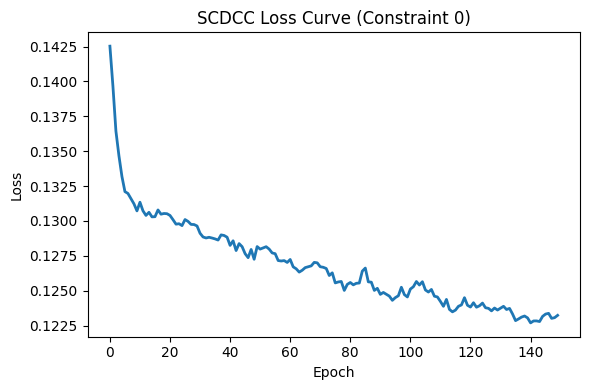

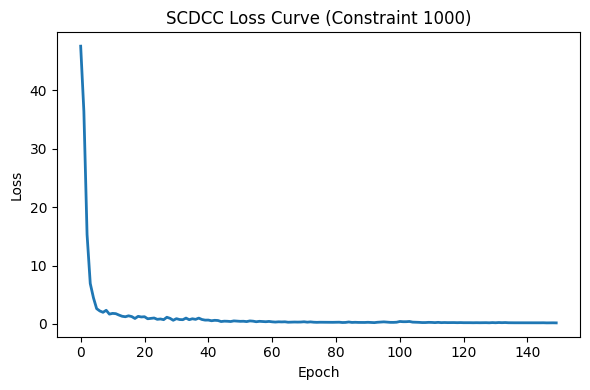

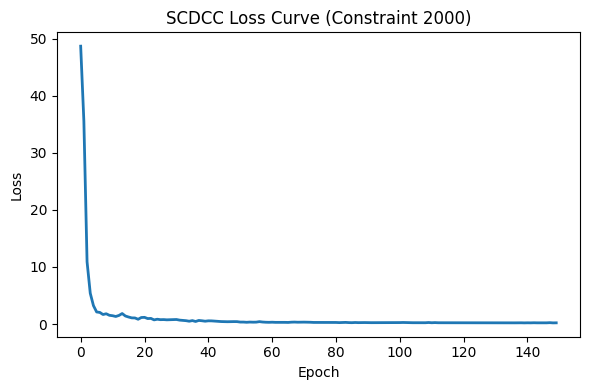

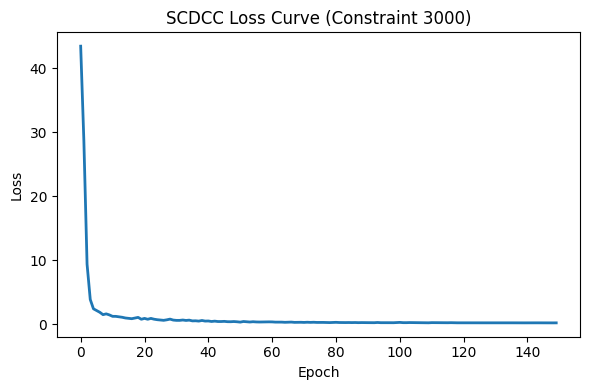

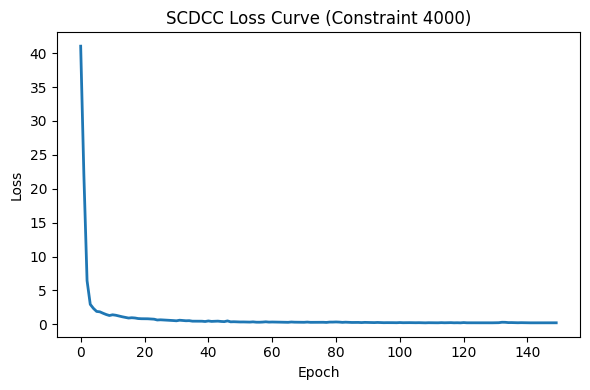

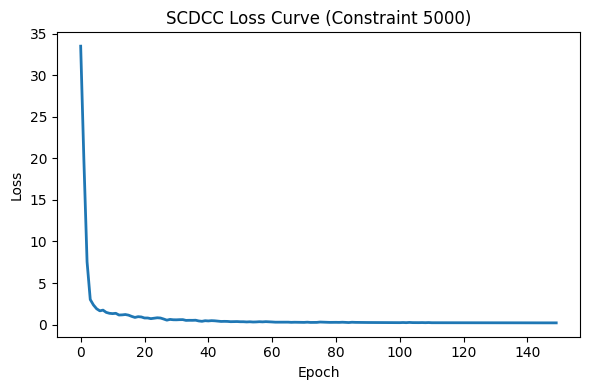

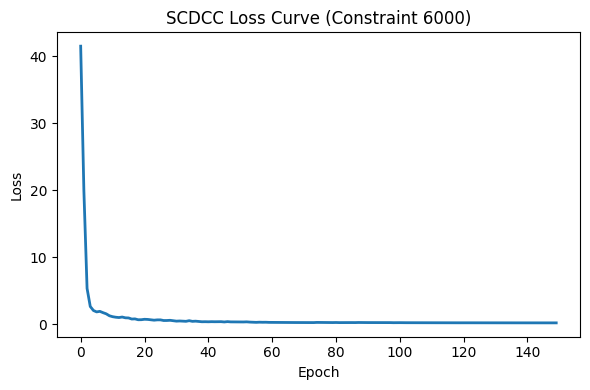

In [24]:
for size in results:
    loss_curve = results[size]['loss_curves'][0]  # first run, or loop for more
    plt.figure(figsize=(6,4))
    plt.plot(loss_curve, lw=2)
    plt.title(f"SCDCC Loss Curve (Constraint {size})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.show()


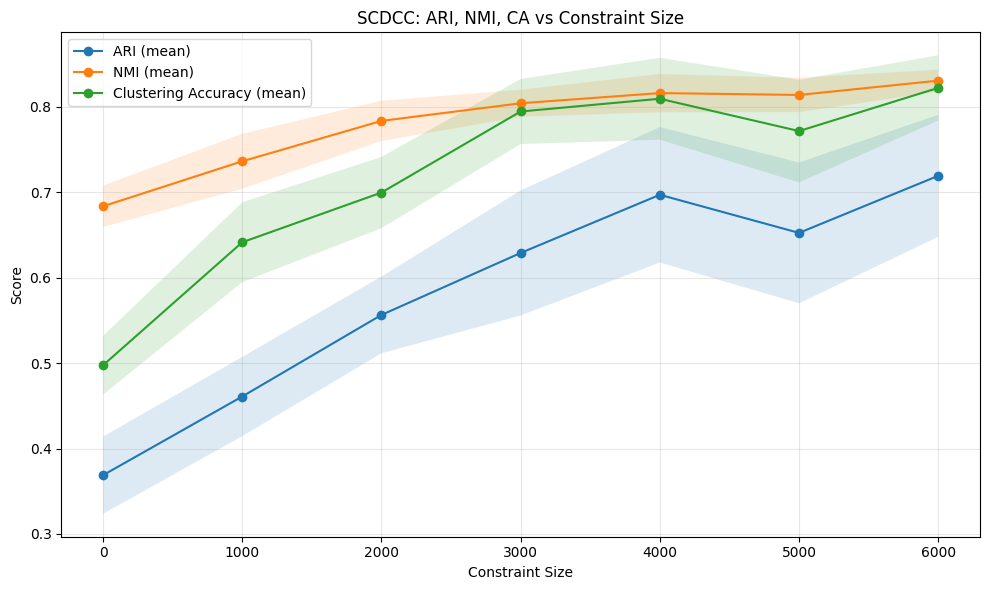

In [25]:

#Plotting line graph
metrics = [
    ("ARI_mean", "ARI_std", "ARI"),
    ("NMI_mean", "NMI_std", "NMI"),
    ("CA_mean",  "CA_std",  "Clustering Accuracy"),
]

sizes = list(results.keys())
sizes_int = [int(s) for s in sizes]
sort_idx = np.argsort(sizes_int)
sorted_sizes = [sizes[i] for i in sort_idx]
size_ticks = [int(s) for s in sorted_sizes]

plt.figure(figsize=(10, 6))
for mean_key, std_key, display_name in metrics:
    means = [results[s][mean_key] for s in sorted_sizes]
    stds  = [results[s][std_key]  for s in sorted_sizes]
    plt.plot(size_ticks, means, marker='o', label=f"{display_name} (mean)")
    plt.fill_between(size_ticks,
                     np.array(means) - np.array(stds),
                     np.array(means) + np.array(stds),
                     alpha=0.15)

plt.title("SCDCC: ARI, NMI, CA vs Constraint Size")
plt.xlabel("Constraint Size")
plt.ylabel("Score")
plt.xticks(size_ticks)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


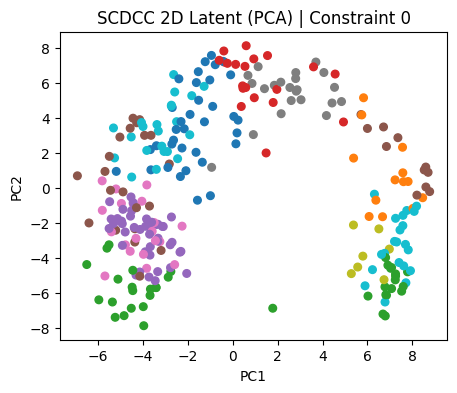

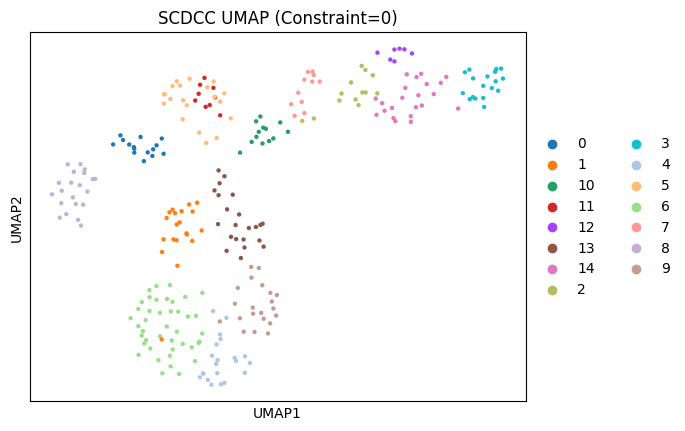

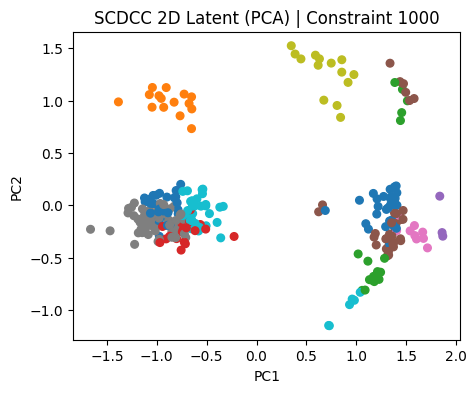

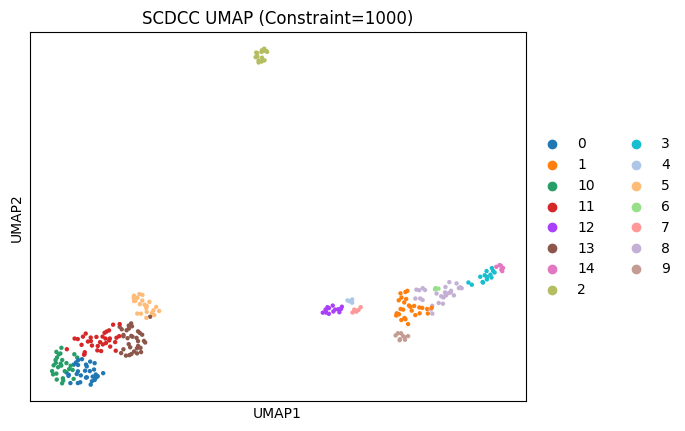

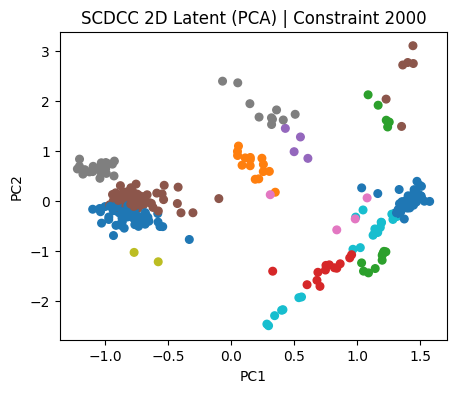

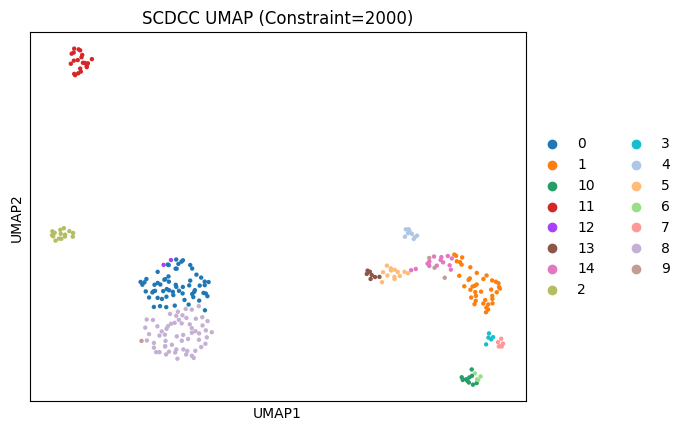

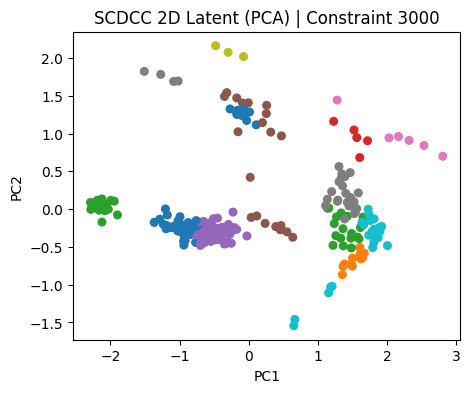

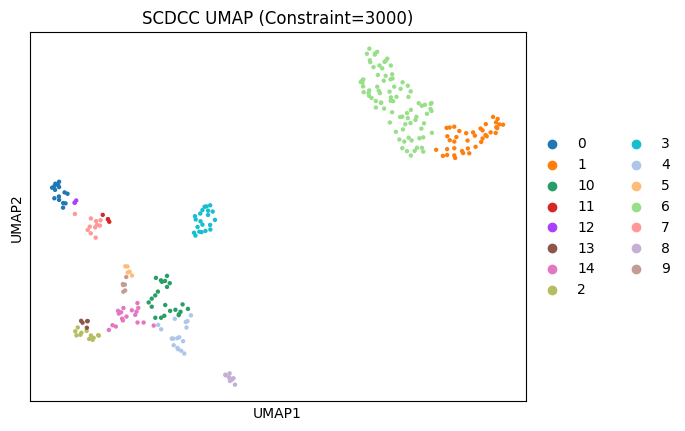

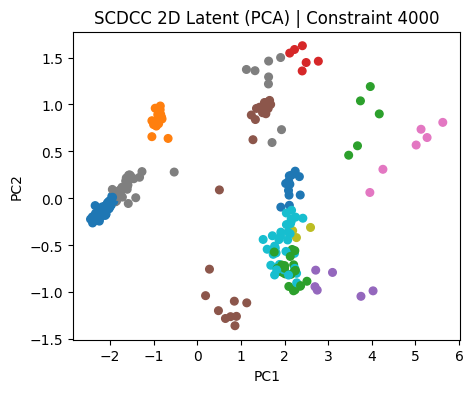

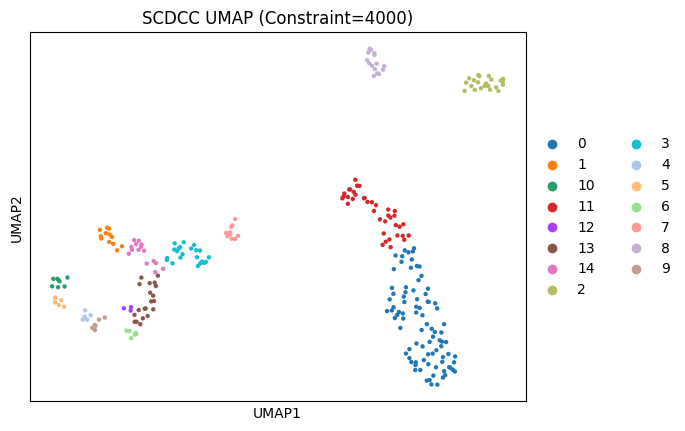

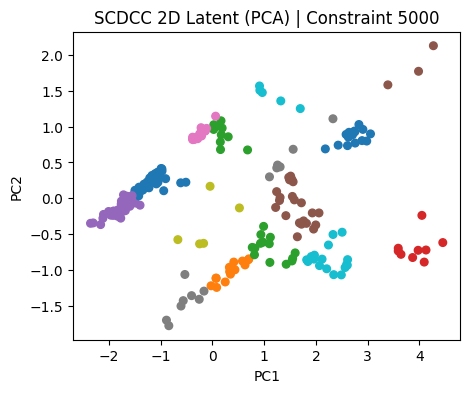

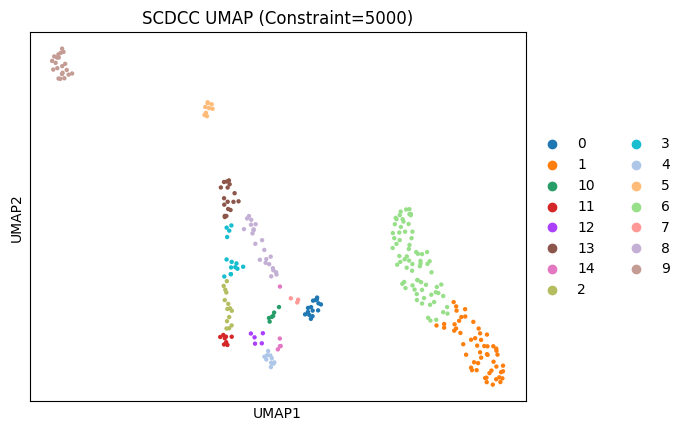

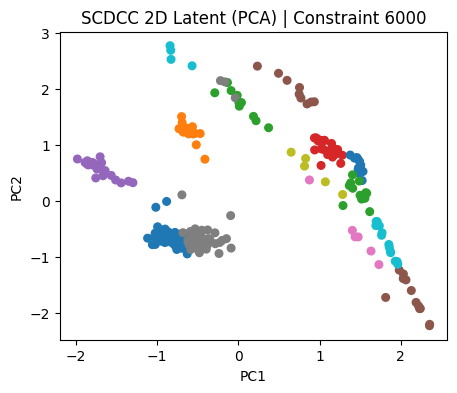

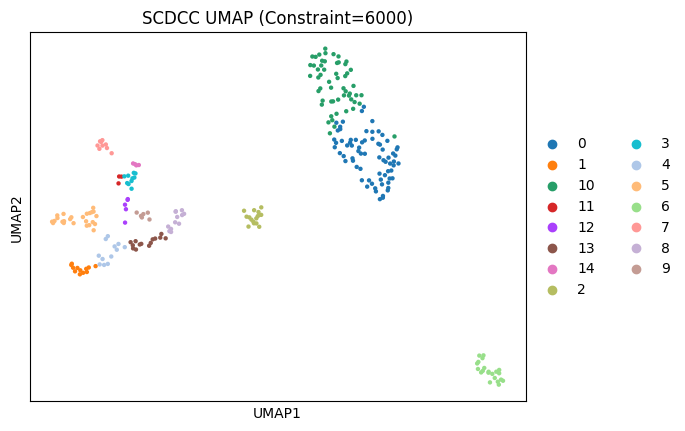

In [26]:


# For each constraint size, show 2D PCA and UMAP for the first run
for size in results:
    z_test = results[size]['z_tests'][0]
    preds = results[size]['test_preds'][0]

    # 2D PCA
    z_2d = PCA(n_components=2).fit_transform(z_test)
    plt.figure(figsize=(5,4))
    plt.scatter(z_2d[:,0], z_2d[:,1], c=preds, cmap='tab10', s=30)
    plt.title(f"SCDCC 2D Latent (PCA) | Constraint {size}")
    plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.show()

    # UMAP
    adata = sc.AnnData(z_test)
    adata.obs['cluster'] = pd.Categorical(preds.astype(str))
    sc.pp.neighbors(adata, use_rep='X')
    sc.tl.umap(adata)
    sc.pl.umap(adata, color='cluster', title=f"SCDCC UMAP (Constraint={size})", size=40)


In [27]:
# For SCDCC, take the mean ± std from best constraint size:
best_size = max(results, key=lambda k: results[k]['ARI_mean'])
scdcc_ari = results[best_size]['ARI_mean']
scdcc_ari_std = results[best_size]['ARI_std']
scdcc_nmi = results[best_size]['NMI_mean']
scdcc_nmi_std = results[best_size]['NMI_std']
scdcc_ca = results[best_size]['CA_mean']
scdcc_ca_std = results[best_size]['CA_std']

# For KMeans and DEC, just use the single values:
kmeans_ari = kmeans_results["ARI"]
kmeans_nmi = kmeans_results["NMI"]
kmeans_ca  = kmeans_results["CA"]

dec_ari = dec_results["ARI"]
dec_nmi = dec_results["NMI"]
dec_ca  = dec_results["CA"]


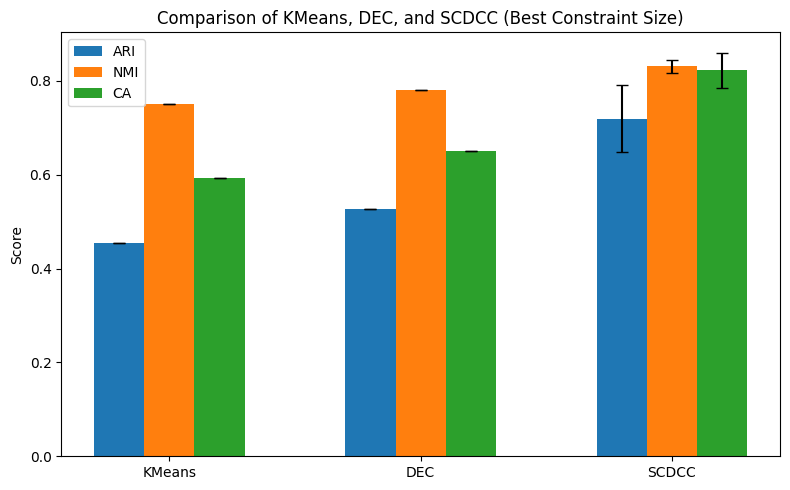

In [28]:

# bar plot
methods = ['KMeans', 'DEC', 'SCDCC']
ari_scores = [kmeans_ari, dec_ari, scdcc_ari]
ari_errs = [0, 0, scdcc_ari_std]  # only SCDCC has std (if you want to plot it)
nmi_scores = [kmeans_nmi, dec_nmi, scdcc_nmi]
nmi_errs = [0, 0, scdcc_nmi_std]
ca_scores = [kmeans_ca, dec_ca, scdcc_ca]
ca_errs = [0, 0, scdcc_ca_std]

x = np.arange(len(methods))
width = 0.2

plt.figure(figsize=(8, 5))
plt.bar(x - width, ari_scores, width, yerr=ari_errs, capsize=4, label='ARI')
plt.bar(x, nmi_scores, width, yerr=nmi_errs, capsize=4, label='NMI')
plt.bar(x + width, ca_scores, width, yerr=ca_errs, capsize=4, label='CA')
plt.xticks(x, methods)
plt.ylabel("Score")
plt.title("Comparison of KMeans, DEC, and SCDCC (Best Constraint Size)")
plt.legend()
plt.tight_layout()
plt.show()


In [29]:

#Result summary of Kmeans,DEC and SCDCC
summary = pd.DataFrame({
    'ARI': ari_scores,
    'NMI': nmi_scores,
    'CA': ca_scores
}, index=methods)

# Optionally include standard deviations
summary_std = pd.DataFrame({
    'ARI': ari_errs,
    'NMI': nmi_errs,
    'CA': ca_errs
}, index=methods)

print("=== Clustering Metrics Comparison (Best Constraint Size for SCDCC) ===")
print(summary)
if any(s > 0 for s in ari_errs + nmi_errs + ca_errs):
    print("\n(Standard deviations where available):")
    print(summary_std)


=== Clustering Metrics Comparison (Best Constraint Size for SCDCC) ===
             ARI       NMI        CA
KMeans  0.454723  0.751215  0.592727
DEC     0.525936  0.781011  0.650909
SCDCC   0.719247  0.830651  0.822182

(Standard deviations where available):
             ARI     NMI        CA
KMeans  0.000000  0.0000  0.000000
DEC     0.000000  0.0000  0.000000
SCDCC   0.071448  0.0129  0.038189
